# Setting Up `pymer4`

This block will send `mamba` which makes it possible to install `conda` packages on Colab. It will cause the kernel to "crash" this *expected*.

After the kernel restarts run the cell below this one and you should be all set!

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

‚è¨ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
üì¶ Installing...
üìå Adjusting configuration...
ü©π Patching environment...
‚è≤ Done in 0:00:10
üîÅ Restarting kernel...


Run EITHER of the two cells below after the kernel restarts (no need to re-run the one above)

In [ ]:
# Option 1: Latest stable version
# !mamba install -q pymer4 -c ejolly -c conda-forge

In [ ]:
# Option 2: Development version from the main branch on github
!mamba install -q pymer4 -c ejolly/label/pre-release -c conda-forge

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


Then you can run the next cell to test the installation!

In [ ]:
from pymer4 import test_install

test_install()

All required R libraries found:
('lmerTest', 'emmeans', 'tidyverse', 'broom', 'broom.mixed', 'arrow', 'report')
Installation working successfully!


# Setup

In [ ]:
# Import packages
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Pymer
from pymer4.models import lmer
from pymer4.models import compare
from pymer4.io import save_model

# Set Polars to display more columns
pl.Config.set_tbl_cols(30)

polars.config.Config

# Load the data

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Import dataframes
hrv_pd = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/vrtraining_data/hrv_data_colab.csv", index_col=["Unnamed: 0"])
rrv_pd = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/vrtraining_data/rrv_data_colab.csv", index_col=["Unnamed: 0"])

In [ ]:
# Reorder session variables for Baseline as reference
hrv_pd['session'] = pd.Categorical(
    hrv_pd['session'],
    categories=["Exam", 'Resting state', "Baseline"],
    ordered=True
)

rrv_pd['session'] = pd.Categorical(
    rrv_pd['session'],
    categories=["Exam", 'Resting state', "Baseline"],
    ordered=True
)


In [ ]:
# Convert to polars
hrv_data = pl.from_pandas(hrv_pd)
rrv_data = pl.from_pandas(rrv_pd)

In [ ]:
# Convert variables to categorical
cols_to_convert = ["session", "group", "instrument_type", "ID"]

hrv_data = hrv_data.with_columns([pl.col(c).cast(pl.Utf8).cast(pl.Categorical) for c in cols_to_convert])
rrv_data = rrv_data.with_columns([pl.col(c).cast(pl.Utf8).cast(pl.Categorical) for c in cols_to_convert])

# Convert gender to string and then to categorical
hrv_data = hrv_data.with_columns(pl.col("gender").cast(pl.Utf8).cast(pl.Categorical))
rrv_data = rrv_data.with_columns(pl.col("gender").cast(pl.Utf8).cast(pl.Categorical))

In [ ]:
# Inspect dataframes
print(hrv_data.head())
print(rrv_data.head())


shape: (5, 11)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ ID    ‚îÜ session ‚îÜ gender ‚îÜ group ‚îÜ instrume ‚îÜ HRV_SDNN ‚îÜ HRV_SD1 ‚îÜ HRV_LFH ‚îÜ HR  ‚îÜ HRmin ‚îÜ HRmax ‚îÇ
‚îÇ ---   ‚îÜ ---     ‚îÜ ---    ‚îÜ ---   ‚îÜ nt_type  ‚îÜ ---      ‚îÜ SD2     ‚îÜ F       ‚îÜ --- ‚îÜ ---   ‚îÜ ---   ‚îÇ
‚îÇ cat   ‚îÜ cat     ‚îÜ cat    ‚îÜ cat   ‚îÜ ---      ‚îÜ f64      ‚îÜ ---     ‚îÜ ---     ‚îÜ i64 ‚îÜ i64   ‚îÜ i64   ‚îÇ
‚îÇ       ‚îÜ         ‚îÜ        ‚îÜ       ‚îÜ cat      ‚îÜ          ‚îÜ f64     ‚îÜ f64     ‚îÜ     ‚îÜ       ‚îÜ       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚

Variable coding:
- gender: 1 = male, 2 = female;
- intrument_type: 1 = breath-control, 2 = non-breath-control

# Linear Mixed-Effects Modeling

### Functions

In [ ]:
# Create reusable function for re-referencing variable levels
def set_factors(model):
  # Baseline vs Resting state, Baseline vs Exam, ctr vs exp
  model.set_factors({"session": ["Baseline", "Resting state", "Exam"]})
  model.set_factors({"group": ["ctr", "exp"]})

In [ ]:
def set_factors(model):
  model.set_factors({
    "session": ["Baseline", "Resting state", "Exam"],
    "group": ["ctr", "exp"]
      })

In [ ]:
# Create separate dataframes for each DV
def filter_df_for_dv(df: pl.DataFrame, dv: str) -> pl.DataFrame:
    # List of fixed columns + dv
    columns_to_keep = ["ID", "session", "gender", "group", "instrument_type", dv]

    # Filter the DataFrame by selecting only these columns
    filtered_df = df.select(columns_to_keep)

    return filtered_df

In [ ]:
model_hr_ii.data

shape: (45, 17)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ ID  ‚îÜ ses ‚îÜ gen ‚îÜ gro ‚îÜ ins ‚îÜ HR  ‚îÜ fit ‚îÜ res ‚îÜ hat ‚îÜ coo ‚îÜ fix ‚îÜ mu  ‚îÜ off ‚îÜ sqr ‚îÜ sqr ‚îÜ wei ‚îÜ wtr ‚îÇ
‚îÇ --- ‚îÜ sio ‚îÜ der ‚îÜ up  ‚îÜ tru ‚îÜ --- ‚îÜ ted ‚îÜ id  ‚îÜ --- ‚îÜ ksd ‚îÜ ed  ‚îÜ --- ‚îÜ set ‚îÜ tXw ‚îÜ trw ‚îÜ ght ‚îÜ es  ‚îÇ
‚îÇ cat ‚îÜ n   ‚îÜ --- ‚îÜ --- ‚îÜ men ‚îÜ i64 ‚îÜ --- ‚îÜ --- ‚îÜ f64 ‚îÜ --- ‚îÜ --- ‚îÜ f64 ‚îÜ --- ‚îÜ t   ‚îÜ t   ‚îÜ s   ‚îÜ --- ‚îÇ
‚îÇ     ‚îÜ --- ‚îÜ cat ‚îÜ enu ‚îÜ t_t ‚îÜ     ‚îÜ f64 ‚îÜ f64 ‚îÜ     ‚îÜ f64 ‚îÜ f64 ‚îÜ     ‚îÜ f64 ‚îÜ --- ‚îÜ --- ‚îÜ --- ‚îÜ f64 ‚îÇ
‚îÇ     ‚îÜ enu ‚îÜ     ‚îÜ m   ‚îÜ ype ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ f64 ‚îÜ f64 ‚îÜ f64 ‚îÜ     ‚îÇ
‚îÇ     ‚îÜ m   ‚îÜ     ‚îÜ     ‚îÜ --- ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÇ
‚îÇ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ cat ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ vrt ‚îÜ Exa ‚îÜ 1   ‚îÜ exp ‚îÜ 2   ‚îÜ 141 ‚îÜ 3.0 ‚îÜ 13. ‚îÜ 0.2 ‚îÜ 0.0 ‚îÜ 122 ‚îÜ 127 ‚îÜ 0.0 ‚îÜ 1.0 ‚îÜ 1.0 ‚îÜ 1.0 ‚îÜ 13. ‚îÇ
‚îÇ 02  ‚îÜ m   ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ 311 ‚îÜ 242 ‚îÜ 497 ‚îÜ 300 ‚îÜ .91 ‚îÜ .75 ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ 242 ‚îÇ
‚îÇ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ e-3 ‚îÜ 872 ‚îÜ 4   ‚îÜ 79  ‚îÜ 666 ‚îÜ 712 ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ 872 ‚îÇ
‚îÇ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ 15  ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ 7   ‚îÜ 8   ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÇ
‚îÇ vrt ‚îÜ Exa ‚îÜ 1   ‚îÜ exp ‚îÜ 2   ‚îÜ 164 ‚îÜ 3.1 ‚îÜ 35. ‚îÜ 0.2 ‚îÜ 0.2 ‚îÜ 122 ‚îÜ 128 ‚îÜ 0.0 ‚îÜ 1.0 ‚îÜ 1.0 ‚îÜ 1.0 ‚îÜ 35. ‚îÇ
‚îÇ 03  ‚îÜ m   ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ 711 ‚îÜ 666 ‚îÜ 497 ‚îÜ 181 ‚îÜ .91 ‚îÜ .33 ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ 666 ‚îÇ
‚îÇ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ e-3 ‚îÜ 341 ‚îÜ 4   ‚îÜ 77  ‚îÜ 666 ‚îÜ 365 ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ 341 ‚îÇ
‚îÇ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ 15  ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ 7   ‚îÜ 9   ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÇ
‚îÇ vrt ‚îÜ Exa ‚îÜ 2   ‚îÜ ctr ‚îÜ 2   ‚îÜ 91  ‚îÜ 3.1 ‚îÜ -22 ‚îÜ 0.2 ‚îÜ 0.1 ‚îÜ 121 ‚îÜ 113 ‚îÜ 0.0 ‚îÜ 1.0 ‚îÜ 1.0 ‚îÜ 1.0 ‚îÜ -22 ‚îÇ
‚îÇ 05  ‚îÜ m   ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ 576 ‚îÜ .46 ‚îÜ 926 ‚îÜ 141 ‚îÜ .35 ‚îÜ .46 ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ .46 ‚îÇ
‚îÇ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ e-3 ‚îÜ 589 ‚îÜ 9   ‚îÜ 47  ‚îÜ 416 ‚îÜ 589 ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ 589 ‚îÇ
‚îÇ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ 15  ‚îÜ 7   ‚îÜ     ‚îÜ     ‚îÜ 7   ‚îÜ 7   ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ 7   ‚îÇ
‚îÇ vrt ‚îÜ Exa ‚îÜ 2   ‚îÜ exp ‚îÜ 1   ‚îÜ 140 ‚îÜ 3.1 ‚îÜ 5.3 ‚îÜ 0.2 ‚îÜ 0.0 ‚îÜ 137 ‚îÜ 134 ‚îÜ 0.0 ‚îÜ 1.0 ‚îÜ 1.0 ‚îÜ 1.0 ‚îÜ 5.3 ‚îÇ
‚îÇ 06  ‚îÜ m   ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ 446 ‚îÜ 453 ‚îÜ 556 ‚îÜ 050 ‚îÜ .35 ‚îÜ .65 ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ 453 ‚îÇ
‚îÇ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ e-3 ‚îÜ 21  ‚îÜ 53  ‚îÜ 97  ‚îÜ 416 ‚îÜ 467 ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ 21  ‚îÇ
‚îÇ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ 15  ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ 7   ‚îÜ 9   ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÜ     ‚îÇ
‚îÇ vrt ‚îÜ Exa ‚îÜ 2   ‚îÜ exp ‚îÜ 1   ‚îÜ 87  ‚îÜ 3.0 ‚îÜ -40 ‚îÜ 0.2 ‚îÜ 0.2 ‚îÜ 137 ‚îÜ 127 ‚îÜ 0.0 ‚îÜ 1.0 ‚îÜ 1.0 ‚îÜ 1.0 ‚îÜ -40 ‚îÇ
‚îÇ 

In [ ]:
# Assumption checks function
def visual_check(model, dv: str):
    """
    Visual diagnostic plots for a pymer4 model.
    Args:
      model: fitted pymer4 model
      dv: dependent variable name (not directly used here but can be included for titles)
    """
    # Convert model data from polars to pandas for plotting
    df = model.data.to_pandas()

    # Extract observed and fitted values
    observed_values = df[dv]
    fitted_values = df['fitted']

    # Calculate standardized residuals
    residuals = df['resid']
    std_resids = (residuals - np.mean(residuals)) / np.std(residuals)

    # Plot 1: Observed vs Fitted
    plt.figure(figsize=(6, 4))
    sns.regplot(x=fitted_values, y=observed_values, ci=95, scatter_kws={"s": 50, "alpha": 0.6})
    plt.xlabel("Fitted Values")
    plt.ylabel("Observed Values")
    plt.title(f"Observed vs Fitted Values ({dv})")
    sns.despine()
    plt.show()

    # Plot 2: Residuals distribution
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, kde=True)
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.title("Residuals Distribution")
    plt.axvline(0, color="k", linestyle="--", linewidth=2)
    sns.despine()
    plt.show()

    # Plot 3: Standardized residuals vs Fitted
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=fitted_values, y=std_resids)
    plt.axhline(0, color='red', linestyle='--')
    plt.axhline(2.5, color="blue", linestyle="--")
    plt.axhline(-2.5, color="blue", linestyle="--")
    plt.xlabel("Fitted values")
    plt.ylabel("Standardized Residuals")
    plt.title("Standardized Residuals vs Fitted values")
    sns.despine()
    plt.show()


In [ ]:
# Filter outliers
def reject_outliers(model):
    # Convert polars to pandas for easier numeric ops (optional)
    model_data_pd = model.data.to_pandas()

    # Calculate residuals and standardized residuals
    resids = model_data_pd['resid']  # check actual residual column name
    std_resids = (resids - np.mean(resids)) / np.std(resids)

    # Add standardized residuals back to pandas DF
    model_data_pd['std_resid'] = std_resids

    # Identify outliers in pandas DF
    outliers = model_data_pd[np.abs(model_data_pd['std_resid']) > 2.5]

    # Filter out outliers from the original polars DataFrame by ID
    outlier_ids = outliers['ID'].tolist()

    # Filter original polars DF
    filtered_model_data = model.data.filter(~pl.col('ID').is_in(outlier_ids))

    return filtered_model_data


## Heart rate

### Modeling

In [ ]:
hr_df = filter_df_for_dv(hrv_data, "HR")

In [ ]:
model_hr_i = lmer("HR ~ group * session + (1 | ID)",
               data=hr_df)

# Set reference level
set_factors(model_hr_i)

model_hr_i.fit(summary=True)

GT(_tbl_data=shape: (10, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ rfx      ‚îÜ param   ‚îÜ estimat ‚îÜ std_err ‚îÜ conf_lo ‚îÜ conf_hi ‚îÜ t_stat  ‚îÜ df      ‚îÜ p_value ‚îÜ stars ‚îÇ
‚îÇ ---      ‚îÜ ---     ‚îÜ e       ‚îÜ or      ‚îÜ w       ‚îÜ gh      ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---   ‚îÇ
‚îÇ str      ‚îÜ str     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ f64     ‚îÜ f64     ‚îÜ str     ‚îÜ str   ‚îÇ
‚îÇ          ‚îÜ         ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ ID-sd    ‚îÜ (Interc ‚îÜ 11.5826 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ 04      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ Residual ‚îÜ Observa ‚îÜ 19.2237 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ -sd      ‚îÜ tion    ‚îÜ 16      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Fixed    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Effects: ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ (Interc ‚îÜ 100.333 ‚îÜ 9.16249 ‚îÜ 81.7160 ‚îÜ 118.950 ‚îÜ 10.9504 ‚îÜ 34.1544 ‚îÜ <.001   ‚îÜ ***   ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ 333     ‚îÜ 6       ‚îÜ 02      ‚îÜ 664     ‚îÜ 37      ‚îÜ 36      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ -2.8888 ‚îÜ 11.8287 ‚îÜ -26.923 ‚îÜ 21.1459 ‚îÜ -0.2442 ‚îÜ 34.1544 ‚îÜ 0.8085  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p       ‚îÜ 89      ‚îÜ 31      ‚îÜ 76      ‚îÜ 82      ‚îÜ 26      ‚îÜ 36      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ session ‚îÜ -11.666 ‚îÜ 11.0988 ‚îÜ -34.480 ‚îÜ 11.1472 ‚îÜ -1.0511 ‚îÜ 26.0    ‚îÜ 0.3029  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ Resting ‚îÜ 667     ‚îÜ 18      ‚îÜ 614     ‚îÜ 8       ‚îÜ 63      ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ state   ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ session ‚îÜ 25.8333 ‚îÜ 11.0988 ‚îÜ 3.01938 ‚îÜ 48.6472 ‚îÜ 2.32757 ‚îÜ 26.0    ‚îÜ 0.02799 ‚îÜ *     ‚îÇ
‚îÇ          ‚îÜ Exam    ‚îÜ 33      ‚îÜ 18      ‚îÜ 6       ‚îÜ 8       ‚îÜ 5       ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ -1.8888 ‚îÜ 14.3285 ‚îÜ -31.341 ‚îÜ 27.5637 ‚îÜ -0.1318 ‚îÜ 26.0    ‚îÜ 0.8961  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p:sessi ‚îÜ 89      ‚îÜ 12      ‚îÜ 568     ‚îÜ 9       ‚îÜ 27      ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ onResti ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ ng      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ state   ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ 6.05555 ‚îÜ 14.3285 ‚îÜ -23.397 ‚îÜ 35.5082 ‚îÜ 0.42262 ‚îÜ 26.0    ‚îÜ 0.676   ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p:sessi ‚îÜ 6       ‚îÜ 12      ‚îÜ 123     ‚îÜ 34      ‚îÜ 3       ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ onExam  ‚îÜ         ‚îÜ        

In [ ]:
model_hr_ii = lmer("HR ~ group * session + instrument_type + (1 | ID)",
                   data=hr_df)

set_factors(model_hr_ii)

model_hr_ii.fit(summary=True)

GT(_tbl_data=shape: (11, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ rfx      ‚îÜ param   ‚îÜ estimat ‚îÜ std_err ‚îÜ conf_lo ‚îÜ conf_hi ‚îÜ t_stat  ‚îÜ df      ‚îÜ p_value ‚îÜ stars ‚îÇ
‚îÇ ---      ‚îÜ ---     ‚îÜ e       ‚îÜ or      ‚îÜ w       ‚îÜ gh      ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---   ‚îÇ
‚îÇ str      ‚îÜ str     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ f64     ‚îÜ f64     ‚îÜ str     ‚îÜ str   ‚îÇ
‚îÇ          ‚îÜ         ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ ID-sd    ‚îÜ (Interc ‚îÜ 9.68717 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ 3       ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ Residual ‚îÜ Observa ‚îÜ 19.2237 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ -sd      ‚îÜ tion    ‚îÜ 17      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Fixed    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Effects: ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ (Interc ‚îÜ 95.5208 ‚îÜ 9.16592 ‚îÜ 76.8570 ‚îÜ 114.184 ‚îÜ 10.4213 ‚îÜ 32.2900 ‚îÜ <.001   ‚îÜ ***   ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ 33      ‚îÜ 2       ‚îÜ 35      ‚îÜ 632     ‚îÜ 01      ‚îÜ 31      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ ‚Ä¶        ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶     ‚îÇ
‚îÇ null     ‚îÜ session ‚îÜ -11.666 ‚îÜ 11.0988 ‚îÜ -34.480 ‚îÜ 11.1472 ‚îÜ -1.0511 ‚îÜ 26.0    ‚îÜ 0.3029  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ Resting ‚îÜ 667     ‚îÜ 18      ‚îÜ 614     ‚îÜ 8       ‚îÜ 63      ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ state   ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ session ‚îÜ 25.8333 ‚îÜ 11.0988 ‚îÜ 3.01938 ‚îÜ 48.6472 ‚îÜ 2.32757 ‚îÜ 26.0    ‚îÜ 0.02799 ‚îÜ *     ‚îÇ
‚îÇ          ‚îÜ Exam    ‚îÜ 33      ‚îÜ 18      ‚îÜ 6       ‚îÜ 8       ‚îÜ 5       ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ instrum ‚îÜ 14.4375 ‚îÜ 7.81270 ‚îÜ -2.5849 ‚îÜ 31.4599 ‚îÜ 1.84795 ‚îÜ 12.0    ‚îÜ 0.08939 ‚îÜ .     ‚îÇ
‚îÇ          ‚îÜ ent_typ ‚îÜ         ‚îÜ 1       ‚îÜ 14      ‚îÜ 14      ‚îÜ 2       ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ e1      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ -1.8888 ‚îÜ 14.3285 ‚îÜ -31.341 ‚îÜ 27.5637 ‚îÜ -0.1318 ‚îÜ 26.0    ‚îÜ 0.8961  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p:sessi ‚îÜ 89      ‚îÜ 12      ‚îÜ 568     ‚îÜ 9       ‚îÜ 27      ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ onResti ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ ng      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ state   ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ

In [ ]:
model_hr_iii = lmer("HR ~ group * session + instrument_type + gender + (1 | ID)",
                    data=hr_df)

set_factors(model_hr_iii)

model_hr_iii.fit(summary=True)

GT(_tbl_data=shape: (12, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ rfx      ‚îÜ param   ‚îÜ estimat ‚îÜ std_err ‚îÜ conf_lo ‚îÜ conf_hi ‚îÜ t_stat  ‚îÜ df      ‚îÜ p_value ‚îÜ stars ‚îÇ
‚îÇ ---      ‚îÜ ---     ‚îÜ e       ‚îÜ or      ‚îÜ w       ‚îÜ gh      ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---   ‚îÇ
‚îÇ str      ‚îÜ str     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ f64     ‚îÜ f64     ‚îÜ str     ‚îÜ str   ‚îÇ
‚îÇ          ‚îÜ         ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ ID-sd    ‚îÜ (Interc ‚îÜ 10.2068 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ 91      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ Residual ‚îÜ Observa ‚îÜ 19.2237 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ -sd      ‚îÜ tion    ‚îÜ 17      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Fixed    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Effects: ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ (Interc ‚îÜ 99.2319 ‚îÜ 10.7877 ‚îÜ 76.9332 ‚îÜ 121.530 ‚îÜ 9.19857 ‚îÜ 23.3301 ‚îÜ <.001   ‚îÜ ***   ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ 44      ‚îÜ 57      ‚îÜ 27      ‚îÜ 662     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ ‚Ä¶        ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶     ‚îÇ
‚îÇ null     ‚îÜ session ‚îÜ 25.8333 ‚îÜ 11.0988 ‚îÜ 3.01938 ‚îÜ 48.6472 ‚îÜ 2.32757 ‚îÜ 26.0    ‚îÜ 0.02799 ‚îÜ *     ‚îÇ
‚îÇ          ‚îÜ Exam    ‚îÜ 33      ‚îÜ 18      ‚îÜ 6       ‚îÜ 8       ‚îÜ 5       ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ instrum ‚îÜ 14.4375 ‚îÜ 7.99663 ‚îÜ -3.1629 ‚îÜ 32.0379 ‚îÜ 1.80544 ‚îÜ 11.0    ‚îÜ 0.09842 ‚îÜ .     ‚îÇ
‚îÇ          ‚îÜ ent_typ ‚îÜ         ‚îÜ 9       ‚îÜ 84      ‚îÜ 84      ‚îÜ 6       ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ e1      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ gender2 ‚îÜ -5.5666 ‚îÜ 8.25889 ‚îÜ -23.744 ‚îÜ 12.6110 ‚îÜ -0.6740 ‚îÜ 11.0    ‚îÜ 0.5142  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ         ‚îÜ 67      ‚îÜ 3       ‚îÜ 368     ‚îÜ 35      ‚îÜ 21      ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ -1.8888 ‚îÜ 14.3285 ‚îÜ -31.341 ‚îÜ 27.5637 ‚îÜ -0.1318 ‚îÜ 26.0    ‚îÜ 0.8961  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p:sessi ‚îÜ 89      ‚îÜ 12      ‚îÜ 568     ‚îÜ 9       ‚îÜ 27      ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ onResti ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ ng      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ state   ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ 6.05555 ‚îÜ 14.3285 ‚îÜ -23.397 ‚îÜ 35.5082 ‚îÜ 0.42262 ‚îÜ 26.0    ‚îÜ 0.676   ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p:sessi ‚îÜ

In [ ]:
compare(model_hr_i, model_hr_ii, model_hr_iii)

GT(_tbl_data=shape: (3, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ AIC        ‚îÜ BIC       ‚îÜ logLik    ‚îÜ npar ‚îÜ -2*log(L) ‚îÜ Chisq    ‚îÜ Df  ‚îÜ Pr(>Chisq ‚îÜ stars ‚îÜ ids ‚îÇ
‚îÇ ---        ‚îÜ ---       ‚îÜ ---       ‚îÜ ---  ‚îÜ ---       ‚îÜ ---      ‚îÜ --- ‚îÜ )         ‚îÜ ---   ‚îÜ --- ‚îÇ
‚îÇ f64        ‚îÜ f64       ‚îÜ f64       ‚îÜ i64  ‚îÜ f64       ‚îÜ f64      ‚îÜ f64 ‚îÜ ---       ‚îÜ str   ‚îÜ i64 ‚îÇ
‚îÇ            ‚îÜ           ‚îÜ           ‚îÜ      ‚îÜ           ‚îÜ          ‚îÜ     ‚îÜ str       ‚îÜ       ‚îÜ     ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 378.800844 ‚îÜ 393.25414 ‚îÜ -181.4004 ‚îÜ 8    ‚îÜ 398.36879 ‚îÜ 0.0      ‚îÜ 0.0 ‚îÜ           ‚îÜ       ‚îÜ 1   ‚îÇ
‚îÇ            ‚îÜ 4         ‚îÜ 22        ‚îÜ      ‚îÜ 9         ‚îÜ          ‚îÜ     ‚îÜ           ‚îÜ       ‚îÜ     ‚îÇ
‚îÇ 371.636434 ‚îÜ 387.89639 ‚îÜ -176.8182 ‚îÜ 9    ‚îÜ 394.61235 ‚îÜ 3.756446 ‚îÜ 1.0 ‚îÜ 0.0526    ‚îÜ .     ‚îÜ 2   ‚îÇ
‚îÇ            ‚îÜ 7         ‚îÜ 17        ‚îÜ      ‚îÜ 3         ‚îÜ          ‚îÜ     ‚îÜ           ‚îÜ       ‚îÜ     ‚îÇ
‚îÇ 367.134469 ‚îÜ 385.20109 ‚îÜ -173.5672 ‚îÜ 10   ‚îÜ 394.00529 ‚îÜ 0.607054 ‚îÜ 1.0 ‚îÜ 0.436     ‚îÜ       ‚îÜ 3   ‚îÇ
‚îÇ            ‚îÜ 4         ‚îÜ 34        ‚îÜ      ‚îÜ 8         ‚îÜ          ‚îÜ     ‚îÜ           ‚îÜ       ‚îÜ     ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò, _body=<great_tables._gt_data.Body object at 0x7b2a1715b1d0>, _boxhead=Boxhead([ColInfo(var='ids', type=<ColInfoTypeEnum.stub: 2>, column_label='', column_align='right', column_width=None), ColInfo(var='AIC', type=<ColInfoTypeEnum.default: 1>, column_label='AIC', column_align='right', column_width=None), ColInfo(var='BIC', type=<ColInfoTypeEnum.default: 1>, column_label='BIC', column_align='right', column_width=None), ColInfo(var='logLik', type=<ColInfoTypeEnum.default: 1>, column_label='logLik', column_align='right', column_width=None), ColInfo(var='npar', type=<ColInfoTypeEnum.default: 1>, column_label='npar', column_align='right', column_width=None), ColInfo(var='-2*log(L)', type=<ColInfoTypeEnum.default: 1>, column_label='-2*log(L)', column_align='right', column_width=None), ColInfo(var='Chisq', type=<ColInfoTypeEnum.default: 1>, column_label='Chisq', column_align='right', column_width=None), ColInfo(var='Df', type=<ColInfoTypeEnum.default: 1>, column_label='Df', column_align='right', column_width=None), ColInfo(var='Pr(>Chisq)', type=<ColInfoTypeEnum.default: 1>, column_label='Pr(>Chisq)', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7b2a1735de50>, _spanners=Spanners([]), _heading=Heading(title='Analysis of Deviance Table', subtitle=Md(text='Model 1: lmer(HR~group*session+(1|ID))   \nModel 2: lmer(HR~group*session+instrument_type+(1|ID))   \nModel 3: lmer(HR~group*session+instrument_type+gender+(1|ID))   \n'), preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7b2a17208810>, _formats=[<great_tables._gt_data.Format

Model iii seems to be the best model according to AIC, BIC and logLIK, but gender does not add significantly to the model's fit --> Thus we picked model ii

### Assumptions

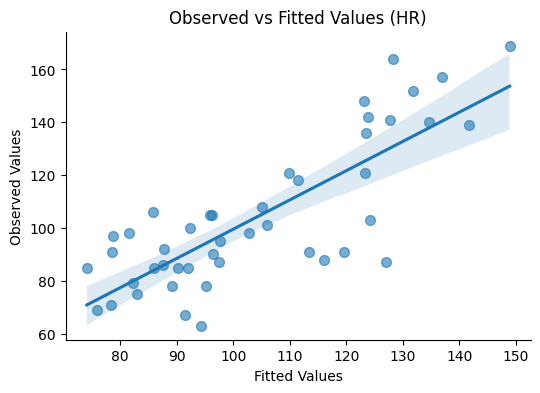

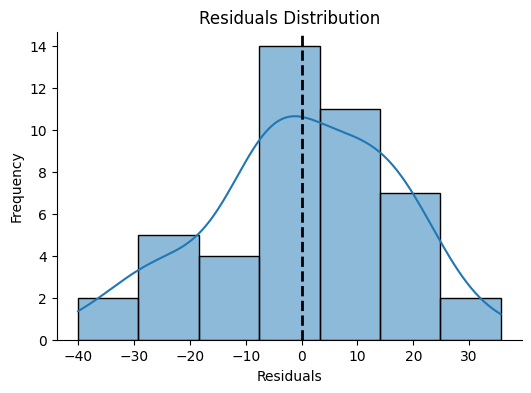

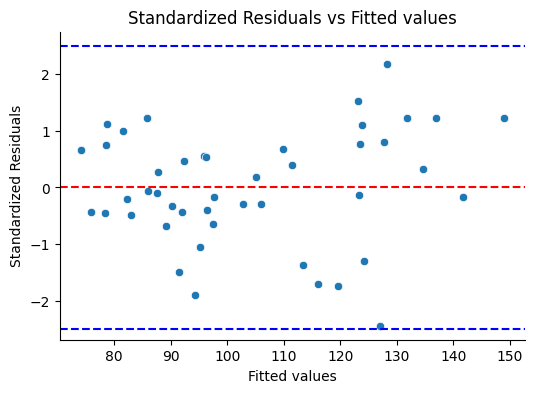

In [ ]:
# Check observed vs fitted, residuals vs frequency, residuals vs fitted plots
visual_check(model_hr_ii, dv="HR")

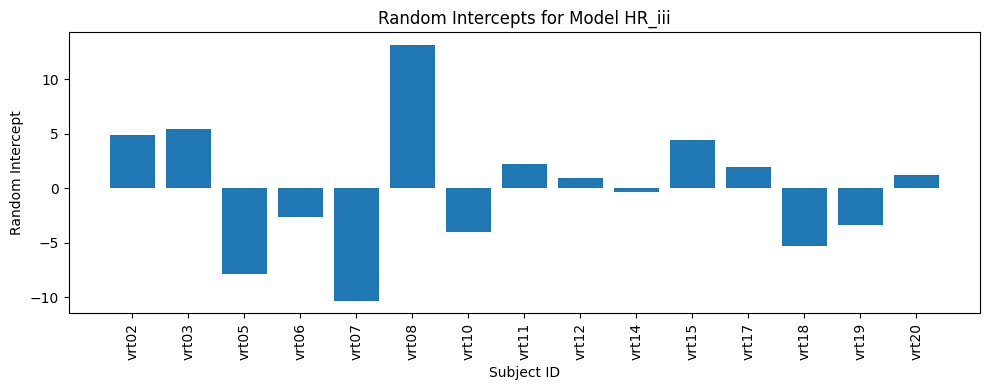

In [ ]:
# Plotting random effects -- refer to it in the main text, put it in the supplementary materials
re_df = model_hr_ii.ranef
plt.figure(figsize=(10,4))
plt.bar(re_df['level'], re_df['(Intercept)'])
plt.title('Random Intercepts for Model HR_iii')
plt.xlabel('Subject ID')
plt.ylabel('Random Intercept')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Model fit

In [ ]:
# Fitting stats and variance partitioning
model_hr = model_hr_ii.result_fit_stats
model_hr_ii.result_fit_stats

shape: (1, 13)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ AIC ‚îÜ AIC ‚îÜ BIC ‚îÜ ICC    ‚îÜ R2_con ‚îÜ R2_ma ‚îÜ REMLc ‚îÜ RMSE  ‚îÜ Sigma ‚îÜ df_re ‚îÜ logLi ‚îÜ nobs ‚îÜ sigma ‚îÇ
‚îÇ --- ‚îÜ c   ‚îÜ --- ‚îÜ ---    ‚îÜ dition ‚îÜ rgina ‚îÜ rit   ‚îÜ ---   ‚îÜ ---   ‚îÜ sidua ‚îÜ k     ‚îÜ ---  ‚îÜ ---   ‚îÇ
‚îÇ f64 ‚îÜ --- ‚îÜ f64 ‚îÜ f64    ‚îÜ al     ‚îÜ l     ‚îÜ ---   ‚îÜ f64   ‚îÜ f64   ‚îÜ l     ‚îÜ ---   ‚îÜ i64  ‚îÜ f64   ‚îÇ
‚îÇ     ‚îÜ f64 ‚îÜ     ‚îÜ        ‚îÜ ---    ‚îÜ ---   ‚îÜ f64   ‚îÜ       ‚îÜ       ‚îÜ ---   ‚îÜ f64   ‚îÜ      ‚îÜ       ‚îÇ
‚îÇ     ‚îÜ     ‚îÜ     ‚îÜ        ‚îÜ f64    ‚îÜ f64   ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ i64   ‚îÜ       ‚îÜ      ‚îÜ       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 371 ‚îÜ 376 ‚îÜ 387 ‚îÜ 0.2025 ‚îÜ 0.5587 ‚îÜ 0.446 ‚îÜ 353.6 ‚îÜ 16.41 ‚îÜ 19.22 ‚îÜ 36    ‚îÜ -176. ‚îÜ 45   ‚îÜ 19.22 ‚îÇ
‚îÇ .63 ‚îÜ .77 ‚îÜ .89 ‚îÜ 09     ‚îÜ 92     ‚îÜ 755   ‚îÜ 36434 ‚îÜ 5053  ‚îÜ 3717  ‚îÜ       ‚îÜ 81821 ‚îÜ      ‚îÜ 3717  ‚îÇ
‚îÇ 643 ‚îÜ 929 ‚îÜ 639 ‚îÜ        ‚îÜ        ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ 7     ‚îÜ      ‚îÜ       ‚îÇ
‚îÇ 4   ‚îÜ 1   ‚îÜ 7   ‚îÜ        ‚îÜ        ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ      ‚îÜ       ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [ ]:
# Check multicollinearity
model_hr_ii.vif()

shape: (6, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ term                          ‚îÜ vif      ‚îÜ ci_increase_factor ‚îÇ
‚îÇ ---                           ‚îÜ ---      ‚îÜ ---                ‚îÇ
‚îÇ str                           ‚îÜ f64      ‚îÜ f64                ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ groupexp                      ‚îÜ 3.0      ‚îÜ 1.732051           ‚îÇ
‚îÇ sessionResting state          ‚îÜ 2.666667 ‚îÜ 1.632993           ‚îÇ
‚îÇ sessionExam                   ‚îÜ 2.666667 ‚îÜ 1.632993           ‚îÇ
‚îÇ instrument_type1              ‚îÜ 1.0      ‚îÜ 1.0                ‚îÇ
‚îÇ groupexp:sessionResting state ‚îÜ 3.333333 ‚îÜ 1.825742           ‚îÇ
‚îÇ groupexp:sessionExam          ‚îÜ 3.333333 ‚îÜ 1.825742           ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

### Post-hoc tests

In [ ]:
ph_hr = model_hr_ii.emmeans("session", contrasts="pairwise", p_adjust='bonf')
ph_hr

R messages: 
NOTE: Results may be misleading due to involvement in interactions

R messages: 
NOTE: Results may be misleading due to involvement in interactions



shape: (3, 8)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ contrast         ‚îÜ estimate   ‚îÜ SE       ‚îÜ df   ‚îÜ lower_CL   ‚îÜ upper_CL   ‚îÜ t_ratio   ‚îÜ p_value  ‚îÇ
‚îÇ ---              ‚îÜ ---        ‚îÜ ---      ‚îÜ ---  ‚îÜ ---        ‚îÜ ---        ‚îÜ ---       ‚îÜ ---      ‚îÇ
‚îÇ str              ‚îÜ f64        ‚îÜ f64      ‚îÜ f64  ‚îÜ f64        ‚îÜ f64        ‚îÜ f64       ‚îÜ f64      ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Baseline -       ‚îÜ 12.611111  ‚îÜ 7.164256 ‚îÜ 26.0 ‚îÜ -5.721808  ‚îÜ 30.94403   ‚îÜ 1.760282  ‚îÜ 0.270364 ‚îÇ
‚îÇ Resting state    ‚îÜ            ‚îÜ          ‚îÜ      ‚îÜ            ‚îÜ            ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ Baseline - Exam  ‚îÜ -28.861111 ‚îÜ 7.164256 ‚îÜ 26.0 ‚îÜ -47.19403  ‚îÜ -10.528192 ‚îÜ -4.028487 ‚îÜ 0.001302 ‚îÇ
‚îÇ Resting state -  ‚îÜ -41.472222 ‚îÜ 7.164256 ‚îÜ 26.0 ‚îÜ -59.805141 ‚îÜ -23.139303 ‚îÜ -5.788769 ‚îÜ 0.000013 ‚îÇ
‚îÇ Exam             ‚îÜ            ‚îÜ          ‚îÜ      ‚îÜ            ‚îÜ            ‚îÜ           ‚îÜ          ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [ ]:
model_hr_ii.report()

We fitted a linear mixed model (estimated using REML and nloptwrap optimizer)
to predict HR with group, session and instrument_type (formula: HR ~ group *
session + instrument_type). The model included ID as random effect (formula: ~1
| ID). The model's total explanatory power is substantial (conditional R2 =
0.56) and the part related to the fixed effects alone (marginal R2) is of 0.45.
The model's intercept, corresponding to group = ctr, session = Baseline and
instrument_type = 2, is at 95.52 (95% CI [76.93, 114.11], t(36) = 10.42, p <
.001). Within this model:

  - The effect of group [exp] is statistically non-significant and negative (beta
= -4.49, 95% CI [-27.57, 18.58], t(36) = -0.39, p = 0.695; Std. beta = -0.16,
95% CI [-0.99, 0.67])
  - The effect of session [Resting state] is statistically non-significant and
negative (beta = -11.67, 95% CI [-34.18, 10.84], t(36) = -1.05, p = 0.300; Std.
beta = -0.42, 95% CI [-1.23, 0.39])
  - The effect of session [Exam] is statistically si

## SDNN

### Modeling

In [ ]:
sdnn_df = filter_df_for_dv(hrv_data, "HRV_SDNN")

In [ ]:
model_sdnn_i = lmer("HRV_SDNN ~ group * session + (1 | ID)",
               data=sdnn_df)

# Set reference
set_factors(model_sdnn_i)

model_sdnn_i.fit(summary=True)

GT(_tbl_data=shape: (10, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ rfx      ‚îÜ param   ‚îÜ estimat ‚îÜ std_err ‚îÜ conf_lo ‚îÜ conf_hi ‚îÜ t_stat  ‚îÜ df      ‚îÜ p_value ‚îÜ stars ‚îÇ
‚îÇ ---      ‚îÜ ---     ‚îÜ e       ‚îÜ or      ‚îÜ w       ‚îÜ gh      ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---   ‚îÇ
‚îÇ str      ‚îÜ str     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ f64     ‚îÜ f64     ‚îÜ str     ‚îÜ str   ‚îÇ
‚îÇ          ‚îÜ         ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ ID-sd    ‚îÜ (Interc ‚îÜ 180.988 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ 734     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ Residual ‚îÜ Observa ‚îÜ 123.931 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ -sd      ‚îÜ tion    ‚îÜ 156     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Fixed    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Effects: ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ (Interc ‚îÜ 269.566 ‚îÜ 89.5505 ‚îÜ 82.9084 ‚îÜ 456.224 ‚îÜ 3.01021 ‚îÜ 20.2391 ‚îÜ 0.00685 ‚îÜ **    ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ 321     ‚îÜ 94      ‚îÜ 61      ‚îÜ 18      ‚îÜ 3       ‚îÜ 6       ‚îÜ 2       ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ -48.269 ‚îÜ 115.609 ‚îÜ -289.24 ‚îÜ 192.704 ‚îÜ -0.4175 ‚îÜ 20.2391 ‚îÜ 0.6807  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p       ‚îÜ 759     ‚îÜ 32      ‚îÜ 4019    ‚îÜ 501     ‚îÜ 25      ‚îÜ 6       ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ session ‚îÜ -146.19 ‚îÜ 71.5516 ‚îÜ -293.26 ‚îÜ 0.88353 ‚îÜ -2.0431 ‚îÜ 26.0    ‚îÜ 0.05129 ‚îÜ .     ‚îÇ
‚îÇ          ‚îÜ Resting ‚îÜ 3059    ‚îÜ 87      ‚îÜ 9657    ‚îÜ 9       ‚îÜ 81      ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ state   ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ session ‚îÜ 84.0080 ‚îÜ 71.5516 ‚îÜ -63.068 ‚îÜ 231.084 ‚îÜ 1.17408 ‚îÜ 26.0    ‚îÜ 0.251   ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ Exam    ‚îÜ 55      ‚îÜ 87      ‚îÜ 543     ‚îÜ 653     ‚îÜ 9       ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ 115.219 ‚îÜ 92.3728 ‚îÜ -74.655 ‚îÜ 305.094 ‚îÜ 1.24733 ‚îÜ 26.0    ‚îÜ 0.2234  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p:sessi ‚îÜ 803     ‚îÜ 3       ‚îÜ 268     ‚îÜ 875     ‚îÜ 4       ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ onResti ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ ng      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ state   ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ -102.64 ‚îÜ 92.3728 ‚îÜ -292.51 ‚îÜ 87.2321 ‚îÜ -1.1111 ‚îÜ 26.0    ‚îÜ 0.2767  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p:sessi ‚îÜ 2879    ‚îÜ 3       ‚îÜ 795     ‚îÜ 93      ‚îÜ 8       ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ onExam  ‚îÜ         ‚îÜ        

In [ ]:
model_sdnn_ii = lmer("HRV_SDNN ~ group * session + instrument_type + (1 | ID)",
               data=sdnn_df)

# Set reference
set_factors(model_sdnn_ii)

model_sdnn_ii.fit(summary=True)

GT(_tbl_data=shape: (11, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ rfx      ‚îÜ param   ‚îÜ estimat ‚îÜ std_err ‚îÜ conf_lo ‚îÜ conf_hi ‚îÜ t_stat  ‚îÜ df      ‚îÜ p_value ‚îÜ stars ‚îÇ
‚îÇ ---      ‚îÜ ---     ‚îÜ e       ‚îÜ or      ‚îÜ w       ‚îÜ gh      ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---   ‚îÇ
‚îÇ str      ‚îÜ str     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ f64     ‚îÜ f64     ‚îÜ str     ‚îÜ str   ‚îÇ
‚îÇ          ‚îÜ         ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ ID-sd    ‚îÜ (Interc ‚îÜ 187.120 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ 326     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ Residual ‚îÜ Observa ‚îÜ 123.931 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ -sd      ‚îÜ tion    ‚îÜ 156     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Fixed    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Effects: ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ (Interc ‚îÜ 287.930 ‚îÜ 98.2327 ‚îÜ 80.9871 ‚îÜ 494.873 ‚îÜ 2.93110 ‚îÜ 17.3407 ‚îÜ 0.00918 ‚îÜ **    ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ 217     ‚îÜ 24      ‚îÜ 12      ‚îÜ 323     ‚îÜ 3       ‚îÜ 81      ‚îÜ 3       ‚îÜ       ‚îÇ
‚îÇ ‚Ä¶        ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶     ‚îÇ
‚îÇ null     ‚îÜ session ‚îÜ -146.19 ‚îÜ 71.5516 ‚îÜ -293.26 ‚îÜ 0.88353 ‚îÜ -2.0431 ‚îÜ 26.0    ‚îÜ 0.05129 ‚îÜ .     ‚îÇ
‚îÇ          ‚îÜ Resting ‚îÜ 3059    ‚îÜ 86      ‚îÜ 9656    ‚îÜ 8       ‚îÜ 81      ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ state   ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ session ‚îÜ 84.0080 ‚îÜ 71.5516 ‚îÜ -63.068 ‚îÜ 231.084 ‚îÜ 1.17408 ‚îÜ 26.0    ‚îÜ 0.251   ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ Exam    ‚îÜ 55      ‚îÜ 86      ‚îÜ 542     ‚îÜ 652     ‚îÜ 9       ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ instrum ‚îÜ -55.091 ‚îÜ 106.243 ‚îÜ -286.57 ‚îÜ 176.392 ‚îÜ -0.5185 ‚îÜ 11.9999 ‚îÜ 0.6135  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ ent_typ ‚îÜ 69      ‚îÜ 079     ‚îÜ 5476    ‚îÜ 095     ‚îÜ 44      ‚îÜ 99      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ e1      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ 115.219 ‚îÜ 92.3728 ‚îÜ -74.655 ‚îÜ 305.094 ‚îÜ 1.24733 ‚îÜ 26.0    ‚îÜ 0.2234  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p:sessi ‚îÜ 803     ‚îÜ 29      ‚îÜ 267     ‚îÜ 874     ‚îÜ 4       ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ onResti ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ ng      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ state   ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ

In [ ]:
model_sdnn_iii = lmer("HRV_SDNN ~ group * session + instrument_type + gender + (1 | ID)",
               data=sdnn_df)

# Set reference
set_factors(model_sdnn_iii)

model_sdnn_iii.fit(summary=True)

GT(_tbl_data=shape: (12, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ rfx      ‚îÜ param   ‚îÜ estimat ‚îÜ std_err ‚îÜ conf_lo ‚îÜ conf_hi ‚îÜ t_stat  ‚îÜ df      ‚îÜ p_value ‚îÜ stars ‚îÇ
‚îÇ ---      ‚îÜ ---     ‚îÜ e       ‚îÜ or      ‚îÜ w       ‚îÜ gh      ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---   ‚îÇ
‚îÇ str      ‚îÜ str     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ f64     ‚îÜ f64     ‚îÜ str     ‚îÜ str   ‚îÇ
‚îÇ          ‚îÜ         ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ ID-sd    ‚îÜ (Interc ‚îÜ 145.952 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ 379     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ Residual ‚îÜ Observa ‚îÜ 123.931 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ -sd      ‚îÜ tion    ‚îÜ 156     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Fixed    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Effects: ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ (Interc ‚îÜ 128.362 ‚îÜ 102.268 ‚îÜ -89.054 ‚îÜ 345.778 ‚îÜ 1.25515 ‚îÜ 15.4592 ‚îÜ 0.2281  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ 149     ‚îÜ 028     ‚îÜ 384     ‚îÜ 682     ‚îÜ 4       ‚îÜ 18      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ ‚Ä¶        ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶     ‚îÇ
‚îÇ null     ‚îÜ session ‚îÜ 84.0080 ‚îÜ 71.5516 ‚îÜ -63.068 ‚îÜ 231.084 ‚îÜ 1.17408 ‚îÜ 26.0    ‚îÜ 0.251   ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ Exam    ‚îÜ 55      ‚îÜ 86      ‚îÜ 543     ‚îÜ 652     ‚îÜ 9       ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ instrum ‚îÜ -55.091 ‚îÜ 86.2039 ‚îÜ -244.82 ‚îÜ 134.641 ‚îÜ -0.6390 ‚îÜ 11.0    ‚îÜ 0.5358  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ ent_typ ‚îÜ 69      ‚îÜ 13      ‚îÜ 5224    ‚îÜ 844     ‚îÜ 86      ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ e1      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ gender2 ‚îÜ 239.352 ‚îÜ 89.0310 ‚îÜ 43.3961 ‚îÜ 435.308 ‚îÜ 2.68841 ‚îÜ 11.0    ‚îÜ 0.02109 ‚îÜ *     ‚îÇ
‚îÇ          ‚îÜ         ‚îÜ 103     ‚îÜ 18      ‚îÜ 51      ‚îÜ 054     ‚îÜ 2       ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ 115.219 ‚îÜ 92.3728 ‚îÜ -74.655 ‚îÜ 305.094 ‚îÜ 1.24733 ‚îÜ 26.0    ‚îÜ 0.2234  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p:sessi ‚îÜ 803     ‚îÜ 3       ‚îÜ 267     ‚îÜ 874     ‚îÜ 4       ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ onResti ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ ng      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ state   ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ -102.64 ‚îÜ 92.3728 ‚îÜ -292.51 ‚îÜ 87.2321 ‚îÜ -1.1111 ‚îÜ 26.0    ‚îÜ 0.2767  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p:sessi ‚îÜ

In [ ]:
compare(model_sdnn_i, model_sdnn_ii, model_sdnn_iii)

GT(_tbl_data=shape: (3, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ AIC        ‚îÜ BIC       ‚îÜ logLik    ‚îÜ npar ‚îÜ -2*log(L) ‚îÜ Chisq    ‚îÜ Df  ‚îÜ Pr(>Chisq ‚îÜ stars ‚îÜ ids ‚îÇ
‚îÇ ---        ‚îÜ ---       ‚îÜ ---       ‚îÜ ---  ‚îÜ ---       ‚îÜ ---      ‚îÜ --- ‚îÜ )         ‚îÜ ---   ‚îÜ --- ‚îÇ
‚îÇ f64        ‚îÜ f64       ‚îÜ f64       ‚îÜ i64  ‚îÜ f64       ‚îÜ f64      ‚îÜ f64 ‚îÜ ---       ‚îÜ str   ‚îÜ i64 ‚îÇ
‚îÇ            ‚îÜ           ‚îÜ           ‚îÜ      ‚îÜ           ‚îÜ          ‚îÜ     ‚îÜ str       ‚îÜ       ‚îÜ     ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 540.599023 ‚îÜ 555.05232 ‚îÜ -262.2995 ‚îÜ 8    ‚îÜ 585.05900 ‚îÜ 0.0      ‚îÜ 0.0 ‚îÜ           ‚îÜ       ‚îÜ 1   ‚îÇ
‚îÇ            ‚îÜ 3         ‚îÜ 12        ‚îÜ      ‚îÜ 6         ‚îÜ          ‚îÜ     ‚îÜ           ‚îÜ       ‚îÜ     ‚îÇ
‚îÇ 531.182163 ‚îÜ 547.44212 ‚îÜ -256.5910 ‚îÜ 9    ‚îÜ 584.72660 ‚îÜ 0.332399 ‚îÜ 1.0 ‚îÜ 0.564     ‚îÜ       ‚îÜ 2   ‚îÇ
‚îÇ            ‚îÜ 5         ‚îÜ 81        ‚îÜ      ‚îÜ 7         ‚îÜ          ‚îÜ     ‚îÜ           ‚îÜ       ‚îÜ     ‚îÇ
‚îÇ 516.349978 ‚îÜ 534.41660 ‚îÜ -248.1749 ‚îÜ 10   ‚îÜ 577.15101 ‚îÜ 7.575594 ‚îÜ 1.0 ‚îÜ 0.00592   ‚îÜ **    ‚îÜ 3   ‚îÇ
‚îÇ            ‚îÜ 3         ‚îÜ 89        ‚îÜ      ‚îÜ 3         ‚îÜ          ‚îÜ     ‚îÜ           ‚îÜ       ‚îÜ     ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò, _body=<great_tables._gt_data.Body object at 0x7b2a16713150>, _boxhead=Boxhead([ColInfo(var='ids', type=<ColInfoTypeEnum.stub: 2>, column_label='', column_align='right', column_width=None), ColInfo(var='AIC', type=<ColInfoTypeEnum.default: 1>, column_label='AIC', column_align='right', column_width=None), ColInfo(var='BIC', type=<ColInfoTypeEnum.default: 1>, column_label='BIC', column_align='right', column_width=None), ColInfo(var='logLik', type=<ColInfoTypeEnum.default: 1>, column_label='logLik', column_align='right', column_width=None), ColInfo(var='npar', type=<ColInfoTypeEnum.default: 1>, column_label='npar', column_align='right', column_width=None), ColInfo(var='-2*log(L)', type=<ColInfoTypeEnum.default: 1>, column_label='-2*log(L)', column_align='right', column_width=None), ColInfo(var='Chisq', type=<ColInfoTypeEnum.default: 1>, column_label='Chisq', column_align='right', column_width=None), ColInfo(var='Df', type=<ColInfoTypeEnum.default: 1>, column_label='Df', column_align='right', column_width=None), ColInfo(var='Pr(>Chisq)', type=<ColInfoTypeEnum.default: 1>, column_label='Pr(>Chisq)', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7b2a16653b90>, _spanners=Spanners([]), _heading=Heading(title='Analysis of Deviance Table', subtitle=Md(text='Model 1: lmer(HRV_SDNN~group*session+(1|ID))   \nModel 2: lmer(HRV_SDNN~group*session+instrument_type+(1|ID))   \nModel 3: lmer(HRV_SDNN~group*session+instrument_type+gender+(1|ID))   \n'), preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7b2a16c6ee90>, _formats=[<great_tabl

Only gender has a significant addition

### Assumptions

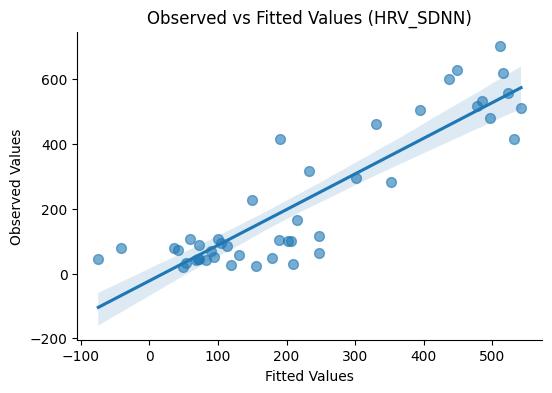

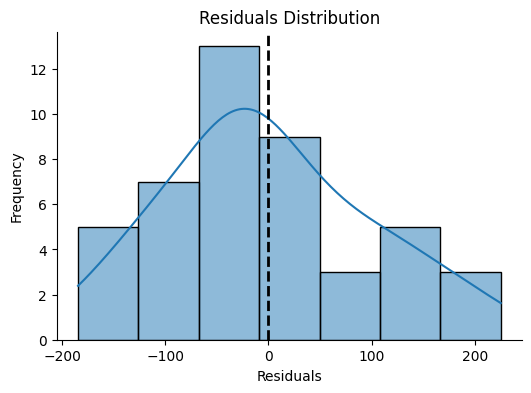

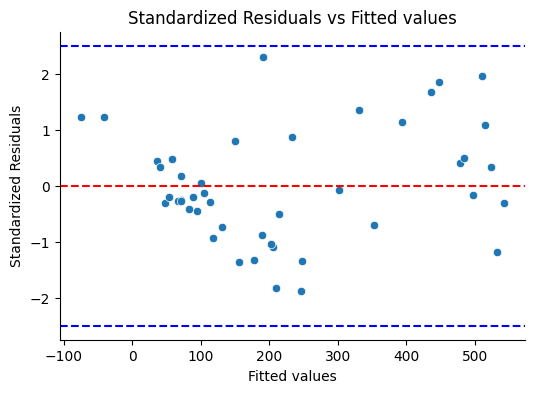

In [ ]:
# Check observed vs fitted, residuals vs frequency, residuals vs fitted plots
visual_check(model_sdnn_iii, dv="HRV_SDNN")

### Model fit

In [ ]:
# Fitting stats and variance partitioning
model_sdnn = model_sdnn_iii.result_fit_stats
model_sdnn_iii.result_fit_stats

shape: (1, 13)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ AIC ‚îÜ AIC ‚îÜ BIC ‚îÜ ICC    ‚îÜ R2_con ‚îÜ R2_ma ‚îÜ REMLc ‚îÜ RMSE  ‚îÜ Sigma ‚îÜ df_re ‚îÜ logLi ‚îÜ nobs ‚îÜ sigma ‚îÇ
‚îÇ --- ‚îÜ c   ‚îÜ --- ‚îÜ ---    ‚îÜ dition ‚îÜ rgina ‚îÜ rit   ‚îÜ ---   ‚îÜ ---   ‚îÜ sidua ‚îÜ k     ‚îÜ ---  ‚îÜ ---   ‚îÇ
‚îÇ f64 ‚îÜ --- ‚îÜ f64 ‚îÜ f64    ‚îÜ al     ‚îÜ l     ‚îÜ ---   ‚îÜ f64   ‚îÜ f64   ‚îÜ l     ‚îÜ ---   ‚îÜ i64  ‚îÜ f64   ‚îÇ
‚îÇ     ‚îÜ f64 ‚îÜ     ‚îÜ        ‚îÜ ---    ‚îÜ ---   ‚îÜ f64   ‚îÜ       ‚îÜ       ‚îÜ ---   ‚îÜ f64   ‚îÜ      ‚îÜ       ‚îÇ
‚îÇ     ‚îÜ     ‚îÜ     ‚îÜ        ‚îÜ f64    ‚îÜ f64   ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ i64   ‚îÜ       ‚îÜ      ‚îÜ       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 516 ‚îÜ 522 ‚îÜ 534 ‚îÜ 0.5810 ‚îÜ 0.7191 ‚îÜ 0.329 ‚îÜ 496.3 ‚îÜ 97.98 ‚îÜ 123.9 ‚îÜ 35    ‚îÜ -248. ‚îÜ 45   ‚îÜ 123.9 ‚îÇ
‚îÇ .34 ‚îÜ .82 ‚îÜ .41 ‚îÜ 56     ‚îÜ 87     ‚îÜ 713   ‚îÜ 49978 ‚îÜ 738   ‚îÜ 31156 ‚îÜ       ‚îÜ 17498 ‚îÜ      ‚îÜ 31156 ‚îÇ
‚îÇ 997 ‚îÜ 056 ‚îÜ 660 ‚îÜ        ‚îÜ        ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ 9     ‚îÜ      ‚îÜ       ‚îÇ
‚îÇ 8   ‚îÜ 6   ‚îÜ 3   ‚îÜ        ‚îÜ        ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ      ‚îÜ       ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [ ]:
# Check multicollinearity
model_sdnn_iii.vif()

shape: (7, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ term                          ‚îÜ vif      ‚îÜ ci_increase_factor ‚îÇ
‚îÇ ---                           ‚îÜ ---      ‚îÜ ---                ‚îÇ
‚îÇ str                           ‚îÜ f64      ‚îÜ f64                ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ groupexp                      ‚îÜ 3.0      ‚îÜ 1.732051           ‚îÇ
‚îÇ sessionResting state          ‚îÜ 2.666667 ‚îÜ 1.632993           ‚îÇ
‚îÇ sessionExam                   ‚îÜ 2.666667 ‚îÜ 1.632993           ‚îÇ
‚îÇ instrument_type1              ‚îÜ 1.0      ‚îÜ 1.0                ‚îÇ
‚îÇ gender2                       ‚îÜ 1.0      ‚îÜ 1.0                ‚îÇ
‚îÇ groupexp:sessionResting state ‚îÜ 3.333333 ‚îÜ 1.825742           ‚îÇ
‚îÇ groupexp:sessionExam          ‚îÜ 3.333333 ‚îÜ 1.825742           ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

### Post-hoc tests

In [ ]:
model_sdnn_iii.summary(pretty=True)

GT(_tbl_data=shape: (12, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ rfx      ‚îÜ param   ‚îÜ estimat ‚îÜ std_err ‚îÜ conf_lo ‚îÜ conf_hi ‚îÜ t_stat  ‚îÜ df      ‚îÜ p_value ‚îÜ stars ‚îÇ
‚îÇ ---      ‚îÜ ---     ‚îÜ e       ‚îÜ or      ‚îÜ w       ‚îÜ gh      ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---   ‚îÇ
‚îÇ str      ‚îÜ str     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ f64     ‚îÜ f64     ‚îÜ str     ‚îÜ str   ‚îÇ
‚îÇ          ‚îÜ         ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ ID-sd    ‚îÜ (Interc ‚îÜ 145.952 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ 379     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ Residual ‚îÜ Observa ‚îÜ 123.931 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ -sd      ‚îÜ tion    ‚îÜ 156     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Fixed    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Effects: ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ (Interc ‚îÜ 128.362 ‚îÜ 102.268 ‚îÜ -89.054 ‚îÜ 345.778 ‚îÜ 1.25515 ‚îÜ 15.4592 ‚îÜ 0.2281  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ 149     ‚îÜ 028     ‚îÜ 384     ‚îÜ 682     ‚îÜ 4       ‚îÜ 18      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ ‚Ä¶        ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶     ‚îÇ
‚îÇ null     ‚îÜ session ‚îÜ 84.0080 ‚îÜ 71.5516 ‚îÜ -63.068 ‚îÜ 231.084 ‚îÜ 1.17408 ‚îÜ 26.0    ‚îÜ 0.251   ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ Exam    ‚îÜ 55      ‚îÜ 86      ‚îÜ 543     ‚îÜ 652     ‚îÜ 9       ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ instrum ‚îÜ -55.091 ‚îÜ 86.2039 ‚îÜ -244.82 ‚îÜ 134.641 ‚îÜ -0.6390 ‚îÜ 11.0    ‚îÜ 0.5358  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ ent_typ ‚îÜ 69      ‚îÜ 13      ‚îÜ 5224    ‚îÜ 844     ‚îÜ 86      ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ e1      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ gender2 ‚îÜ 239.352 ‚îÜ 89.0310 ‚îÜ 43.3961 ‚îÜ 435.308 ‚îÜ 2.68841 ‚îÜ 11.0    ‚îÜ 0.02109 ‚îÜ *     ‚îÇ
‚îÇ          ‚îÜ         ‚îÜ 103     ‚îÜ 18      ‚îÜ 51      ‚îÜ 054     ‚îÜ 2       ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ 115.219 ‚îÜ 92.3728 ‚îÜ -74.655 ‚îÜ 305.094 ‚îÜ 1.24733 ‚îÜ 26.0    ‚îÜ 0.2234  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p:sessi ‚îÜ 803     ‚îÜ 3       ‚îÜ 267     ‚îÜ 874     ‚îÜ 4       ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ onResti ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ ng      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ state   ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ -102.64 ‚îÜ 92.3728 ‚îÜ -292.51 ‚îÜ 87.2321 ‚îÜ -1.1111 ‚îÜ 26.0    ‚îÜ 0.2767  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p:sessi ‚îÜ

In [ ]:
ph_sdnn = model_sdnn_iii.emmeans("session", contrasts="pairwise", p_adjust='bonf')
ph_sdnn

R messages: 
NOTE: Results may be misleading due to involvement in interactions

R messages: 
NOTE: Results may be misleading due to involvement in interactions



shape: (3, 8)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ contrast      ‚îÜ estimate    ‚îÜ SE        ‚îÜ df   ‚îÜ lower_CL    ‚îÜ upper_CL   ‚îÜ t_ratio   ‚îÜ p_value  ‚îÇ
‚îÇ ---           ‚îÜ ---         ‚îÜ ---       ‚îÜ ---  ‚îÜ ---         ‚îÜ ---        ‚îÜ ---       ‚îÜ ---      ‚îÇ
‚îÇ str           ‚îÜ f64         ‚îÜ f64       ‚îÜ f64  ‚îÜ f64         ‚îÜ f64        ‚îÜ f64       ‚îÜ f64      ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Baseline -    ‚îÜ 88.583157   ‚îÜ 46.186415 ‚îÜ 26.0 ‚îÜ -29.605217  ‚îÜ 206.771532 ‚îÜ 1.917948  ‚îÜ 0.198491 ‚îÇ
‚îÇ Resting state ‚îÜ             ‚îÜ           ‚îÜ      ‚îÜ             ‚îÜ            ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ Baseline -    ‚îÜ -32.686615  ‚îÜ 46.186415 ‚îÜ 26.0 ‚îÜ -150.87499  ‚îÜ 85.501759  ‚îÜ -0.707711 ‚îÜ 1.0      ‚îÇ
‚îÇ Exam          ‚îÜ             ‚îÜ           ‚îÜ      ‚îÜ             ‚îÜ            ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ Resting state ‚îÜ -121.269773 ‚îÜ 46.186415 ‚îÜ 26.0 ‚îÜ -239.458147 ‚îÜ -3.081398  ‚îÜ -2.625659 ‚îÜ 0.042894 ‚îÇ
‚îÇ - Exam        ‚îÜ             ‚îÜ           ‚îÜ      ‚îÜ             ‚îÜ            ‚îÜ           ‚îÜ          ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [ ]:
model_sdnn_iii.report()

We fitted a linear mixed model (estimated using REML and nloptwrap optimizer)
to predict HRV_SDNN with group, session, instrument_type and gender (formula:
HRV_SDNN ~ group * session + instrument_type + gender). The model included ID
as random effect (formula: ~1 | ID). The model's total explanatory power is
substantial (conditional R2 = 0.72) and the part related to the fixed effects
alone (marginal R2) is of 0.33. The model's intercept, corresponding to group =
ctr, session = Baseline, instrument_type = 2 and gender = 1, is at 128.36 (95%
CI [-79.25, 335.98], t(35) = 1.26, p = 0.218). Within this model:

  - The effect of group [exp] is statistically non-significant and negative (beta
= -42.15, 95% CI [-247.94, 163.64], t(35) = -0.42, p = 0.680; Std. beta =
-0.19, 95% CI [-1.14, 0.76])
  - The effect of session [Resting state] is statistically significant and
negative (beta = -146.19, 95% CI [-291.45, -0.94], t(35) = -2.04, p = 0.049;
Std. beta = -0.67, 95% CI [-1.35, -4.32e-03])
  -

## SD1/SD2

### Modeling

In [ ]:
sd1sd2_df = filter_df_for_dv(hrv_data, "HRV_SD1SD2")

In [ ]:
model_sd1sd2_i = lmer("HRV_SD1SD2 ~ group * session + (1 | ID)",
               data=sd1sd2_df)

# Set reference
set_factors(model_sd1sd2_i)

model_sd1sd2_i.fit(summary=True)

GT(_tbl_data=shape: (10, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ rfx      ‚îÜ param   ‚îÜ estimat ‚îÜ std_err ‚îÜ conf_lo ‚îÜ conf_hi ‚îÜ t_stat  ‚îÜ df      ‚îÜ p_value ‚îÜ stars ‚îÇ
‚îÇ ---      ‚îÜ ---     ‚îÜ e       ‚îÜ or      ‚îÜ w       ‚îÜ gh      ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---   ‚îÇ
‚îÇ str      ‚îÜ str     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ f64     ‚îÜ f64     ‚îÜ str     ‚îÜ str   ‚îÇ
‚îÇ          ‚îÜ         ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ ID-sd    ‚îÜ (Interc ‚îÜ 0.22427 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ 4       ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ Residual ‚îÜ Observa ‚îÜ 0.16316 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ -sd      ‚îÜ tion    ‚îÜ 2       ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Fixed    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Effects: ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ (Interc ‚îÜ 0.51034 ‚îÜ 0.11322 ‚îÜ 0.27489 ‚îÜ 0.7458  ‚îÜ 4.50736 ‚îÜ 21.0221 ‚îÜ <.001   ‚îÜ ***   ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ 9       ‚îÜ 6       ‚îÜ 9       ‚îÜ         ‚îÜ         ‚îÜ 39      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ -0.0313 ‚îÜ 0.14617 ‚îÜ -0.3353 ‚îÜ 0.27262 ‚îÜ -0.2144 ‚îÜ 21.0221 ‚îÜ 0.8323  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p       ‚îÜ 44      ‚îÜ 4       ‚îÜ 09      ‚îÜ 2       ‚îÜ 27      ‚îÜ 39      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ session ‚îÜ -0.0088 ‚îÜ 0.09420 ‚îÜ -0.2025 ‚îÜ 0.18475 ‚îÜ -0.0942 ‚îÜ 26.0000 ‚îÜ 0.9256  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ Resting ‚îÜ 81      ‚îÜ 1       ‚îÜ 15      ‚îÜ 3       ‚îÜ 76      ‚îÜ 02      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ state   ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ session ‚îÜ 0.13840 ‚îÜ 0.09420 ‚îÜ -0.0552 ‚îÜ 0.33203 ‚îÜ 1.46924 ‚îÜ 26.0000 ‚îÜ 0.1538  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ Exam    ‚îÜ 5       ‚îÜ 1       ‚îÜ 29      ‚îÜ 9       ‚îÜ 8       ‚îÜ 02      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ -0.0529 ‚îÜ 0.12161 ‚îÜ -0.3028 ‚îÜ 0.19706 ‚îÜ -0.4350 ‚îÜ 26.0000 ‚îÜ 0.6671  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p:sessi ‚îÜ 11      ‚îÜ 3       ‚îÜ 91      ‚îÜ 9       ‚îÜ 73      ‚îÜ 02      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ onResti ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ ng      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ state   ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ -0.0928 ‚îÜ 0.12161 ‚îÜ -0.3427 ‚îÜ 0.15716 ‚îÜ -0.7632 ‚îÜ 26.0000 ‚îÜ 0.4522  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p:sessi ‚îÜ 17      ‚îÜ 3       ‚îÜ 97      ‚îÜ 3       ‚îÜ 14      ‚îÜ 02      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ onExam  ‚îÜ         ‚îÜ        

In [ ]:
model_sd1sd2_ii = lmer("HRV_SD1SD2 ~ group * session + instrument_type + (1 | ID)",
               data=sd1sd2_df)

# Set reference
set_factors(model_sd1sd2_ii)

model_sd1sd2_ii.fit(summary=True)

GT(_tbl_data=shape: (11, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ rfx      ‚îÜ param   ‚îÜ estimat ‚îÜ std_err ‚îÜ conf_lo ‚îÜ conf_hi ‚îÜ t_stat  ‚îÜ df      ‚îÜ p_value ‚îÜ stars ‚îÇ
‚îÇ ---      ‚îÜ ---     ‚îÜ e       ‚îÜ or      ‚îÜ w       ‚îÜ gh      ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---   ‚îÇ
‚îÇ str      ‚îÜ str     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ f64     ‚îÜ f64     ‚îÜ str     ‚îÜ str   ‚îÇ
‚îÇ          ‚îÜ         ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ ID-sd    ‚îÜ (Interc ‚îÜ 0.22522 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ 2       ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ Residual ‚îÜ Observa ‚îÜ 0.16316 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ -sd      ‚îÜ tion    ‚îÜ 2       ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Fixed    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Effects: ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ (Interc ‚îÜ 0.55145 ‚îÜ 0.12146 ‚îÜ 0.29650 ‚îÜ 0.80639 ‚îÜ 4.54002 ‚îÜ 18.2435 ‚îÜ <.001   ‚îÜ ***   ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ 1       ‚îÜ 4       ‚îÜ 8       ‚îÜ 4       ‚îÜ 9       ‚îÜ 75      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ ‚Ä¶        ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶     ‚îÇ
‚îÇ null     ‚îÜ session ‚îÜ -0.0088 ‚îÜ 0.09420 ‚îÜ -0.2025 ‚îÜ 0.18475 ‚îÜ -0.0942 ‚îÜ 26.0    ‚îÜ 0.9256  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ Resting ‚îÜ 81      ‚îÜ 1       ‚îÜ 15      ‚îÜ 3       ‚îÜ 76      ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ state   ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ session ‚îÜ 0.13840 ‚îÜ 0.09420 ‚îÜ -0.0552 ‚îÜ 0.33203 ‚îÜ 1.46924 ‚îÜ 26.0    ‚îÜ 0.1538  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ Exam    ‚îÜ 5       ‚îÜ 1       ‚îÜ 29      ‚îÜ 9       ‚îÜ 8       ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ instrum ‚îÜ -0.1233 ‚îÜ 0.12946 ‚îÜ -0.4053 ‚îÜ 0.15878 ‚îÜ -0.9523 ‚îÜ 11.9999 ‚îÜ 0.3597  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ ent_typ ‚îÜ 05      ‚îÜ 9       ‚îÜ 93      ‚îÜ 3       ‚îÜ 94      ‚îÜ 99      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ e1      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ -0.0529 ‚îÜ 0.12161 ‚îÜ -0.3028 ‚îÜ 0.19706 ‚îÜ -0.4350 ‚îÜ 26.0    ‚îÜ 0.6671  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p:sessi ‚îÜ 11      ‚îÜ 3       ‚îÜ 91      ‚îÜ 9       ‚îÜ 73      ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ onResti ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ ng      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ state   ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ

In [ ]:
model_sd1sd2_iii = lmer("HRV_SD1SD2 ~ group * session + instrument_type + gender + (1 | ID)",
               data=sd1sd2_df)

# Set reference
set_factors(model_sd1sd2_iii)

model_sd1sd2_iii.fit(summary=True)

GT(_tbl_data=shape: (12, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ rfx      ‚îÜ param   ‚îÜ estimat ‚îÜ std_err ‚îÜ conf_lo ‚îÜ conf_hi ‚îÜ t_stat  ‚îÜ df      ‚îÜ p_value ‚îÜ stars ‚îÇ
‚îÇ ---      ‚îÜ ---     ‚îÜ e       ‚îÜ or      ‚îÜ w       ‚îÜ gh      ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---   ‚îÇ
‚îÇ str      ‚îÜ str     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ f64     ‚îÜ f64     ‚îÜ str     ‚îÜ str   ‚îÇ
‚îÇ          ‚îÜ         ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ ID-sd    ‚îÜ (Interc ‚îÜ 0.14522 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ 2       ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ Residual ‚îÜ Observa ‚îÜ 0.16316 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ -sd      ‚îÜ tion    ‚îÜ 2       ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Fixed    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Effects: ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ (Interc ‚îÜ 0.32470 ‚îÜ 0.11350 ‚îÜ 0.08611 ‚îÜ 0.56330 ‚îÜ 2.86075 ‚îÜ 17.8622 ‚îÜ 0.01045 ‚îÜ *     ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ 9       ‚îÜ 5       ‚îÜ 3       ‚îÜ 6       ‚îÜ 7       ‚îÜ 64      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ ‚Ä¶        ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶     ‚îÇ
‚îÇ null     ‚îÜ session ‚îÜ 0.13840 ‚îÜ 0.09420 ‚îÜ -0.0552 ‚îÜ 0.33203 ‚îÜ 1.46924 ‚îÜ 26.0    ‚îÜ 0.1538  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ Exam    ‚îÜ 5       ‚îÜ 1       ‚îÜ 29      ‚îÜ 9       ‚îÜ 8       ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ instrum ‚îÜ -0.1233 ‚îÜ 0.0918  ‚îÜ -0.3253 ‚îÜ 0.07874 ‚îÜ -1.3432 ‚îÜ 10.9999 ‚îÜ 0.2063  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ ent_typ ‚îÜ 05      ‚îÜ         ‚îÜ 55      ‚îÜ 4       ‚îÜ         ‚îÜ 99      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ e1      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ gender2 ‚îÜ 0.34011 ‚îÜ 0.09481 ‚îÜ 0.13143 ‚îÜ 0.54878 ‚îÜ 3.58729 ‚îÜ 10.9999 ‚îÜ 0.00426 ‚îÜ **    ‚îÇ
‚îÇ          ‚îÜ         ‚îÜ 3       ‚îÜ         ‚îÜ 7       ‚îÜ 9       ‚îÜ 8       ‚îÜ 99      ‚îÜ 4       ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ -0.0529 ‚îÜ 0.12161 ‚îÜ -0.3028 ‚îÜ 0.19706 ‚îÜ -0.4350 ‚îÜ 26.0    ‚îÜ 0.6671  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p:sessi ‚îÜ 11      ‚îÜ 3       ‚îÜ 91      ‚îÜ 9       ‚îÜ 73      ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ onResti ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ ng      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ state   ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ -0.0928 ‚îÜ 0.12161 ‚îÜ -0.3427 ‚îÜ 0.15716 ‚îÜ -0.7632 ‚îÜ 26.0    ‚îÜ 0.4522  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p:sessi ‚îÜ

In [ ]:
compare(model_sd1sd2_i, model_sd1sd2_ii, model_sd1sd2_iii)

GT(_tbl_data=shape: (3, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ AIC       ‚îÜ BIC       ‚îÜ logLik    ‚îÜ npar ‚îÜ -2*log(L) ‚îÜ Chisq     ‚îÜ Df  ‚îÜ Pr(>Chisq ‚îÜ stars ‚îÜ ids ‚îÇ
‚îÇ ---       ‚îÜ ---       ‚îÜ ---       ‚îÜ ---  ‚îÜ ---       ‚îÜ ---       ‚îÜ --- ‚îÜ )         ‚îÜ ---   ‚îÜ --- ‚îÇ
‚îÇ f64       ‚îÜ f64       ‚îÜ f64       ‚îÜ i64  ‚îÜ f64       ‚îÜ f64       ‚îÜ f64 ‚îÜ ---       ‚îÜ str   ‚îÜ i64 ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ      ‚îÜ           ‚îÜ           ‚îÜ     ‚îÜ str       ‚îÜ       ‚îÜ     ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 21.894542 ‚îÜ 36.347842 ‚îÜ -2.947271 ‚îÜ 8    ‚îÜ -13.44616 ‚îÜ 0.0       ‚îÜ 0.0 ‚îÜ           ‚îÜ       ‚îÜ 1   ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ      ‚îÜ 5         ‚îÜ           ‚îÜ     ‚îÜ           ‚îÜ       ‚îÜ     ‚îÇ
‚îÇ 25.238576 ‚îÜ 41.498538 ‚îÜ -3.619288 ‚îÜ 9    ‚îÜ -14.53917 ‚îÜ 1.093011  ‚îÜ 1.0 ‚îÜ 0.296     ‚îÜ       ‚îÜ 2   ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ      ‚îÜ 6         ‚îÜ           ‚îÜ     ‚îÜ           ‚îÜ       ‚îÜ     ‚îÇ
‚îÇ 20.860512 ‚îÜ 38.927137 ‚îÜ -0.430256 ‚îÜ 10   ‚îÜ -26.15927 ‚îÜ 11.620097 ‚îÜ 1.0 ‚îÜ <.001     ‚îÜ ***   ‚îÜ 3   ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ      ‚îÜ 3         ‚îÜ           ‚îÜ     ‚îÜ           ‚îÜ       ‚îÜ     ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò, _body=<great_tables._gt_data.Body object at 0x7b2a163c9dd0>, _boxhead=Boxhead([ColInfo(var='ids', type=<ColInfoTypeEnum.stub: 2>, column_label='', column_align='right', column_width=None), ColInfo(var='AIC', type=<ColInfoTypeEnum.default: 1>, column_label='AIC', column_align='right', column_width=None), ColInfo(var='BIC', type=<ColInfoTypeEnum.default: 1>, column_label='BIC', column_align='right', column_width=None), ColInfo(var='logLik', type=<ColInfoTypeEnum.default: 1>, column_label='logLik', column_align='right', column_width=None), ColInfo(var='npar', type=<ColInfoTypeEnum.default: 1>, column_label='npar', column_align='right', column_width=None), ColInfo(var='-2*log(L)', type=<ColInfoTypeEnum.default: 1>, column_label='-2*log(L)', column_align='right', column_width=None), ColInfo(var='Chisq', type=<ColInfoTypeEnum.default: 1>, column_label='Chisq', column_align='right', column_width=None), ColInfo(var='Df', type=<ColInfoTypeEnum.default: 1>, column_label='Df', column_align='right', column_width=None), ColInfo(var='Pr(>Chisq)', type=<ColInfoTypeEnum.default: 1>, column_label='Pr(>Chisq)', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7b2a163d7750>, _spanners=Spanners([]), _heading=Heading(title='Analysis of Deviance Table', subtitle=Md(text='Model 1: lmer(HRV_SD1SD2~group*session+(1|ID))   \nModel 2: lmer(HRV_SD1SD2~group*session+instrument_type+(1|ID))   \nModel 3: lmer(HRV_SD1SD2~group*session+instrument_type+gender+(1|ID))   \n'), preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7b2a163a8d50>, _formats=[<grea

Only the gender is significant

### Assumptions

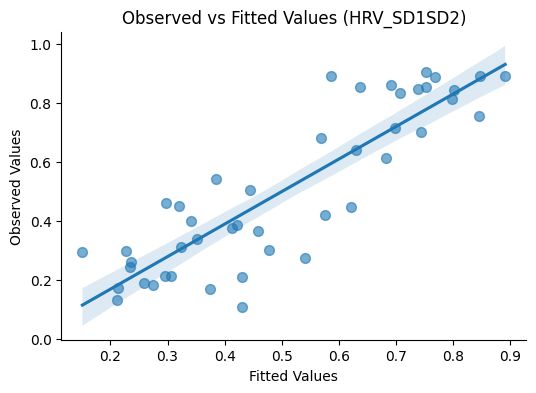

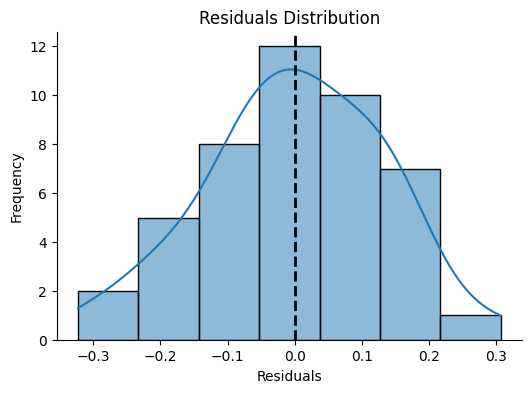

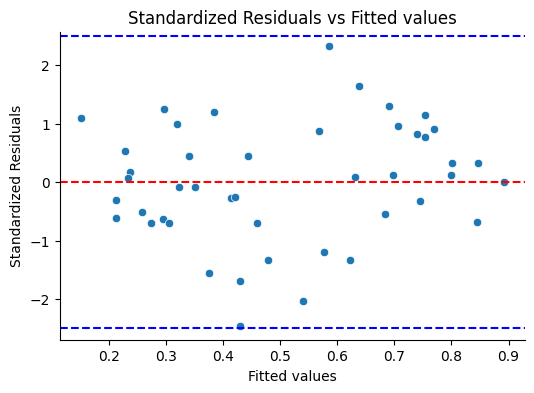

In [ ]:
# Check observed vs fitted, residuals vs frequency, residuals vs fitted plots
visual_check(model_sd1sd2_iii, dv="HRV_SD1SD2")

### Model fit

In [ ]:
# Fitting stats and variance partitioning
model_sd1sd2 = model_sdnn_iii.result_fit_stats
model_sd1sd2_iii.result_fit_stats

shape: (1, 13)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ AIC ‚îÜ AIC ‚îÜ BIC ‚îÜ ICC    ‚îÜ R2_con ‚îÜ R2_ma ‚îÜ REMLc ‚îÜ RMSE  ‚îÜ Sigma ‚îÜ df_re ‚îÜ logLi ‚îÜ nobs ‚îÜ sigma ‚îÇ
‚îÇ --- ‚îÜ c   ‚îÜ --- ‚îÜ ---    ‚îÜ dition ‚îÜ rgina ‚îÜ rit   ‚îÜ ---   ‚îÜ ---   ‚îÜ sidua ‚îÜ k     ‚îÜ ---  ‚îÜ ---   ‚îÇ
‚îÇ f64 ‚îÜ --- ‚îÜ f64 ‚îÜ f64    ‚îÜ al     ‚îÜ l     ‚îÜ ---   ‚îÜ f64   ‚îÜ f64   ‚îÜ l     ‚îÜ ---   ‚îÜ i64  ‚îÜ f64   ‚îÇ
‚îÇ     ‚îÜ f64 ‚îÜ     ‚îÜ        ‚îÜ ---    ‚îÜ ---   ‚îÜ f64   ‚îÜ       ‚îÜ       ‚îÜ ---   ‚îÜ f64   ‚îÜ      ‚îÜ       ‚îÇ
‚îÇ     ‚îÜ     ‚îÜ     ‚îÜ        ‚îÜ f64    ‚îÜ f64   ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ i64   ‚îÜ       ‚îÜ      ‚îÜ       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 20. ‚îÜ 27. ‚îÜ 38. ‚îÜ 0.4420 ‚îÜ 0.6765 ‚îÜ 0.420 ‚îÜ 0.860 ‚îÜ 0.131 ‚îÜ 0.163 ‚îÜ 35    ‚îÜ -0.43 ‚îÜ 45   ‚îÜ 0.163 ‚îÇ
‚îÇ 860 ‚îÜ 331 ‚îÜ 927 ‚îÜ 23     ‚îÜ 42     ‚îÜ 302   ‚îÜ 512   ‚îÜ 563   ‚îÜ 162   ‚îÜ       ‚îÜ 0256  ‚îÜ      ‚îÜ 162   ‚îÇ
‚îÇ 512 ‚îÜ 1   ‚îÜ 137 ‚îÜ        ‚îÜ        ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ      ‚îÜ       ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [ ]:
# Check multicollinearity
model_sd1sd2_iii.vif()

shape: (7, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ term                          ‚îÜ vif      ‚îÜ ci_increase_factor ‚îÇ
‚îÇ ---                           ‚îÜ ---      ‚îÜ ---                ‚îÇ
‚îÇ str                           ‚îÜ f64      ‚îÜ f64                ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ groupexp                      ‚îÜ 3.0      ‚îÜ 1.732051           ‚îÇ
‚îÇ sessionResting state          ‚îÜ 2.666667 ‚îÜ 1.632993           ‚îÇ
‚îÇ sessionExam                   ‚îÜ 2.666667 ‚îÜ 1.632993           ‚îÇ
‚îÇ instrument_type1              ‚îÜ 1.0      ‚îÜ 1.0                ‚îÇ
‚îÇ gender2                       ‚îÜ 1.0      ‚îÜ 1.0                ‚îÇ
‚îÇ groupexp:sessionResting state ‚îÜ 3.333333 ‚îÜ 1.825742           ‚îÇ
‚îÇ groupexp:sessionExam          ‚îÜ 3.333333 ‚îÜ 1.825742           ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

### Post-hoc tests

In [ ]:
model_sd1sd2_iii.summary(pretty=True)

GT(_tbl_data=shape: (12, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ rfx      ‚îÜ param   ‚îÜ estimat ‚îÜ std_err ‚îÜ conf_lo ‚îÜ conf_hi ‚îÜ t_stat  ‚îÜ df      ‚îÜ p_value ‚îÜ stars ‚îÇ
‚îÇ ---      ‚îÜ ---     ‚îÜ e       ‚îÜ or      ‚îÜ w       ‚îÜ gh      ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---   ‚îÇ
‚îÇ str      ‚îÜ str     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ f64     ‚îÜ f64     ‚îÜ str     ‚îÜ str   ‚îÇ
‚îÇ          ‚îÜ         ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ ID-sd    ‚îÜ (Interc ‚îÜ 0.14522 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ 2       ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ Residual ‚îÜ Observa ‚îÜ 0.16316 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ -sd      ‚îÜ tion    ‚îÜ 2       ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Fixed    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Effects: ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ (Interc ‚îÜ 0.32470 ‚îÜ 0.11350 ‚îÜ 0.08611 ‚îÜ 0.56330 ‚îÜ 2.86075 ‚îÜ 17.8622 ‚îÜ 0.01045 ‚îÜ *     ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ 9       ‚îÜ 5       ‚îÜ 3       ‚îÜ 6       ‚îÜ 7       ‚îÜ 64      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ ‚Ä¶        ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶     ‚îÇ
‚îÇ null     ‚îÜ session ‚îÜ 0.13840 ‚îÜ 0.09420 ‚îÜ -0.0552 ‚îÜ 0.33203 ‚îÜ 1.46924 ‚îÜ 26.0    ‚îÜ 0.1538  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ Exam    ‚îÜ 5       ‚îÜ 1       ‚îÜ 29      ‚îÜ 9       ‚îÜ 8       ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ instrum ‚îÜ -0.1233 ‚îÜ 0.0918  ‚îÜ -0.3253 ‚îÜ 0.07874 ‚îÜ -1.3432 ‚îÜ 10.9999 ‚îÜ 0.2063  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ ent_typ ‚îÜ 05      ‚îÜ         ‚îÜ 55      ‚îÜ 4       ‚îÜ         ‚îÜ 99      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ e1      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ gender2 ‚îÜ 0.34011 ‚îÜ 0.09481 ‚îÜ 0.13143 ‚îÜ 0.54878 ‚îÜ 3.58729 ‚îÜ 10.9999 ‚îÜ 0.00426 ‚îÜ **    ‚îÇ
‚îÇ          ‚îÜ         ‚îÜ 3       ‚îÜ         ‚îÜ 7       ‚îÜ 9       ‚îÜ 8       ‚îÜ 99      ‚îÜ 4       ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ -0.0529 ‚îÜ 0.12161 ‚îÜ -0.3028 ‚îÜ 0.19706 ‚îÜ -0.4350 ‚îÜ 26.0    ‚îÜ 0.6671  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p:sessi ‚îÜ 11      ‚îÜ 3       ‚îÜ 91      ‚îÜ 9       ‚îÜ 73      ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ onResti ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ ng      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ state   ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ -0.0928 ‚îÜ 0.12161 ‚îÜ -0.3427 ‚îÜ 0.15716 ‚îÜ -0.7632 ‚îÜ 26.0    ‚îÜ 0.4522  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p:sessi ‚îÜ

Only gender has a significant main effect --> post-hoc is the output of model summary

In [ ]:
model_sd1sd2_iii.report()

We fitted a linear mixed model (estimated using REML and nloptwrap optimizer)
to predict HRV_SD1SD2 with group, session, instrument_type and gender (formula:
HRV_SD1SD2 ~ group * session + instrument_type + gender). The model included ID
as random effect (formula: ~1 | ID). The model's total explanatory power is
substantial (conditional R2 = 0.68) and the part related to the fixed effects
alone (marginal R2) is of 0.42. The model's intercept, corresponding to group =
ctr, session = Baseline, instrument_type = 2 and gender = 1, is at 0.32 (95% CI
[0.09, 0.56], t(35) = 2.86, p = 0.007). Within this model:

  - The effect of group [exp] is statistically non-significant and negative (beta
= -0.02, 95% CI [-0.25, 0.22], t(35) = -0.15, p = 0.880; Std. beta = -0.07, 95%
CI [-0.93, 0.80])
  - The effect of session [Resting state] is statistically non-significant and
negative (beta = -8.88e-03, 95% CI [-0.20, 0.18], t(35) = -0.09, p = 0.925;
Std. beta = -0.03, 95% CI [-0.74, 0.68])
  - The effe

## HRV LFHF

### Modeling

In [ ]:
hrv_lfhf_df = filter_df_for_dv(hrv_data, "HRV_LFHF")

In [ ]:
model_hrv_lfhf_i = lmer("HRV_LFHF ~ group * session + (1 | ID)",
               data=hrv_lfhf_df)

# Set reference
set_factors(model_hrv_lfhf_i)

model_hrv_lfhf_i.fit(summary=False)

In [ ]:
model_hrv_lfhf_ii = lmer("HRV_LFHF ~ group * session + instrument_type + (1 | ID)",
               data=hrv_lfhf_df)

# Set reference
set_factors(model_hrv_lfhf_ii)

model_hrv_lfhf_ii.fit(summary=False)

In [ ]:
model_hrv_lfhf_iii = lmer("HRV_LFHF ~ group * session + instrument_type + gender + (1 | ID)",
               data=hrv_lfhf_df)

# Set reference
set_factors(model_hrv_lfhf_iii)

model_hrv_lfhf_iii.fit(summary=True)

R messages: 
boundary (singular) fit: see help('isSingular')

Random effect variances not available. Returned R2 does not account for random effects.

R messages: 
boundary (singular) fit: see help('isSingular')

Random effect variances not available. Returned R2 does not account for random effects.



GT(_tbl_data=shape: (12, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ rfx      ‚îÜ param    ‚îÜ estimate ‚îÜ std_erro ‚îÜ conf_lo ‚îÜ conf_hi ‚îÜ t_stat  ‚îÜ df   ‚îÜ p_value ‚îÜ stars ‚îÇ
‚îÇ ---      ‚îÜ ---      ‚îÜ ---      ‚îÜ r        ‚îÜ w       ‚îÜ gh      ‚îÜ ---     ‚îÜ ---  ‚îÜ ---     ‚îÜ ---   ‚îÇ
‚îÇ str      ‚îÜ str      ‚îÜ f64      ‚îÜ ---      ‚îÜ ---     ‚îÜ ---     ‚îÜ f64     ‚îÜ f64  ‚îÜ str     ‚îÜ str   ‚îÇ
‚îÇ          ‚îÜ          ‚îÜ          ‚îÜ f64      ‚îÜ f64     ‚îÜ f64     ‚îÜ         ‚îÜ      ‚îÜ         ‚îÜ       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ ID-sd    ‚îÜ (Interce ‚îÜ 0.0      ‚îÜ null     ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ          ‚îÜ pt)      ‚îÜ          ‚îÜ          ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ Residual ‚îÜ Observat ‚îÜ 2.175572 ‚îÜ null     ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ -sd      ‚îÜ ion      ‚îÜ          ‚îÜ          ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ null     ‚îÜ null     ‚îÜ null     ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Fixed    ‚îÜ null     ‚îÜ null     ‚îÜ null     ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Effects: ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ (Interce ‚îÜ 4.768501 ‚îÜ 1.023971 ‚îÜ 2.69374 ‚îÜ 6.84326 ‚îÜ 4.65687 ‚îÜ 37.0 ‚îÜ <.001   ‚îÜ ***   ‚îÇ
‚îÇ          ‚îÜ pt)      ‚îÜ          ‚îÜ          ‚îÜ         ‚îÜ 3       ‚îÜ 3       ‚îÜ      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ ‚Ä¶        ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶    ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶     ‚îÇ
‚îÇ null     ‚îÜ sessionE ‚îÜ -2.04240 ‚îÜ 1.256067 ‚îÜ -4.5874 ‚îÜ 0.50263 ‚îÜ -1.6260 ‚îÜ 37.0 ‚îÜ 0.1124  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ xam      ‚îÜ 2        ‚îÜ          ‚îÜ 36      ‚îÜ 1       ‚îÜ 3       ‚îÜ      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ instrume ‚îÜ 1.367679 ‚îÜ 0.66613  ‚îÜ 0.01797 ‚îÜ 2.71738 ‚îÜ 2.05317 ‚îÜ 37.0 ‚îÜ 0.04718 ‚îÜ *     ‚îÇ
‚îÇ          ‚îÜ nt_type1 ‚îÜ          ‚îÜ          ‚îÜ 2       ‚îÜ 7       ‚îÜ 2       ‚îÜ      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ gender2  ‚îÜ -2.15660 ‚îÜ 0.687976 ‚îÜ -3.5505 ‚îÜ -0.7626 ‚îÜ -3.1347 ‚îÜ 37.0 ‚îÜ 0.00336 ‚îÜ **    ‚îÇ
‚îÇ          ‚îÜ          ‚îÜ 3        ‚îÜ          ‚îÜ 75      ‚îÜ 3       ‚îÜ 05      ‚îÜ      ‚îÜ 2       ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupexp ‚îÜ 1.270944 ‚îÜ 1.621575 ‚îÜ -2.0146 ‚îÜ 4.55656 ‚îÜ 0.78377 ‚îÜ 37.0 ‚îÜ 0.4382  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ :session ‚îÜ          ‚îÜ          ‚îÜ 8       ‚îÜ 8       ‚îÜ 1       ‚îÜ      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ Resting  ‚îÜ          ‚îÜ          ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ state    ‚îÜ          ‚îÜ          ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupexp ‚îÜ 1.257885 ‚îÜ 1.621575 ‚îÜ -2.0277 ‚îÜ 4.54350 ‚îÜ 0.77571 ‚îÜ 37.0 ‚îÜ 0.4428  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ :session ‚îÜ          ‚îÜ          ‚îÜ 39      ‚îÜ 9       ‚îÜ 8       ‚îÜ      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ Exam     ‚îÜ          ‚îÜ          ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ      ‚îÜ         ‚îÜ       ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚

Last model with gender has singularity issues: random effects cannot be estimated --> last working model to interpret: model_hrv_sd1sd2_ii

In [ ]:
compare(model_hrv_lfhf_i, model_hrv_lfhf_ii)

GT(_tbl_data=shape: (2, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ AIC        ‚îÜ BIC       ‚îÜ logLik    ‚îÜ npar ‚îÜ -2*log(L) ‚îÜ Chisq    ‚îÜ Df  ‚îÜ Pr(>Chisq ‚îÜ stars ‚îÜ ids ‚îÇ
‚îÇ ---        ‚îÜ ---       ‚îÜ ---       ‚îÜ ---  ‚îÜ ---       ‚îÜ ---      ‚îÜ --- ‚îÜ )         ‚îÜ ---   ‚îÜ --- ‚îÇ
‚îÇ f64        ‚îÜ f64       ‚îÜ f64       ‚îÜ i64  ‚îÜ f64       ‚îÜ f64      ‚îÜ f64 ‚îÜ ---       ‚îÜ str   ‚îÜ i64 ‚îÇ
‚îÇ            ‚îÜ           ‚îÜ           ‚îÜ      ‚îÜ           ‚îÜ          ‚îÜ     ‚îÜ str       ‚îÜ       ‚îÜ     ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 209.25694  ‚îÜ 223.71024 ‚îÜ -96.62847 ‚îÜ 8    ‚îÜ 202.74121 ‚îÜ 0.0      ‚îÜ 0.0 ‚îÜ           ‚îÜ       ‚îÜ 1   ‚îÇ
‚îÇ            ‚îÜ           ‚îÜ           ‚îÜ      ‚îÜ 7         ‚îÜ          ‚îÜ     ‚îÜ           ‚îÜ       ‚îÜ     ‚îÇ
‚îÇ 207.026562 ‚îÜ 223.28652 ‚îÜ -94.51328 ‚îÜ 9    ‚îÜ 199.38549 ‚îÜ 3.355718 ‚îÜ 1.0 ‚îÜ 0.067     ‚îÜ .     ‚îÜ 2   ‚îÇ
‚îÇ            ‚îÜ 4         ‚îÜ 1         ‚îÜ      ‚îÜ 8         ‚îÜ          ‚îÜ     ‚îÜ           ‚îÜ       ‚îÜ     ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò, _body=<great_tables._gt_data.Body object at 0x7b2a16534e50>, _boxhead=Boxhead([ColInfo(var='ids', type=<ColInfoTypeEnum.stub: 2>, column_label='', column_align='right', column_width=None), ColInfo(var='AIC', type=<ColInfoTypeEnum.default: 1>, column_label='AIC', column_align='right', column_width=None), ColInfo(var='BIC', type=<ColInfoTypeEnum.default: 1>, column_label='BIC', column_align='right', column_width=None), ColInfo(var='logLik', type=<ColInfoTypeEnum.default: 1>, column_label='logLik', column_align='right', column_width=None), ColInfo(var='npar', type=<ColInfoTypeEnum.default: 1>, column_label='npar', column_align='right', column_width=None), ColInfo(var='-2*log(L)', type=<ColInfoTypeEnum.default: 1>, column_label='-2*log(L)', column_align='right', column_width=None), ColInfo(var='Chisq', type=<ColInfoTypeEnum.default: 1>, column_label='Chisq', column_align='right', column_width=None), ColInfo(var='Df', type=<ColInfoTypeEnum.default: 1>, column_label='Df', column_align='right', column_width=None), ColInfo(var='Pr(>Chisq)', type=<ColInfoTypeEnum.default: 1>, column_label='Pr(>Chisq)', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7b2a165d3390>, _spanners=Spanners([]), _heading=Heading(title='Analysis of Deviance Table', subtitle=Md(text='Model 1: lmer(HRV_LFHF~group*session+(1|ID))   \nModel 2: lmer(HRV_LFHF~group*session+instrument_type+(1|ID))   \n'), preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7b2a164cbbd0>, _formats=[<great_tables._gt_data.FormatInfo object at 0x7b2a163d6a90>, <great_tables._gt_data.FormatInfo object at 0x7b2a165e51d0>], _substitutions=[<great_tables._gt_data.FormatInfo object at 0x7b2a165d2dd0>], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=Fa

### Assumptions

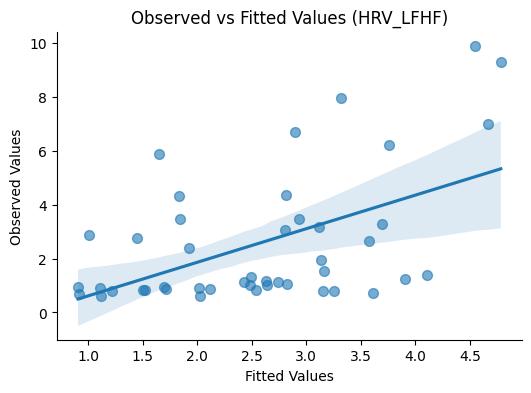

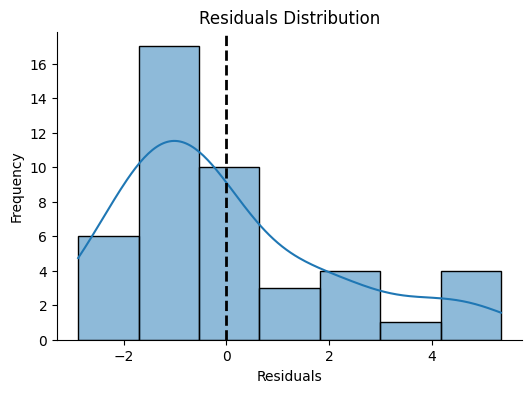

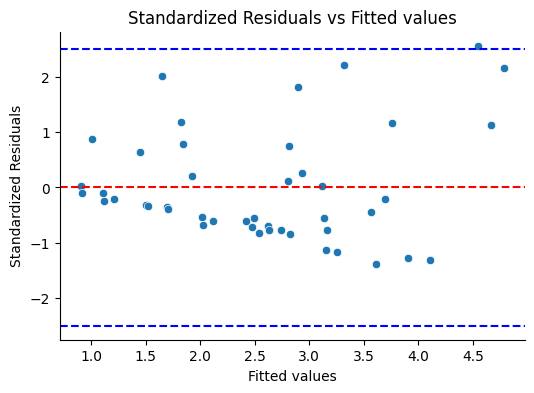

In [ ]:
# Check observed vs fitted, residuals vs frequency, residuals vs fitted plots
visual_check(model_hrv_lfhf_ii, dv="HRV_LFHF")

In [ ]:
# Reject outliers
hrv_lfhf_df_cleaned = reject_outliers(model_hrv_lfhf_ii)

# Refit the model
model_hrv_lfhf_ii_cleaned = lmer("HRV_LFHF ~ group * session + instrument_type + (1 | ID)",
               data=hrv_lfhf_df_cleaned)

# Set reference
set_factors(model_hrv_lfhf_ii_cleaned)

model_hrv_lfhf_ii_cleaned.fit(summary=True)


R messages: 
boundary (singular) fit: see help('isSingular')

Random effect variances not available. Returned R2 does not account for random effects.

R messages: 
boundary (singular) fit: see help('isSingular')

Random effect variances not available. Returned R2 does not account for random effects.



GT(_tbl_data=shape: (11, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ rfx      ‚îÜ param    ‚îÜ estimate ‚îÜ std_erro ‚îÜ conf_lo ‚îÜ conf_hi ‚îÜ t_stat  ‚îÜ df   ‚îÜ p_value ‚îÜ stars ‚îÇ
‚îÇ ---      ‚îÜ ---      ‚îÜ ---      ‚îÜ r        ‚îÜ w       ‚îÜ gh      ‚îÜ ---     ‚îÜ ---  ‚îÜ ---     ‚îÜ ---   ‚îÇ
‚îÇ str      ‚îÜ str      ‚îÜ f64      ‚îÜ ---      ‚îÜ ---     ‚îÜ ---     ‚îÜ f64     ‚îÜ f64  ‚îÜ str     ‚îÜ str   ‚îÇ
‚îÇ          ‚îÜ          ‚îÜ          ‚îÜ f64      ‚îÜ f64     ‚îÜ f64     ‚îÜ         ‚îÜ      ‚îÜ         ‚îÜ       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ ID-sd    ‚îÜ (Interce ‚îÜ 0.0      ‚îÜ null     ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ          ‚îÜ pt)      ‚îÜ          ‚îÜ          ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ Residual ‚îÜ Observat ‚îÜ 2.207527 ‚îÜ null     ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ -sd      ‚îÜ ion      ‚îÜ          ‚îÜ          ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ null     ‚îÜ null     ‚îÜ null     ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Fixed    ‚îÜ null     ‚îÜ null     ‚îÜ null     ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Effects: ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ (Interce ‚îÜ 3.511223 ‚îÜ 0.931908 ‚îÜ 1.61934 ‚îÜ 5.40309 ‚îÜ 3.76777 ‚îÜ 35.0 ‚îÜ <.001   ‚îÜ ***   ‚îÇ
‚îÇ          ‚îÜ pt)      ‚îÜ          ‚îÜ          ‚îÜ 9       ‚îÜ 6       ‚îÜ 9       ‚îÜ      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ ‚Ä¶        ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶    ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶     ‚îÇ
‚îÇ null     ‚îÜ sessionR ‚îÜ -2.24435 ‚îÜ 1.274516 ‚îÜ -4.8317 ‚îÜ 0.34304 ‚îÜ -1.7609 ‚îÜ 35.0 ‚îÜ 0.08698 ‚îÜ .     ‚îÇ
‚îÇ          ‚îÜ esting   ‚îÜ 7        ‚îÜ          ‚îÜ 63      ‚îÜ 9       ‚îÜ 48      ‚îÜ      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ state    ‚îÜ          ‚îÜ          ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ sessionE ‚îÜ -2.04240 ‚îÜ 1.274516 ‚îÜ -4.6298 ‚îÜ 0.54500 ‚îÜ -1.6024 ‚îÜ 35.0 ‚îÜ 0.118   ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ xam      ‚îÜ 2        ‚îÜ          ‚îÜ 08      ‚îÜ 4       ‚îÜ 92      ‚îÜ      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ instrume ‚îÜ 0.82631  ‚îÜ 0.71155  ‚îÜ -0.6182 ‚îÜ 2.27083 ‚îÜ 1.16128 ‚îÜ 35.0 ‚îÜ 0.2534  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ nt_type1 ‚îÜ          ‚îÜ          ‚îÜ 14      ‚îÜ 4       ‚îÜ 1       ‚îÜ      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupexp ‚îÜ 2.055239 ‚îÜ 1.686027 ‚îÜ -1.3675 ‚îÜ 5.47805 ‚îÜ 1.21898 ‚îÜ 35.0 ‚îÜ 0.231   ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ :session ‚îÜ          ‚îÜ          ‚îÜ 77      ‚îÜ 5       ‚îÜ 4       ‚îÜ      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ Resting  ‚îÜ          ‚îÜ          ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ state    ‚îÜ          ‚îÜ          ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupexp ‚îÜ 1.620097 ‚îÜ 1.686027 ‚îÜ -1.8027 ‚îÜ 5.04291 ‚îÜ 0.96089 ‚îÜ 35.0 ‚îÜ 0.3432  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ :session ‚îÜ          ‚îÜ          ‚îÜ 19      ‚îÜ 3       ‚îÜ 7       ‚îÜ      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ Exam     ‚î

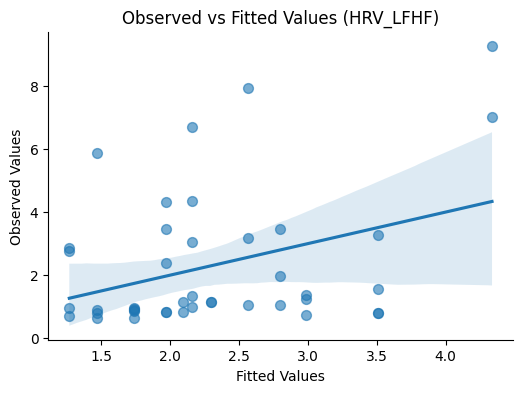

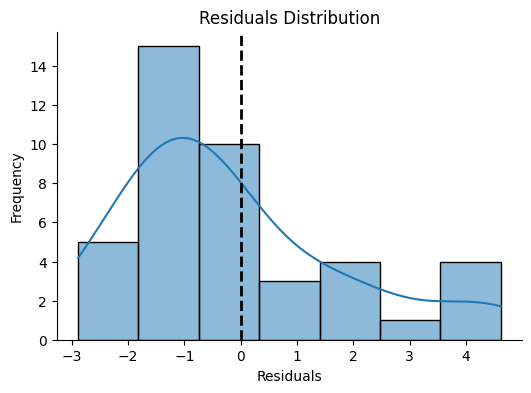

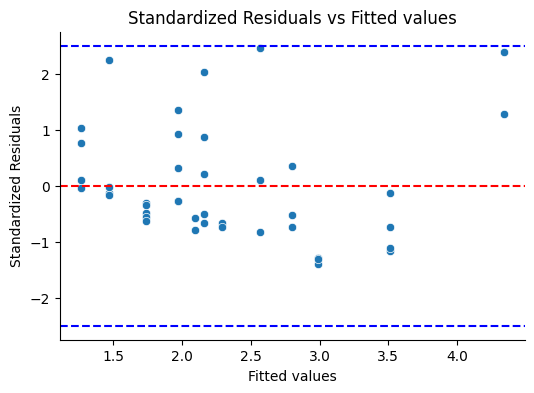

In [ ]:
visual_check(model_hrv_lfhf_ii_cleaned, dv="HRV_LFHF")

Rejecting outliers didn't lead to better results

In [ ]:
# Apply log-transformation (should I try with box-cox as well?)
hrv_lfhf_df_cleaned = hrv_lfhf_df_cleaned.with_columns(
    pl.col("HRV_LFHF").log().alias("HRV_LFHF_log"))

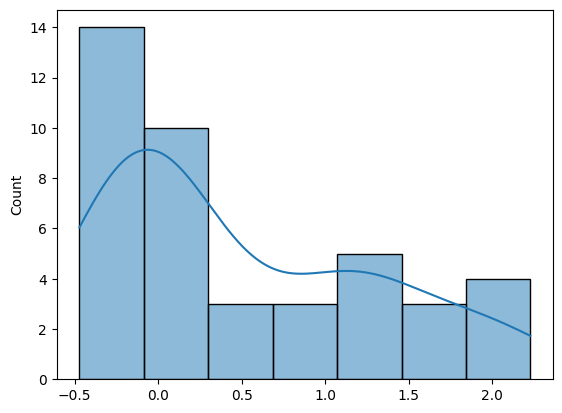

In [ ]:
# dv distribution
sns.histplot(hrv_lfhf_df_cleaned["HRV_LFHF_log"], kde=True)
plt.show()

### Refitting model

In [ ]:
model_hrv_lfhf_log_i = lmer("HRV_LFHF_log ~ group * session + (1 | ID)",
               data=hrv_lfhf_df_cleaned)

# Set reference
set_factors(model_hrv_lfhf_log_i)

model_hrv_lfhf_log_i.fit(summary=True)

GT(_tbl_data=shape: (10, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ rfx      ‚îÜ param   ‚îÜ estimat ‚îÜ std_err ‚îÜ conf_lo ‚îÜ conf_hi ‚îÜ t_stat  ‚îÜ df      ‚îÜ p_value ‚îÜ stars ‚îÇ
‚îÇ ---      ‚îÜ ---     ‚îÜ e       ‚îÜ or      ‚îÜ w       ‚îÜ gh      ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---   ‚îÇ
‚îÇ str      ‚îÜ str     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ f64     ‚îÜ f64     ‚îÜ str     ‚îÜ str   ‚îÇ
‚îÇ          ‚îÜ         ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ ID-sd    ‚îÜ (Interc ‚îÜ 0.29539 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ 1       ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ Residual ‚îÜ Observa ‚îÜ 0.75043 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ -sd      ‚îÜ tion    ‚îÜ 6       ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Fixed    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Effects: ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ (Interc ‚îÜ 0.89482 ‚îÜ 0.32924 ‚îÜ 0.22624 ‚îÜ 1.56339 ‚îÜ 2.71780 ‚îÜ 34.7491 ‚îÜ 0.01018 ‚îÜ *     ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ         ‚îÜ 4       ‚îÜ 7       ‚îÜ 4       ‚îÜ 1       ‚îÜ 92      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ -0.2730 ‚îÜ 0.43554 ‚îÜ -1.1575 ‚îÜ 0.61136 ‚îÜ -0.6269 ‚îÜ 34.7491 ‚îÜ 0.5348  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p       ‚îÜ 74      ‚îÜ 9       ‚îÜ 14      ‚îÜ 6       ‚îÜ 64      ‚îÜ 92      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ session ‚îÜ -0.6271 ‚îÜ 0.43326 ‚îÜ -1.5213 ‚îÜ 0.26707 ‚îÜ -1.4474 ‚îÜ 24.0    ‚îÜ 0.1607  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ Resting ‚îÜ 37      ‚îÜ 5       ‚îÜ 51      ‚îÜ 7       ‚îÜ 69      ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ state   ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ session ‚îÜ -0.6903 ‚îÜ 0.43326 ‚îÜ -1.5845 ‚îÜ 0.20386 ‚îÜ -1.5933 ‚îÜ 24.0    ‚îÜ 0.1242  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ Exam    ‚îÜ 52      ‚îÜ 5       ‚îÜ 67      ‚îÜ 2       ‚îÜ 74      ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ 0.64589 ‚îÜ 0.57315 ‚îÜ -0.5370 ‚îÜ 1.82882 ‚îÜ 1.12690 ‚îÜ 24.0    ‚îÜ 0.2709  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p:sessi ‚îÜ 2       ‚îÜ 5       ‚îÜ 41      ‚îÜ 6       ‚îÜ 7       ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ onResti ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ ng      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ state   ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ 0.36715 ‚îÜ 0.57315 ‚îÜ -0.8157 ‚îÜ 1.55008 ‚îÜ 0.64057 ‚îÜ 24.0    ‚îÜ 0.5279  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p:sessi ‚îÜ 1       ‚îÜ 5       ‚îÜ 83      ‚îÜ 5       ‚îÜ 8       ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ onExam  ‚îÜ         ‚îÜ        

In [ ]:
model_hrv_lfhf_log_ii = lmer("HRV_LFHF_log ~ group * session + instrument_type + (1 | ID)",
               data=hrv_lfhf_df_cleaned)

# Set reference
set_factors(model_hrv_lfhf_log_ii)

model_hrv_lfhf_log_ii.fit(summary=True)

GT(_tbl_data=shape: (11, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ rfx      ‚îÜ param   ‚îÜ estimat ‚îÜ std_err ‚îÜ conf_lo ‚îÜ conf_hi ‚îÜ t_stat  ‚îÜ df      ‚îÜ p_value ‚îÜ stars ‚îÇ
‚îÇ ---      ‚îÜ ---     ‚îÜ e       ‚îÜ or      ‚îÜ w       ‚îÜ gh      ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---   ‚îÇ
‚îÇ str      ‚îÜ str     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ f64     ‚îÜ f64     ‚îÜ str     ‚îÜ str   ‚îÇ
‚îÇ          ‚îÜ         ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ ID-sd    ‚îÜ (Interc ‚îÜ 0.30640 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ 7       ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ Residual ‚îÜ Observa ‚îÜ 0.75043 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ -sd      ‚îÜ tion    ‚îÜ 6       ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Fixed    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Effects: ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ (Interc ‚îÜ 0.81116 ‚îÜ 0.34533 ‚îÜ 0.10706 ‚îÜ 1.51527 ‚îÜ 2.34890 ‚îÜ 31.2407 ‚îÜ 0.02533 ‚îÜ *     ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ 9       ‚îÜ 9       ‚îÜ 5       ‚îÜ 2       ‚îÜ 5       ‚îÜ 88      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ ‚Ä¶        ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶     ‚îÇ
‚îÇ null     ‚îÜ session ‚îÜ -0.6271 ‚îÜ 0.43326 ‚îÜ -1.5213 ‚îÜ 0.26707 ‚îÜ -1.4474 ‚îÜ 24.0    ‚îÜ 0.1607  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ Resting ‚îÜ 37      ‚îÜ 5       ‚îÜ 51      ‚îÜ 7       ‚îÜ 69      ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ state   ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ session ‚îÜ -0.6903 ‚îÜ 0.43326 ‚îÜ -1.5845 ‚îÜ 0.20386 ‚îÜ -1.5933 ‚îÜ 24.0    ‚îÜ 0.1242  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ Exam    ‚îÜ 52      ‚îÜ 5       ‚îÜ 67      ‚îÜ 2       ‚îÜ 74      ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ instrum ‚îÜ 0.25095 ‚îÜ 0.29626 ‚îÜ -0.4011 ‚îÜ 0.90302 ‚îÜ 0.84706 ‚îÜ 11.0    ‚îÜ 0.415   ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ ent_typ ‚îÜ 5       ‚îÜ 4       ‚îÜ 18      ‚îÜ 8       ‚îÜ 5       ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ e1      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ 0.64589 ‚îÜ 0.57315 ‚îÜ -0.5370 ‚îÜ 1.82882 ‚îÜ 1.12690 ‚îÜ 24.0    ‚îÜ 0.2709  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p:sessi ‚îÜ 2       ‚îÜ 5       ‚îÜ 41      ‚îÜ 6       ‚îÜ 7       ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ onResti ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ ng      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ state   ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ

In [ ]:
model_hrv_lfhf_log_iii = lmer("HRV_LFHF_log ~ group * session + instrument_type + gender + (1 | ID)",
               data=hrv_lfhf_df_cleaned)

# Set reference
set_factors(model_hrv_lfhf_log_iii)

model_hrv_lfhf_log_iii.fit(summary=True)

R messages: 
boundary (singular) fit: see help('isSingular')

Random effect variances not available. Returned R2 does not account for random effects.

R messages: 
boundary (singular) fit: see help('isSingular')

Random effect variances not available. Returned R2 does not account for random effects.



GT(_tbl_data=shape: (12, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ rfx      ‚îÜ param    ‚îÜ estimate ‚îÜ std_erro ‚îÜ conf_lo ‚îÜ conf_hi ‚îÜ t_stat  ‚îÜ df   ‚îÜ p_value ‚îÜ stars ‚îÇ
‚îÇ ---      ‚îÜ ---      ‚îÜ ---      ‚îÜ r        ‚îÜ w       ‚îÜ gh      ‚îÜ ---     ‚îÜ ---  ‚îÜ ---     ‚îÜ ---   ‚îÇ
‚îÇ str      ‚îÜ str      ‚îÜ f64      ‚îÜ ---      ‚îÜ ---     ‚îÜ ---     ‚îÜ f64     ‚îÜ f64  ‚îÜ str     ‚îÜ str   ‚îÇ
‚îÇ          ‚îÜ          ‚îÜ          ‚îÜ f64      ‚îÜ f64     ‚îÜ f64     ‚îÜ         ‚îÜ      ‚îÜ         ‚îÜ       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ ID-sd    ‚îÜ (Interce ‚îÜ 0.0      ‚îÜ null     ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ          ‚îÜ pt)      ‚îÜ          ‚îÜ          ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ Residual ‚îÜ Observat ‚îÜ 0.745867 ‚îÜ null     ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ -sd      ‚îÜ ion      ‚îÜ          ‚îÜ          ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ null     ‚îÜ null     ‚îÜ null     ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Fixed    ‚îÜ null     ‚îÜ null     ‚îÜ null     ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Effects: ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ (Interce ‚îÜ 1.237176 ‚îÜ 0.353653 ‚îÜ 0.51846 ‚îÜ 1.95588 ‚îÜ 3.49828 ‚îÜ 34.0 ‚îÜ 0.00132 ‚îÜ **    ‚îÇ
‚îÇ          ‚îÜ pt)      ‚îÜ          ‚îÜ          ‚îÜ 7       ‚îÜ 5       ‚îÜ         ‚îÜ      ‚îÜ 7       ‚îÜ       ‚îÇ
‚îÇ ‚Ä¶        ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶    ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶     ‚îÇ
‚îÇ null     ‚îÜ sessionE ‚îÜ -0.69035 ‚îÜ 0.430626 ‚îÜ -1.5654 ‚îÜ 0.18478 ‚îÜ -1.6031 ‚îÜ 34.0 ‚îÜ 0.1182  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ xam      ‚îÜ 2        ‚îÜ          ‚îÜ 9       ‚îÜ 5       ‚îÜ 36      ‚îÜ      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ instrume ‚îÜ 0.339706 ‚îÜ 0.242744 ‚îÜ -0.1536 ‚îÜ 0.83302 ‚îÜ 1.39944 ‚îÜ 34.0 ‚îÜ 0.1707  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ nt_type1 ‚îÜ          ‚îÜ          ‚îÜ 08      ‚îÜ 1       ‚îÜ 5       ‚îÜ      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ gender2  ‚îÜ -0.68338 ‚îÜ 0.258309 ‚îÜ -1.2083 ‚îÜ -0.1584 ‚îÜ -2.6456 ‚îÜ 34.0 ‚îÜ 0.01226 ‚îÜ *     ‚îÇ
‚îÇ          ‚îÜ          ‚îÜ 7        ‚îÜ          ‚îÜ 33      ‚îÜ 41      ‚îÜ 21      ‚îÜ      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupexp ‚îÜ 0.645892 ‚îÜ 0.569665 ‚îÜ -0.5118 ‚îÜ 1.80359 ‚îÜ 1.13381 ‚îÜ 34.0 ‚îÜ 0.2648  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ :session ‚îÜ          ‚îÜ          ‚îÜ 06      ‚îÜ 1       ‚îÜ 1       ‚îÜ      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ Resting  ‚îÜ          ‚îÜ          ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ state    ‚îÜ          ‚îÜ          ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupexp ‚îÜ 0.367151 ‚îÜ 0.569665 ‚îÜ -0.7905 ‚îÜ 1.52484 ‚îÜ 0.64450 ‚îÜ 34.0 ‚îÜ 0.5236  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ :session ‚îÜ          ‚îÜ          ‚îÜ 48      ‚îÜ 9       ‚îÜ 3       ‚îÜ      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ Exam     ‚îÜ          ‚îÜ          ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ      ‚îÜ         ‚îÜ       ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚

In [ ]:
compare(model_hrv_lfhf_log_i, model_hrv_lfhf_log_ii)

GT(_tbl_data=shape: (2, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ AIC        ‚îÜ BIC       ‚îÜ logLik    ‚îÜ npar ‚îÜ -2*log(L) ‚îÜ Chisq    ‚îÜ Df  ‚îÜ Pr(>Chisq ‚îÜ stars ‚îÜ ids ‚îÇ
‚îÇ ---        ‚îÜ ---       ‚îÜ ---       ‚îÜ ---  ‚îÜ ---       ‚îÜ ---      ‚îÜ --- ‚îÜ )         ‚îÜ ---   ‚îÜ --- ‚îÇ
‚îÇ f64        ‚îÜ f64       ‚îÜ f64       ‚îÜ i64  ‚îÜ f64       ‚îÜ f64      ‚îÜ f64 ‚îÜ ---       ‚îÜ str   ‚îÜ i64 ‚îÇ
‚îÇ            ‚îÜ           ‚îÜ           ‚îÜ      ‚îÜ           ‚îÜ          ‚îÜ     ‚îÜ str       ‚îÜ       ‚îÜ     ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 113.686757 ‚îÜ 127.58811 ‚îÜ -48.84337 ‚îÜ 8    ‚îÜ 93.944352 ‚îÜ 0.0      ‚îÜ 0.0 ‚îÜ           ‚îÜ       ‚îÜ 1   ‚îÇ
‚îÇ            ‚îÜ 4         ‚îÜ 9         ‚îÜ      ‚îÜ           ‚îÜ          ‚îÜ     ‚îÜ           ‚îÜ       ‚îÜ     ‚îÇ
‚îÇ 115.567747 ‚îÜ 131.20677 ‚îÜ -48.78387 ‚îÜ 9    ‚îÜ 93.059694 ‚îÜ 0.884657 ‚îÜ 1.0 ‚îÜ 0.347     ‚îÜ       ‚îÜ 2   ‚îÇ
‚îÇ            ‚îÜ 4         ‚îÜ 4         ‚îÜ      ‚îÜ           ‚îÜ          ‚îÜ     ‚îÜ           ‚îÜ       ‚îÜ     ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò, _body=<great_tables._gt_data.Body object at 0x7b2a15dcadd0>, _boxhead=Boxhead([ColInfo(var='ids', type=<ColInfoTypeEnum.stub: 2>, column_label='', column_align='right', column_width=None), ColInfo(var='AIC', type=<ColInfoTypeEnum.default: 1>, column_label='AIC', column_align='right', column_width=None), ColInfo(var='BIC', type=<ColInfoTypeEnum.default: 1>, column_label='BIC', column_align='right', column_width=None), ColInfo(var='logLik', type=<ColInfoTypeEnum.default: 1>, column_label='logLik', column_align='right', column_width=None), ColInfo(var='npar', type=<ColInfoTypeEnum.default: 1>, column_label='npar', column_align='right', column_width=None), ColInfo(var='-2*log(L)', type=<ColInfoTypeEnum.default: 1>, column_label='-2*log(L)', column_align='right', column_width=None), ColInfo(var='Chisq', type=<ColInfoTypeEnum.default: 1>, column_label='Chisq', column_align='right', column_width=None), ColInfo(var='Df', type=<ColInfoTypeEnum.default: 1>, column_label='Df', column_align='right', column_width=None), ColInfo(var='Pr(>Chisq)', type=<ColInfoTypeEnum.default: 1>, column_label='Pr(>Chisq)', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7b2a15e0fd10>, _spanners=Spanners([]), _heading=Heading(title='Analysis of Deviance Table', subtitle=Md(text='Model 1: lmer(HRV_LFHF_log~group*session+(1|ID))   \nModel 2: lmer(HRV_LFHF_log~group*session+instrument_type+(1|ID))   \n'), preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7b2a15deabd0>, _formats=[<great_tables._gt_data.FormatInfo object at 0x7b2a15f287d0>, <great_tables._gt_data.FormatInfo object at 0x7b2a15f2b910>], _substitutions=[<great_tables._gt_data.FormatInfo object at 0x7b2a15f52a50>], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo

Instrument type did not add significantly --> stay with the core model

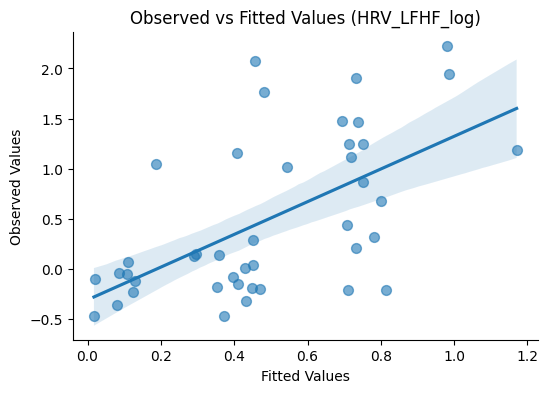

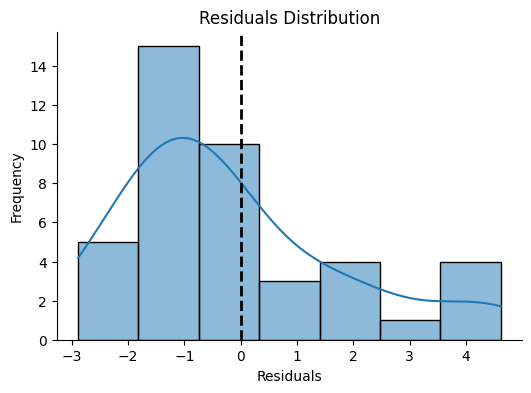

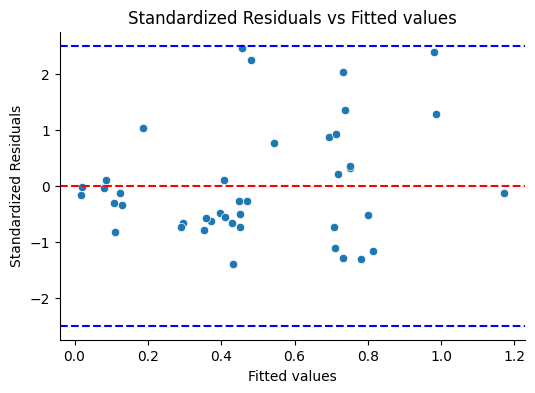

In [ ]:
visual_check(model_hrv_lfhf_log_i, dv="HRV_LFHF_log")

Its still problematic, but I will stick with this for now. No convergence or singularity issues with this model. Observed vs fitted values show the most promising results. Adding gender leads to singularity issues again. Cannot use compare() since the latest model was fitted on a filtered, thus different sized dataframe.

### Model fit

In [ ]:
# Fitting stats and variance partitioning
model_hrv_lfhf_log_df = model_hrv_lfhf_log_i.result_fit_stats
model_hrv_lfhf_log_i.result_fit_stats

shape: (1, 13)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ AIC ‚îÜ AIC ‚îÜ BIC ‚îÜ ICC    ‚îÜ R2_con ‚îÜ R2_ma ‚îÜ REMLc ‚îÜ RMSE  ‚îÜ Sigma ‚îÜ df_re ‚îÜ logLi ‚îÜ nobs ‚îÜ sigma ‚îÇ
‚îÇ --- ‚îÜ c   ‚îÜ --- ‚îÜ ---    ‚îÜ dition ‚îÜ rgina ‚îÜ rit   ‚îÜ ---   ‚îÜ ---   ‚îÜ sidua ‚îÜ k     ‚îÜ ---  ‚îÜ ---   ‚îÇ
‚îÇ f64 ‚îÜ --- ‚îÜ f64 ‚îÜ f64    ‚îÜ al     ‚îÜ l     ‚îÜ ---   ‚îÜ f64   ‚îÜ f64   ‚îÜ l     ‚îÜ ---   ‚îÜ i64  ‚îÜ f64   ‚îÇ
‚îÇ     ‚îÜ f64 ‚îÜ     ‚îÜ        ‚îÜ ---    ‚îÜ ---   ‚îÜ f64   ‚îÜ       ‚îÜ       ‚îÜ ---   ‚îÜ f64   ‚îÜ      ‚îÜ       ‚îÇ
‚îÇ     ‚îÜ     ‚îÜ     ‚îÜ        ‚îÜ f64    ‚îÜ f64   ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ i64   ‚îÜ       ‚îÜ      ‚îÜ       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 113 ‚îÜ 118 ‚îÜ 127 ‚îÜ 0.1341 ‚îÜ 0.2051 ‚îÜ 0.082 ‚îÜ 97.68 ‚îÜ 0.656 ‚îÜ 0.750 ‚îÜ 34    ‚îÜ -48.8 ‚îÜ 42   ‚îÜ 0.750 ‚îÇ
‚îÇ .68 ‚îÜ .05 ‚îÜ .58 ‚îÜ 55     ‚îÜ 55     ‚îÜ 001   ‚îÜ 6757  ‚îÜ 998   ‚îÜ 436   ‚îÜ       ‚îÜ 43379 ‚îÜ      ‚îÜ 436   ‚îÇ
‚îÇ 675 ‚îÜ 039 ‚îÜ 811 ‚îÜ        ‚îÜ        ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ      ‚îÜ       ‚îÇ
‚îÇ 7   ‚îÜ 4   ‚îÜ 4   ‚îÜ        ‚îÜ        ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ      ‚îÜ       ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [ ]:
# Check multicollinearity
model_hrv_lfhf_log.vif()

shape: (6, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ term                          ‚îÜ vif      ‚îÜ ci_increase_factor ‚îÇ
‚îÇ ---                           ‚îÜ ---      ‚îÜ ---                ‚îÇ
‚îÇ str                           ‚îÜ f64      ‚îÜ f64                ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ groupexp                      ‚îÜ 3.0      ‚îÜ 1.732051           ‚îÇ
‚îÇ sessionResting state          ‚îÜ 2.666667 ‚îÜ 1.632993           ‚îÇ
‚îÇ sessionExam                   ‚îÜ 2.666667 ‚îÜ 1.632993           ‚îÇ
‚îÇ instrument_type1              ‚îÜ 1.0      ‚îÜ 1.0                ‚îÇ
‚îÇ groupexp:sessionResting state ‚îÜ 3.333333 ‚îÜ 1.825742           ‚îÇ
‚îÇ groupexp:sessionExam          ‚îÜ 3.333333 ‚îÜ 1.825742           ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

### Post-hoc tests

We didn't find any significant effects

## Respiratory rate

### Modeling

In [ ]:
rr_df = filter_df_for_dv(rrv_data, "RSP_Rate_Mean")

In [ ]:
model_rr_i = lmer("RSP_Rate_Mean ~ group * session + (1 | ID)",
               data=rr_df)

set_factors(model_rr_i)

model_rr_i.fit(summary=True)


GT(_tbl_data=shape: (10, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ rfx      ‚îÜ param   ‚îÜ estimat ‚îÜ std_err ‚îÜ conf_lo ‚îÜ conf_hi ‚îÜ t_stat  ‚îÜ df      ‚îÜ p_value ‚îÜ stars ‚îÇ
‚îÇ ---      ‚îÜ ---     ‚îÜ e       ‚îÜ or      ‚îÜ w       ‚îÜ gh      ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---   ‚îÇ
‚îÇ str      ‚îÜ str     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ f64     ‚îÜ f64     ‚îÜ str     ‚îÜ str   ‚îÇ
‚îÇ          ‚îÜ         ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ ID-sd    ‚îÜ (Interc ‚îÜ 3.43215 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ 6       ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ Residual ‚îÜ Observa ‚îÜ 4.01594 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ -sd      ‚îÜ tion    ‚îÜ 8       ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Fixed    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Effects: ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ (Interc ‚îÜ 17.0384 ‚îÜ 2.15667 ‚îÜ 12.6097 ‚îÜ 21.4671 ‚îÜ 7.90032 ‚îÜ 26.5421 ‚îÜ <.001   ‚îÜ ***   ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ 38      ‚îÜ 7       ‚îÜ 28      ‚îÜ 48      ‚îÜ         ‚îÜ 67      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ 2.62721 ‚îÜ 2.85301 ‚îÜ -3.2314 ‚îÜ 8.48585 ‚îÜ 0.92085 ‚îÜ 26.5421 ‚îÜ 0.3654  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p       ‚îÜ 9       ‚îÜ 5       ‚îÜ 13      ‚îÜ 1       ‚îÜ 7       ‚îÜ 67      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ session ‚îÜ -0.0974 ‚îÜ 2.31860 ‚îÜ -4.8828 ‚îÜ 4.68788 ‚îÜ -0.0420 ‚îÜ 24.0    ‚îÜ 0.9668  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ Resting ‚îÜ 92      ‚îÜ 8       ‚îÜ 65      ‚îÜ 1       ‚îÜ 48      ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ state   ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ session ‚îÜ -1.7605 ‚îÜ 2.31860 ‚îÜ -6.5458 ‚îÜ 3.02485 ‚îÜ -0.7593 ‚îÜ 24.0    ‚îÜ 0.4551  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ Exam    ‚îÜ 2       ‚îÜ 8       ‚îÜ 93      ‚îÜ 3       ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ -3.7014 ‚îÜ 3.06723 ‚îÜ -10.031 ‚îÜ 2.62904 ‚îÜ -1.2067 ‚îÜ 24.0    ‚îÜ 0.2393  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p:sessi ‚îÜ 1       ‚îÜ 1       ‚îÜ 863     ‚îÜ 3       ‚îÜ 6       ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ onResti ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ ng      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ state   ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ 2.42955 ‚îÜ 3.06723 ‚îÜ -3.9009 ‚îÜ 8.76000 ‚îÜ 0.7921  ‚îÜ 24.0    ‚îÜ 0.4361  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p:sessi ‚îÜ 3       ‚îÜ 1       ‚îÜ         ‚îÜ 6       ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ onExam  ‚îÜ         ‚îÜ        

In [ ]:
model_rr_ii = lmer("RSP_Rate_Mean ~ group * session + instrument_type + (1 | ID)",
                   data=rr_df)

set_factors(model_rr_ii)

model_rr_ii.fit(summary=True)

GT(_tbl_data=shape: (11, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ rfx      ‚îÜ param   ‚îÜ estimat ‚îÜ std_err ‚îÜ conf_lo ‚îÜ conf_hi ‚îÜ t_stat  ‚îÜ df      ‚îÜ p_value ‚îÜ stars ‚îÇ
‚îÇ ---      ‚îÜ ---     ‚îÜ e       ‚îÜ or      ‚îÜ w       ‚îÜ gh      ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---   ‚îÇ
‚îÇ str      ‚îÜ str     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ f64     ‚îÜ f64     ‚îÜ str     ‚îÜ str   ‚îÇ
‚îÇ          ‚îÜ         ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ ID-sd    ‚îÜ (Interc ‚îÜ 0.85541 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ 8       ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ Residual ‚îÜ Observa ‚îÜ 4.01594 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ -sd      ‚îÜ tion    ‚îÜ 8       ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Fixed    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Effects: ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ (Interc ‚îÜ 19.2299 ‚îÜ 1.73823 ‚îÜ 15.6961 ‚îÜ 22.7638 ‚îÜ 11.0629 ‚îÜ 33.6599 ‚îÜ <.001   ‚îÜ ***   ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ 85      ‚îÜ 2       ‚îÜ 57      ‚îÜ 13      ‚îÜ 56      ‚îÜ 29      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ ‚Ä¶        ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶     ‚îÇ
‚îÇ null     ‚îÜ session ‚îÜ -0.0974 ‚îÜ 2.31860 ‚îÜ -4.8828 ‚îÜ 4.68788 ‚îÜ -0.0420 ‚îÜ 23.9999 ‚îÜ 0.9668  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ Resting ‚îÜ 92      ‚îÜ 9       ‚îÜ 65      ‚îÜ 1       ‚îÜ 48      ‚îÜ 96      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ state   ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ session ‚îÜ -1.7605 ‚îÜ 2.31860 ‚îÜ -6.5458 ‚îÜ 3.02485 ‚îÜ -0.7593 ‚îÜ 23.9999 ‚îÜ 0.4551  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ Exam    ‚îÜ 2       ‚îÜ 9       ‚îÜ 93      ‚îÜ 3       ‚îÜ         ‚îÜ 96      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ instrum ‚îÜ -6.5746 ‚îÜ 1.37974 ‚îÜ -9.6114 ‚îÜ -3.5378 ‚îÜ -4.7651 ‚îÜ 10.9999 ‚îÜ <.001   ‚îÜ ***   ‚îÇ
‚îÇ          ‚îÜ ent_typ ‚îÜ 42      ‚îÜ 4       ‚îÜ 38      ‚îÜ 45      ‚îÜ 16      ‚îÜ 98      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ e1      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ -3.7014 ‚îÜ 3.06723 ‚îÜ -10.031 ‚îÜ 2.62904 ‚îÜ -1.2067 ‚îÜ 23.9999 ‚îÜ 0.2393  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p:sessi ‚îÜ 1       ‚îÜ 1       ‚îÜ 864     ‚îÜ 3       ‚îÜ 6       ‚îÜ 96      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ onResti ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ ng      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ state   ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ

In [ ]:
model_rr_iii = lmer("RSP_Rate_Mean ~ group * session + instrument_type + gender + (1 | ID)",
                    data=rr_df)

set_factors(model_rr_iii)

model_rr_iii.fit(summary=True)

GT(_tbl_data=shape: (12, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ rfx      ‚îÜ param   ‚îÜ estimat ‚îÜ std_err ‚îÜ conf_lo ‚îÜ conf_hi ‚îÜ t_stat  ‚îÜ df      ‚îÜ p_value ‚îÜ stars ‚îÇ
‚îÇ ---      ‚îÜ ---     ‚îÜ e       ‚îÜ or      ‚îÜ w       ‚îÜ gh      ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---   ‚îÇ
‚îÇ str      ‚îÜ str     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ f64     ‚îÜ f64     ‚îÜ str     ‚îÜ str   ‚îÇ
‚îÇ          ‚îÜ         ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ ID-sd    ‚îÜ (Interc ‚îÜ 0.71530 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ 1       ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ Residual ‚îÜ Observa ‚îÜ 4.01594 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ -sd      ‚îÜ tion    ‚îÜ 8       ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Fixed    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Effects: ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ (Interc ‚îÜ 18.1199 ‚îÜ 1.96220 ‚îÜ 14.0909 ‚îÜ 22.1489 ‚îÜ 9.23449 ‚îÜ 26.5934 ‚îÜ <.001   ‚îÜ ***   ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ 79      ‚îÜ 5       ‚îÜ 85      ‚îÜ 74      ‚îÜ 8       ‚îÜ 43      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ ‚Ä¶        ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶     ‚îÇ
‚îÇ null     ‚îÜ session ‚îÜ -1.7605 ‚îÜ 2.31860 ‚îÜ -6.5458 ‚îÜ 3.02485 ‚îÜ -0.7593 ‚îÜ 23.9999 ‚îÜ 0.4551  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ Exam    ‚îÜ 2       ‚îÜ 9       ‚îÜ 93      ‚îÜ 3       ‚îÜ         ‚îÜ 93      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ instrum ‚îÜ -6.4699 ‚îÜ 1.35752 ‚îÜ -9.4946 ‚îÜ -3.4451 ‚îÜ -4.7659 ‚îÜ 9.99999 ‚îÜ <.001   ‚îÜ ***   ‚îÇ
‚îÇ          ‚îÜ ent_typ ‚îÜ 24      ‚îÜ 2       ‚îÜ 73      ‚îÜ 76      ‚îÜ 8       ‚îÜ 5       ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ e1      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ gender2 ‚îÜ 1.61265 ‚îÜ 1.35752 ‚îÜ -1.4120 ‚îÜ 4.63739 ‚îÜ 1.18793 ‚îÜ 9.99999 ‚îÜ 0.2623  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ         ‚îÜ         ‚îÜ 2       ‚îÜ 99      ‚îÜ 8       ‚îÜ 6       ‚îÜ 5       ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ -3.7014 ‚îÜ 3.06723 ‚îÜ -10.031 ‚îÜ 2.62904 ‚îÜ -1.2067 ‚îÜ 23.9999 ‚îÜ 0.2393  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p:sessi ‚îÜ 1       ‚îÜ 1       ‚îÜ 864     ‚îÜ 3       ‚îÜ 6       ‚îÜ 93      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ onResti ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ ng      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ state   ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ 2.42955 ‚îÜ 3.06723 ‚îÜ -3.9009 ‚îÜ 8.76000 ‚îÜ 0.7921  ‚îÜ 23.9999 ‚îÜ 0.4361  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p:sessi ‚îÜ

In [ ]:
compare(model_rr_i, model_rr_ii, model_rr_iii)

GT(_tbl_data=shape: (3, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ AIC       ‚îÜ BIC       ‚îÜ logLik    ‚îÜ npar ‚îÜ -2*log(L) ‚îÜ Chisq     ‚îÜ Df  ‚îÜ Pr(>Chisq ‚îÜ stars ‚îÜ ids ‚îÇ
‚îÇ ---       ‚îÜ ---       ‚îÜ ---       ‚îÜ ---  ‚îÜ ---       ‚îÜ ---       ‚îÜ --- ‚îÜ )         ‚îÜ ---   ‚îÜ --- ‚îÇ
‚îÇ f64       ‚îÜ f64       ‚îÜ f64       ‚îÜ i64  ‚îÜ f64       ‚îÜ f64       ‚îÜ f64 ‚îÜ ---       ‚îÜ str   ‚îÜ i64 ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ      ‚îÜ           ‚îÜ           ‚îÜ     ‚îÜ str       ‚îÜ       ‚îÜ     ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 243.80157 ‚îÜ 257.70292 ‚îÜ -113.9007 ‚îÜ 8    ‚îÜ 245.74496 ‚îÜ 0.0       ‚îÜ 0.0 ‚îÜ           ‚îÜ       ‚îÜ 1   ‚îÇ
‚îÇ 1         ‚îÜ 8         ‚îÜ 85        ‚îÜ      ‚îÜ 7         ‚îÜ           ‚îÜ     ‚îÜ           ‚îÜ       ‚îÜ     ‚îÇ
‚îÇ 229.92654 ‚îÜ 245.56557 ‚îÜ -105.9632 ‚îÜ 9    ‚îÜ 230.06790 ‚îÜ 15.677066 ‚îÜ 1.0 ‚îÜ <.001     ‚îÜ ***   ‚îÜ 2   ‚îÇ
‚îÇ 9         ‚îÜ 5         ‚îÜ 74        ‚îÜ      ‚îÜ 1         ‚îÜ           ‚îÜ     ‚îÜ           ‚îÜ       ‚îÜ     ‚îÇ
‚îÇ 228.07365 ‚îÜ 245.45035 ‚îÜ -104.0368 ‚îÜ 10   ‚îÜ 228.25835 ‚îÜ 1.809547  ‚îÜ 1.0 ‚îÜ 0.179     ‚îÜ       ‚îÜ 3   ‚îÇ
‚îÇ 7         ‚îÜ 3         ‚îÜ 28        ‚îÜ      ‚îÜ 5         ‚îÜ           ‚îÜ     ‚îÜ           ‚îÜ       ‚îÜ     ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò, _body=<great_tables._gt_data.Body object at 0x7b2a15e89990>, _boxhead=Boxhead([ColInfo(var='ids', type=<ColInfoTypeEnum.stub: 2>, column_label='', column_align='right', column_width=None), ColInfo(var='AIC', type=<ColInfoTypeEnum.default: 1>, column_label='AIC', column_align='right', column_width=None), ColInfo(var='BIC', type=<ColInfoTypeEnum.default: 1>, column_label='BIC', column_align='right', column_width=None), ColInfo(var='logLik', type=<ColInfoTypeEnum.default: 1>, column_label='logLik', column_align='right', column_width=None), ColInfo(var='npar', type=<ColInfoTypeEnum.default: 1>, column_label='npar', column_align='right', column_width=None), ColInfo(var='-2*log(L)', type=<ColInfoTypeEnum.default: 1>, column_label='-2*log(L)', column_align='right', column_width=None), ColInfo(var='Chisq', type=<ColInfoTypeEnum.default: 1>, column_label='Chisq', column_align='right', column_width=None), ColInfo(var='Df', type=<ColInfoTypeEnum.default: 1>, column_label='Df', column_align='right', column_width=None), ColInfo(var='Pr(>Chisq)', type=<ColInfoTypeEnum.default: 1>, column_label='Pr(>Chisq)', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7b2a15ffbe50>, _spanners=Spanners([]), _heading=Heading(title='Analysis of Deviance Table', subtitle=Md(text='Model 1: lmer(RSP_Rate_Mean~group*session+(1|ID))   \nModel 2: lmer(RSP_Rate_Mean~group*session+instrument_type+(1|ID))   \nModel 3: lmer(RSP_Rate_Mean~group*session+instrument_type+gender+(1|ID))   \n'), preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7b2a15e23d50>, _forma

### Assumptions

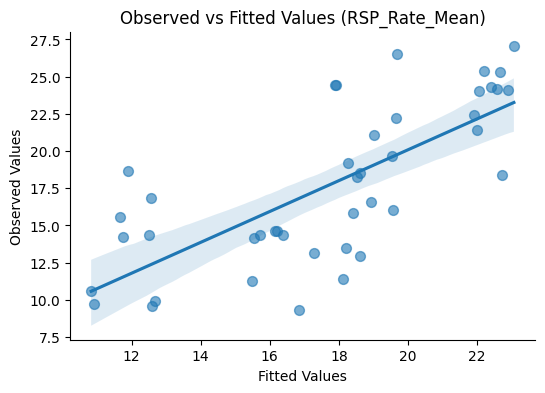

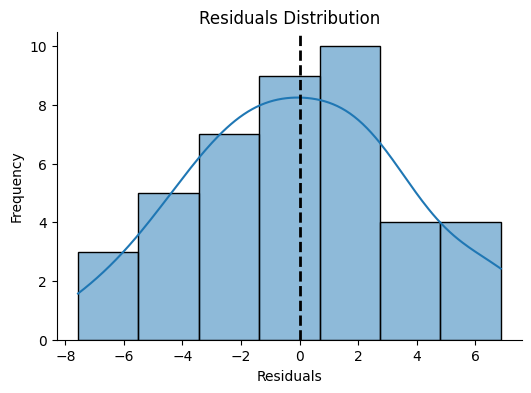

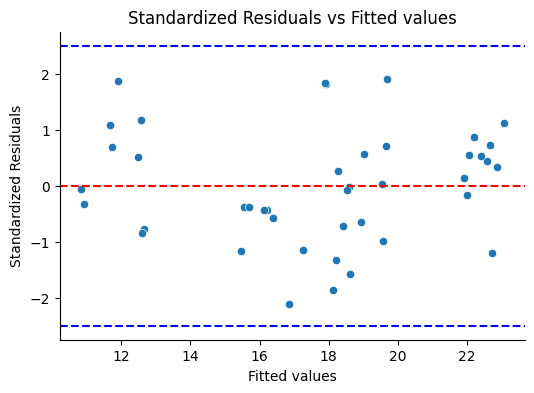

In [ ]:
visual_check(model_rr_ii, dv="RSP_Rate_Mean")

### Model fit

In [ ]:
# Fitting stats and variance partitioning
model_rr_df = model_rr_ii.result_fit_stats
model_hr_ii.result_fit_stats

shape: (1, 13)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ AIC ‚îÜ AIC ‚îÜ BIC ‚îÜ ICC    ‚îÜ R2_con ‚îÜ R2_ma ‚îÜ REMLc ‚îÜ RMSE  ‚îÜ Sigma ‚îÜ df_re ‚îÜ logLi ‚îÜ nobs ‚îÜ sigma ‚îÇ
‚îÇ --- ‚îÜ c   ‚îÜ --- ‚îÜ ---    ‚îÜ dition ‚îÜ rgina ‚îÜ rit   ‚îÜ ---   ‚îÜ ---   ‚îÜ sidua ‚îÜ k     ‚îÜ ---  ‚îÜ ---   ‚îÇ
‚îÇ f64 ‚îÜ --- ‚îÜ f64 ‚îÜ f64    ‚îÜ al     ‚îÜ l     ‚îÜ ---   ‚îÜ f64   ‚îÜ f64   ‚îÜ l     ‚îÜ ---   ‚îÜ i64  ‚îÜ f64   ‚îÇ
‚îÇ     ‚îÜ f64 ‚îÜ     ‚îÜ        ‚îÜ ---    ‚îÜ ---   ‚îÜ f64   ‚îÜ       ‚îÜ       ‚îÜ ---   ‚îÜ f64   ‚îÜ      ‚îÜ       ‚îÇ
‚îÇ     ‚îÜ     ‚îÜ     ‚îÜ        ‚îÜ f64    ‚îÜ f64   ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ i64   ‚îÜ       ‚îÜ      ‚îÜ       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 371 ‚îÜ 376 ‚îÜ 387 ‚îÜ 0.2025 ‚îÜ 0.5587 ‚îÜ 0.446 ‚îÜ 353.6 ‚îÜ 16.41 ‚îÜ 19.22 ‚îÜ 36    ‚îÜ -176. ‚îÜ 45   ‚îÜ 19.22 ‚îÇ
‚îÇ .63 ‚îÜ .77 ‚îÜ .89 ‚îÜ 09     ‚îÜ 92     ‚îÜ 755   ‚îÜ 36434 ‚îÜ 5053  ‚îÜ 3717  ‚îÜ       ‚îÜ 81821 ‚îÜ      ‚îÜ 3717  ‚îÇ
‚îÇ 643 ‚îÜ 929 ‚îÜ 639 ‚îÜ        ‚îÜ        ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ 7     ‚îÜ      ‚îÜ       ‚îÇ
‚îÇ 4   ‚îÜ 1   ‚îÜ 7   ‚îÜ        ‚îÜ        ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ      ‚îÜ       ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [ ]:
# Check multicollinearity
model_rr_iii.vif()

shape: (7, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ term                          ‚îÜ vif      ‚îÜ ci_increase_factor ‚îÇ
‚îÇ ---                           ‚îÜ ---      ‚îÜ ---                ‚îÇ
‚îÇ str                           ‚îÜ f64      ‚îÜ f64                ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ groupexp                      ‚îÜ 3.0      ‚îÜ 1.732051           ‚îÇ
‚îÇ sessionResting state          ‚îÜ 2.666667 ‚îÜ 1.632993           ‚îÇ
‚îÇ sessionExam                   ‚îÜ 2.666667 ‚îÜ 1.632993           ‚îÇ
‚îÇ instrument_type1              ‚îÜ 1.0      ‚îÜ 1.0                ‚îÇ
‚îÇ gender2                       ‚îÜ 1.0      ‚îÜ 1.0                ‚îÇ
‚îÇ groupexp:sessionResting state ‚îÜ 3.333333 ‚îÜ 1.825742           ‚îÇ
‚îÇ groupexp:sessionExam          ‚îÜ 3.333333 ‚îÜ 1.825742           ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

### Post-hoc tests

Significant main effect in instrument type, had only two levels, look at model summary.

## SDBB

### Modeling

In [ ]:
sdbb_df = filter_df_for_dv(rrv_data, "RRV_SDBB")

In [ ]:
model_sdbb_i = lmer("RRV_SDBB ~ group * session + (1 | ID)",
               data=sdbb_df)

set_factors(model_sdbb_i)

model_sdbb_i.fit(summary=True)

GT(_tbl_data=shape: (10, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ rfx      ‚îÜ param   ‚îÜ estimat ‚îÜ std_err ‚îÜ conf_lo ‚îÜ conf_hi ‚îÜ t_stat  ‚îÜ df      ‚îÜ p_value ‚îÜ stars ‚îÇ
‚îÇ ---      ‚îÜ ---     ‚îÜ e       ‚îÜ or      ‚îÜ w       ‚îÜ gh      ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---   ‚îÇ
‚îÇ str      ‚îÜ str     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ f64     ‚îÜ f64     ‚îÜ str     ‚îÜ str   ‚îÇ
‚îÇ          ‚îÜ         ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ ID-sd    ‚îÜ (Interc ‚îÜ 621.239 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ 293     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ Residual ‚îÜ Observa ‚îÜ 601.191 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ -sd      ‚îÜ tion    ‚îÜ 008     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Fixed    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Effects: ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ (Interc ‚îÜ 2067.33 ‚îÜ 352.932 ‚îÜ 1338.05 ‚îÜ 2796.60 ‚îÜ 5.85757 ‚îÜ 23.4783 ‚îÜ <.001   ‚îÜ ***   ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ 1225    ‚îÜ 686     ‚îÜ 6501    ‚îÜ 595     ‚îÜ 9       ‚îÜ 19      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ -326.06 ‚îÜ 466.886 ‚îÜ -1290.8 ‚îÜ 638.675 ‚îÜ -0.6983 ‚îÜ 23.4783 ‚îÜ 0.4918  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p       ‚îÜ 417     ‚îÜ 059     ‚îÜ 0395    ‚îÜ 609     ‚îÜ 81      ‚îÜ 19      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ session ‚îÜ -893.32 ‚îÜ 347.097 ‚îÜ -1609.7 ‚îÜ -176.95 ‚îÜ -2.5737 ‚îÜ 24.0    ‚îÜ 0.01666 ‚îÜ *     ‚îÇ
‚îÇ          ‚îÜ Resting ‚îÜ 6322    ‚îÜ 79      ‚îÜ 00952   ‚îÜ 1692    ‚îÜ 02      ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ state   ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ session ‚îÜ 287.220 ‚îÜ 347.097 ‚îÜ -429.15 ‚îÜ 1003.59 ‚îÜ 0.82749 ‚îÜ 24.0    ‚îÜ 0.4161  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ Exam    ‚îÜ 214     ‚îÜ 79      ‚îÜ 4416    ‚îÜ 4844    ‚îÜ 1       ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ 592.854 ‚îÜ 459.167 ‚îÜ -354.82 ‚îÜ 1540.52 ‚îÜ 1.29115 ‚îÜ 24.0    ‚îÜ 0.2089  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p:sessi ‚îÜ 525     ‚îÜ 217     ‚îÜ 0034    ‚îÜ 9083    ‚îÜ 2       ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ onResti ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ ng      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ state   ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ -137.73 ‚îÜ 459.167 ‚îÜ -1085.4 ‚îÜ 809.942 ‚îÜ -0.2999 ‚îÜ 24.0    ‚îÜ 0.7668  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p:sessi ‚îÜ 2553    ‚îÜ 217     ‚îÜ 07111   ‚îÜ 005     ‚îÜ 62      ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ onExam  ‚îÜ         ‚îÜ        

In [ ]:
model_sdbb_ii = lmer("RRV_SDBB ~ group * session + instrument_type + (1 | ID)",
               data=sdbb_df)

set_factors(model_sdbb_ii)

model_sdbb_ii.fit(summary=True)

GT(_tbl_data=shape: (11, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ rfx      ‚îÜ param   ‚îÜ estimat ‚îÜ std_err ‚îÜ conf_lo ‚îÜ conf_hi ‚îÜ t_stat  ‚îÜ df      ‚îÜ p_value ‚îÜ stars ‚îÇ
‚îÇ ---      ‚îÜ ---     ‚îÜ e       ‚îÜ or      ‚îÜ w       ‚îÜ gh      ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---   ‚îÇ
‚îÇ str      ‚îÜ str     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ f64     ‚îÜ f64     ‚îÜ str     ‚îÜ str   ‚îÇ
‚îÇ          ‚îÜ         ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ ID-sd    ‚îÜ (Interc ‚îÜ 166.030 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ 359     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ Residual ‚îÜ Observa ‚îÜ 601.191 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ -sd      ‚îÜ tion    ‚îÜ 025     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Fixed    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Effects: ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ (Interc ‚îÜ 1674.82 ‚îÜ 264.499 ‚îÜ 1136.75 ‚îÜ 2212.90 ‚îÜ 6.33206 ‚îÜ 33.0850 ‚îÜ <.001   ‚îÜ ***   ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ 5291    ‚îÜ 182     ‚îÜ 021     ‚îÜ 0372    ‚îÜ 2       ‚îÜ 56      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ ‚Ä¶        ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶     ‚îÇ
‚îÇ null     ‚îÜ session ‚îÜ -893.32 ‚îÜ 347.097 ‚îÜ -1609.7 ‚îÜ -176.95 ‚îÜ -2.5737 ‚îÜ 23.9999 ‚îÜ 0.01666 ‚îÜ *     ‚îÇ
‚îÇ          ‚îÜ Resting ‚îÜ 6322    ‚îÜ 8       ‚îÜ 00977   ‚îÜ 1667    ‚îÜ 02      ‚îÜ 97      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ state   ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ session ‚îÜ 287.220 ‚îÜ 347.097 ‚îÜ -429.15 ‚îÜ 1003.59 ‚îÜ 0.82749 ‚îÜ 23.9999 ‚îÜ 0.4161  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ Exam    ‚îÜ 214     ‚îÜ 8       ‚îÜ 4441    ‚îÜ 4869    ‚îÜ 1       ‚îÜ 97      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ instrum ‚îÜ 1177.51 ‚îÜ 214.809 ‚îÜ 704.724 ‚îÜ 1650.31 ‚îÜ 5.48167 ‚îÜ 10.9999 ‚îÜ <.001   ‚îÜ ***   ‚îÇ
‚îÇ          ‚îÜ ent_typ ‚îÜ 7804    ‚îÜ 826     ‚îÜ 561     ‚îÜ 1046    ‚îÜ 6       ‚îÜ 99      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ e1      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ 592.854 ‚îÜ 459.167 ‚îÜ -354.82 ‚îÜ 1540.52 ‚îÜ 1.29115 ‚îÜ 23.9999 ‚îÜ 0.2089  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p:sessi ‚îÜ 525     ‚îÜ 23      ‚îÜ 0067    ‚îÜ 9116    ‚îÜ 2       ‚îÜ 97      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ onResti ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ ng      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ state   ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ

In [ ]:
model_sdbb_iii = lmer("RRV_SDBB ~ group * session + instrument_type + gender + (1 | ID)",
               data=sdbb_df)

set_factors(model_sdbb_iii)

model_sdbb_iii.fit(summary=True)

GT(_tbl_data=shape: (12, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ rfx      ‚îÜ param   ‚îÜ estimat ‚îÜ std_err ‚îÜ conf_lo ‚îÜ conf_hi ‚îÜ t_stat  ‚îÜ df      ‚îÜ p_value ‚îÜ stars ‚îÇ
‚îÇ ---      ‚îÜ ---     ‚îÜ e       ‚îÜ or      ‚îÜ w       ‚îÜ gh      ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---   ‚îÇ
‚îÇ str      ‚îÜ str     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ f64     ‚îÜ f64     ‚îÜ str     ‚îÜ str   ‚îÇ
‚îÇ          ‚îÜ         ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ ID-sd    ‚îÜ (Interc ‚îÜ 190.419 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ 673     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ Residual ‚îÜ Observa ‚îÜ 601.191 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ -sd      ‚îÜ tion    ‚îÜ 012     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Fixed    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Effects: ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ (Interc ‚îÜ 1770.01 ‚îÜ 308.144 ‚îÜ 1134.77 ‚îÜ 2405.26 ‚îÜ 5.74412 ‚îÜ 24.5377 ‚îÜ <.001   ‚îÜ ***   ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ 9393    ‚îÜ 496     ‚îÜ 7201    ‚îÜ 1585    ‚îÜ 1       ‚îÜ 78      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ ‚Ä¶        ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶     ‚îÇ
‚îÇ null     ‚îÜ session ‚îÜ 287.220 ‚îÜ 347.097 ‚îÜ -429.15 ‚îÜ 1003.59 ‚îÜ 0.82749 ‚îÜ 24.0    ‚îÜ 0.4161  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ Exam    ‚îÜ 214     ‚îÜ 793     ‚îÜ 4421    ‚îÜ 4849    ‚îÜ 1       ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ instrum ‚îÜ 1168.53 ‚îÜ 221.494 ‚îÜ 675.016 ‚îÜ 1662.05 ‚îÜ 5.27569 ‚îÜ 10.0    ‚îÜ <.001   ‚îÜ ***   ‚îÇ
‚îÇ          ‚îÜ ent_typ ‚îÜ 7228    ‚îÜ 488     ‚îÜ 754     ‚îÜ 7701    ‚îÜ 4       ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ e1      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ gender2 ‚îÜ -138.30 ‚îÜ 221.494 ‚îÜ -631.82 ‚îÜ 355.219 ‚îÜ -0.6243 ‚îÜ 10.0    ‚îÜ 0.5463  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ         ‚îÜ 0865    ‚îÜ 488     ‚îÜ 1339    ‚îÜ 608     ‚îÜ 99      ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ 592.854 ‚îÜ 459.167 ‚îÜ -354.82 ‚îÜ 1540.52 ‚îÜ 1.29115 ‚îÜ 24.0    ‚îÜ 0.2089  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p:sessi ‚îÜ 525     ‚îÜ 22      ‚îÜ 004     ‚îÜ 909     ‚îÜ 2       ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ onResti ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ ng      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ state   ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ -137.73 ‚îÜ 459.167 ‚îÜ -1085.4 ‚îÜ 809.942 ‚îÜ -0.2999 ‚îÜ 24.0    ‚îÜ 0.7668  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p:sessi ‚îÜ

In [ ]:
compare(model_sdbb_i, model_sdbb_ii, model_sdbb_iii)

GT(_tbl_data=shape: (3, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ AIC       ‚îÜ BIC       ‚îÜ logLik    ‚îÜ npar ‚îÜ -2*log(L) ‚îÜ Chisq     ‚îÜ Df  ‚îÜ Pr(>Chisq ‚îÜ stars ‚îÜ ids ‚îÇ
‚îÇ ---       ‚îÜ ---       ‚îÜ ---       ‚îÜ ---  ‚îÜ ---       ‚îÜ ---       ‚îÜ --- ‚îÜ )         ‚îÜ ---   ‚îÜ --- ‚îÇ
‚îÇ f64       ‚îÜ f64       ‚îÜ f64       ‚îÜ i64  ‚îÜ f64       ‚îÜ f64       ‚îÜ f64 ‚îÜ ---       ‚îÜ str   ‚îÜ i64 ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ      ‚îÜ           ‚îÜ           ‚îÜ     ‚îÜ str       ‚îÜ       ‚îÜ     ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 607.72967 ‚îÜ 621.63103 ‚îÜ -295.8648 ‚îÜ 8    ‚îÜ 670.32776 ‚îÜ 0.0       ‚îÜ 0.0 ‚îÜ           ‚îÜ       ‚îÜ 1   ‚îÇ
‚îÇ 9         ‚îÜ 6         ‚îÜ 39        ‚îÜ      ‚îÜ           ‚îÜ           ‚îÜ     ‚îÜ           ‚îÜ       ‚îÜ     ‚îÇ
‚îÇ 581.39404 ‚îÜ 597.03307 ‚îÜ -281.6970 ‚îÜ 9    ‚îÜ 651.89164 ‚îÜ 18.436117 ‚îÜ 1.0 ‚îÜ <.001     ‚îÜ ***   ‚îÜ 2   ‚îÇ
‚îÇ 6         ‚îÜ 3         ‚îÜ 23        ‚îÜ      ‚îÜ 3         ‚îÜ           ‚îÜ     ‚îÜ           ‚îÜ       ‚îÜ     ‚îÇ
‚îÇ 570.38307 ‚îÜ 587.75977 ‚îÜ -275.1915 ‚îÜ 10   ‚îÜ 651.35619 ‚îÜ 0.535452  ‚îÜ 1.0 ‚îÜ 0.464     ‚îÜ       ‚îÜ 3   ‚îÇ
‚îÇ 4         ‚îÜ           ‚îÜ 37        ‚îÜ      ‚îÜ 1         ‚îÜ           ‚îÜ     ‚îÜ           ‚îÜ       ‚îÜ     ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò, _body=<great_tables._gt_data.Body object at 0x7b2a166535d0>, _boxhead=Boxhead([ColInfo(var='ids', type=<ColInfoTypeEnum.stub: 2>, column_label='', column_align='right', column_width=None), ColInfo(var='AIC', type=<ColInfoTypeEnum.default: 1>, column_label='AIC', column_align='right', column_width=None), ColInfo(var='BIC', type=<ColInfoTypeEnum.default: 1>, column_label='BIC', column_align='right', column_width=None), ColInfo(var='logLik', type=<ColInfoTypeEnum.default: 1>, column_label='logLik', column_align='right', column_width=None), ColInfo(var='npar', type=<ColInfoTypeEnum.default: 1>, column_label='npar', column_align='right', column_width=None), ColInfo(var='-2*log(L)', type=<ColInfoTypeEnum.default: 1>, column_label='-2*log(L)', column_align='right', column_width=None), ColInfo(var='Chisq', type=<ColInfoTypeEnum.default: 1>, column_label='Chisq', column_align='right', column_width=None), ColInfo(var='Df', type=<ColInfoTypeEnum.default: 1>, column_label='Df', column_align='right', column_width=None), ColInfo(var='Pr(>Chisq)', type=<ColInfoTypeEnum.default: 1>, column_label='Pr(>Chisq)', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7b2a16624750>, _spanners=Spanners([]), _heading=Heading(title='Analysis of Deviance Table', subtitle=Md(text='Model 1: lmer(RRV_SDBB~group*session+(1|ID))   \nModel 2: lmer(RRV_SDBB~group*session+instrument_type+(1|ID))   \nModel 3: lmer(RRV_SDBB~group*session+instrument_type+gender+(1|ID))   \n'), preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7b2a163d6d90>, _formats=[<great_tabl

### Assumptions

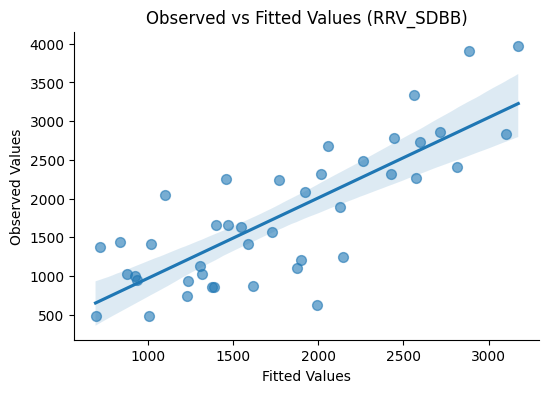

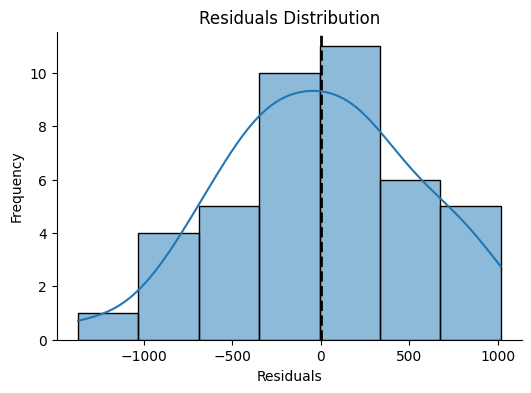

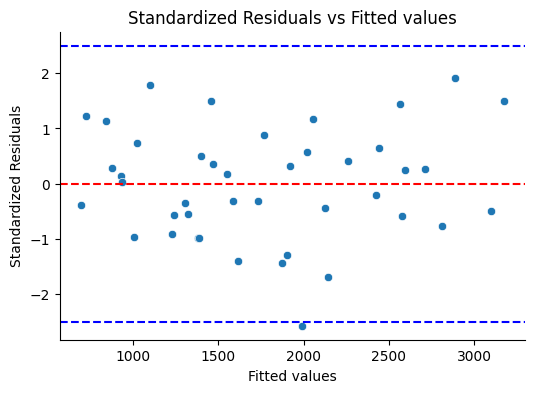

In [ ]:
visual_check(model_sdbb_ii, dv="RRV_SDBB")

One outlier, tolerable, still a very good model

### Model fit

In [ ]:
# Fitting stats and variance partitioning
model_sdbb = model_sdbb_ii.result_fit_stats
model_sdbb_ii.result_fit_stats

shape: (1, 13)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ AIC ‚îÜ AIC ‚îÜ BIC ‚îÜ ICC    ‚îÜ R2_con ‚îÜ R2_ma ‚îÜ REMLc ‚îÜ RMSE  ‚îÜ Sigma ‚îÜ df_re ‚îÜ logLi ‚îÜ nobs ‚îÜ sigma ‚îÇ
‚îÇ --- ‚îÜ c   ‚îÜ --- ‚îÜ ---    ‚îÜ dition ‚îÜ rgina ‚îÜ rit   ‚îÜ ---   ‚îÜ ---   ‚îÜ sidua ‚îÜ k     ‚îÜ ---  ‚îÜ ---   ‚îÇ
‚îÇ f64 ‚îÜ --- ‚îÜ f64 ‚îÜ f64    ‚îÜ al     ‚îÜ l     ‚îÜ ---   ‚îÜ f64   ‚îÜ f64   ‚îÜ l     ‚îÜ ---   ‚îÜ i64  ‚îÜ f64   ‚îÇ
‚îÇ     ‚îÜ f64 ‚îÜ     ‚îÜ        ‚îÜ ---    ‚îÜ ---   ‚îÜ f64   ‚îÜ       ‚îÜ       ‚îÜ ---   ‚îÜ f64   ‚îÜ      ‚îÜ       ‚îÇ
‚îÇ     ‚îÜ     ‚îÜ     ‚îÜ        ‚îÜ f64    ‚îÜ f64   ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ i64   ‚îÜ       ‚îÜ      ‚îÜ       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 581 ‚îÜ 587 ‚îÜ 597 ‚îÜ 0.0708 ‚îÜ 0.5765 ‚îÜ 0.544 ‚îÜ 563.3 ‚îÜ 532.5 ‚îÜ 601.1 ‚îÜ 33    ‚îÜ -281. ‚îÜ 42   ‚îÜ 601.1 ‚îÇ
‚îÇ .39 ‚îÜ .01 ‚îÜ .03 ‚îÜ 65     ‚îÜ 59     ‚îÜ 263   ‚îÜ 94046 ‚îÜ 09277 ‚îÜ 91025 ‚îÜ       ‚îÜ 69702 ‚îÜ      ‚îÜ 91025 ‚îÇ
‚îÇ 404 ‚îÜ 904 ‚îÜ 307 ‚îÜ        ‚îÜ        ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ 3     ‚îÜ      ‚îÜ       ‚îÇ
‚îÇ 6   ‚îÜ 6   ‚îÜ 3   ‚îÜ        ‚îÜ        ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ      ‚îÜ       ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [ ]:
# Check multicollinearity
model_sdbb_ii.vif()

shape: (6, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ term                          ‚îÜ vif      ‚îÜ ci_increase_factor ‚îÇ
‚îÇ ---                           ‚îÜ ---      ‚îÜ ---                ‚îÇ
‚îÇ str                           ‚îÜ f64      ‚îÜ f64                ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ groupexp                      ‚îÜ 3.0      ‚îÜ 1.732051           ‚îÇ
‚îÇ sessionResting state          ‚îÜ 2.666667 ‚îÜ 1.632993           ‚îÇ
‚îÇ sessionExam                   ‚îÜ 2.666667 ‚îÜ 1.632993           ‚îÇ
‚îÇ instrument_type1              ‚îÜ 1.0      ‚îÜ 1.0                ‚îÇ
‚îÇ groupexp:sessionResting state ‚îÜ 3.333333 ‚îÜ 1.825742           ‚îÇ
‚îÇ groupexp:sessionExam          ‚îÜ 3.333333 ‚îÜ 1.825742           ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

### Post-hoc tests

In [ ]:
ph_sdbb = model_sdbb_ii.emmeans("session", contrasts="pairwise", p_adjust='bonf')
ph_sdbb

R messages: 
NOTE: Results may be misleading due to involvement in interactions

R messages: 
NOTE: Results may be misleading due to involvement in interactions



shape: (3, 8)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ contrast   ‚îÜ estimate   ‚îÜ SE         ‚îÜ df        ‚îÜ lower_CL   ‚îÜ upper_CL  ‚îÜ t_ratio   ‚îÜ p_value  ‚îÇ
‚îÇ ---        ‚îÜ ---        ‚îÜ ---        ‚îÜ ---       ‚îÜ ---        ‚îÜ ---       ‚îÜ ---       ‚îÜ ---      ‚îÇ
‚îÇ str        ‚îÜ f64        ‚îÜ f64        ‚îÜ f64       ‚îÜ f64        ‚îÜ f64       ‚îÜ f64       ‚îÜ f64      ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Baseline - ‚îÜ 596.899059 ‚îÜ 229.583615 ‚îÜ 23.999997 ‚îÜ 6.033246   ‚îÜ 1187.7648 ‚îÜ 2.59992   ‚îÜ 0.047122 ‚îÇ
‚îÇ Resting    ‚îÜ            ‚îÜ            ‚îÜ           ‚îÜ            ‚îÜ 73        ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ state      ‚îÜ            ‚îÜ            ‚îÜ           ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ Baseline - ‚îÜ -218.35393 ‚îÜ 229.583615 ‚îÜ 23.999997 ‚îÜ -809.21975 ‚îÜ 372.51187 ‚îÜ -0.951087 ‚îÜ 1.0      ‚îÇ
‚îÇ Exam       ‚îÜ 7          ‚îÜ            ‚îÜ           ‚îÜ 1          ‚îÜ 6         ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ Resting    ‚îÜ -815.25299 ‚îÜ 229.583615 ‚îÜ 23.999997 ‚îÜ -1406.1188 ‚îÜ -224.3871 ‚îÜ -3.551007 ‚îÜ 0.004871 ‚îÇ
‚îÇ state -    ‚îÜ 7          ‚îÜ            ‚îÜ           ‚îÜ 11         ‚îÜ 83        ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ Exam       ‚îÜ            ‚îÜ            ‚îÜ           ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [ ]:
model_sdbb_ii.report()

We fitted a linear mixed model (estimated using REML and nloptwrap optimizer)
to predict RRV_SDBB with group, session and instrument_type (formula: RRV_SDBB
~ group * session + instrument_type). The model included ID as random effect
(formula: ~1 | ID). The model's total explanatory power is substantial
(conditional R2 = 0.58) and the part related to the fixed effects alone
(marginal R2) is of 0.54. The model's intercept, corresponding to group = ctr,
session = Baseline and instrument_type = 2, is at 1674.83 (95% CI [1136.70,
2212.95], t(33) = 6.33, p < .001). Within this model:

  - The effect of group [exp] is statistically non-significant and negative (beta
= -375.13, 95% CI [-1060.66, 310.41], t(33) = -1.11, p = 0.274; Std. beta =
-0.42, 95% CI [-1.19, 0.35])
  - The effect of session [Resting state] is statistically significant and
negative (beta = -893.33, 95% CI [-1599.50, -187.15], t(33) = -2.57, p = 0.015;
Std. beta = -1.00, 95% CI [-1.79, -0.21])
  - The effect of session [Ex

## RMSSD

### Modeling

In [ ]:
rmssd_df = filter_df_for_dv(rrv_data, "RRV_RMSSD")

In [ ]:
model_rmssd_i = lmer("RRV_RMSSD ~ group * session + (1 | ID)",
               data=rmssd_df)

set_factors(model_rmssd_i)

model_rmssd_i.fit(summary=True)

GT(_tbl_data=shape: (10, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ rfx      ‚îÜ param   ‚îÜ estimat ‚îÜ std_err ‚îÜ conf_lo ‚îÜ conf_hi ‚îÜ t_stat  ‚îÜ df      ‚îÜ p_value ‚îÜ stars ‚îÇ
‚îÇ ---      ‚îÜ ---     ‚îÜ e       ‚îÜ or      ‚îÜ w       ‚îÜ gh      ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---   ‚îÇ
‚îÇ str      ‚îÜ str     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ f64     ‚îÜ f64     ‚îÜ str     ‚îÜ str   ‚îÇ
‚îÇ          ‚îÜ         ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ ID-sd    ‚îÜ (Interc ‚îÜ 740.836 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ 087     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ Residual ‚îÜ Observa ‚îÜ 726.687 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ -sd      ‚îÜ tion    ‚îÜ 513     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Fixed    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Effects: ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ (Interc ‚îÜ 2623.55 ‚îÜ 423.657 ‚îÜ 1748.57 ‚îÜ 3498.54 ‚îÜ 6.19264 ‚îÜ 23.6925 ‚îÜ <.001   ‚îÜ ***   ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ 9315    ‚îÜ 261     ‚îÜ 2819    ‚îÜ 5811    ‚îÜ 6       ‚îÜ 29      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ -525.05 ‚îÜ 560.445 ‚îÜ -1682.5 ‚îÜ 632.444 ‚îÜ -0.9368 ‚îÜ 23.6925 ‚îÜ 0.3583  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p       ‚îÜ 3335    ‚îÜ 877     ‚îÜ 51669   ‚îÜ 999     ‚îÜ 49      ‚îÜ 29      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ session ‚îÜ -1171.9 ‚îÜ 419.553 ‚îÜ -2037.8 ‚îÜ -306.04 ‚îÜ -2.7933 ‚îÜ 24.0    ‚îÜ 0.01008 ‚îÜ *     ‚îÇ
‚îÇ          ‚îÜ Resting ‚îÜ 6192    ‚îÜ 231     ‚îÜ 7723    ‚îÜ 661     ‚îÜ 57      ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ state   ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ session ‚îÜ 89.5485 ‚îÜ 419.553 ‚îÜ -776.36 ‚îÜ 955.463 ‚îÜ 0.21343 ‚îÜ 24.0    ‚îÜ 0.8328  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ Exam    ‚îÜ 97      ‚îÜ 231     ‚îÜ 6713    ‚îÜ 907     ‚îÜ 8       ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ 479.528 ‚îÜ 555.016 ‚îÜ -665.97 ‚îÜ 1625.02 ‚îÜ 0.86398 ‚îÜ 24.0    ‚îÜ 0.3961  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p:sessi ‚îÜ 15      ‚îÜ 756     ‚îÜ 0133    ‚îÜ 6434    ‚îÜ 9       ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ onResti ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ ng      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ state   ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ -48.489 ‚îÜ 555.016 ‚îÜ -1193.9 ‚îÜ 1097.00 ‚îÜ -0.0873 ‚îÜ 24.0    ‚îÜ 0.9311  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p:sessi ‚îÜ 319     ‚îÜ 756     ‚îÜ 87603   ‚îÜ 8964    ‚îÜ 66      ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ onExam  ‚îÜ         ‚îÜ        

In [ ]:
model_rmssd_ii = lmer("RRV_RMSSD ~ group * session + instrument_type + (1 | ID)",
               data=rmssd_df)

set_factors(model_rmssd_ii)

model_rmssd_ii.fit(summary=True)

GT(_tbl_data=shape: (11, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ rfx      ‚îÜ param   ‚îÜ estimat ‚îÜ std_err ‚îÜ conf_lo ‚îÜ conf_hi ‚îÜ t_stat  ‚îÜ df      ‚îÜ p_value ‚îÜ stars ‚îÇ
‚îÇ ---      ‚îÜ ---     ‚îÜ e       ‚îÜ or      ‚îÜ w       ‚îÜ gh      ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---   ‚îÇ
‚îÇ str      ‚îÜ str     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ f64     ‚îÜ f64     ‚îÜ str     ‚îÜ str   ‚îÇ
‚îÇ          ‚îÜ         ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ ID-sd    ‚îÜ (Interc ‚îÜ 180.928 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ 944     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ Residual ‚îÜ Observa ‚îÜ 726.687 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ -sd      ‚îÜ tion    ‚îÜ 526     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Fixed    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Effects: ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ (Interc ‚îÜ 2152.69 ‚îÜ 317.329 ‚îÜ 1507.34 ‚îÜ 2798.04 ‚îÜ 6.78377 ‚îÜ 33.3568 ‚îÜ <.001   ‚îÜ ***   ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ 4081    ‚îÜ 689     ‚îÜ 4286    ‚îÜ 3876    ‚îÜ 8       ‚îÜ 94      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ ‚Ä¶        ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶     ‚îÇ
‚îÇ null     ‚îÜ session ‚îÜ -1171.9 ‚îÜ 419.553 ‚îÜ -2037.8 ‚îÜ -306.04 ‚îÜ -2.7933 ‚îÜ 23.9999 ‚îÜ 0.01008 ‚îÜ *     ‚îÇ
‚îÇ          ‚îÜ Resting ‚îÜ 6192    ‚îÜ 239     ‚îÜ 7725    ‚îÜ 6589    ‚îÜ 57      ‚îÜ 98      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ state   ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ session ‚îÜ 89.5485 ‚îÜ 419.553 ‚îÜ -776.36 ‚îÜ 955.463 ‚îÜ 0.21343 ‚îÜ 23.9999 ‚îÜ 0.8328  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ Exam    ‚îÜ 97      ‚îÜ 239     ‚îÜ 6734    ‚îÜ 927     ‚îÜ 8       ‚îÜ 98      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ instrum ‚îÜ 1412.59 ‚îÜ 255.084 ‚îÜ 851.158 ‚îÜ 1974.03 ‚îÜ 5.53775 ‚îÜ 10.9999 ‚îÜ <.001   ‚îÜ ***   ‚îÇ
‚îÇ          ‚îÜ ent_typ ‚îÜ 5701    ‚îÜ 526     ‚îÜ 441     ‚îÜ 2962    ‚îÜ 5       ‚îÜ 99      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ e1      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ 479.528 ‚îÜ 555.016 ‚îÜ -665.97 ‚îÜ 1625.02 ‚îÜ 0.86398 ‚îÜ 23.9999 ‚îÜ 0.3961  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p:sessi ‚îÜ 15      ‚îÜ 766     ‚îÜ 016     ‚îÜ 6461    ‚îÜ 9       ‚îÜ 98      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ onResti ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ ng      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ state   ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ

In [ ]:
model_rmssd_iii = lmer("RRV_RMSSD ~ group * session + instrument_type + gender + (1 | ID)",
               data=rmssd_df)

set_factors(model_rmssd_iii)

model_rmssd_iii.fit(summary=True)

GT(_tbl_data=shape: (12, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ rfx      ‚îÜ param   ‚îÜ estimat ‚îÜ std_err ‚îÜ conf_lo ‚îÜ conf_hi ‚îÜ t_stat  ‚îÜ df      ‚îÜ p_value ‚îÜ stars ‚îÇ
‚îÇ ---      ‚îÜ ---     ‚îÜ e       ‚îÜ or      ‚îÜ w       ‚îÜ gh      ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---   ‚îÇ
‚îÇ str      ‚îÜ str     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ f64     ‚îÜ f64     ‚îÜ str     ‚îÜ str   ‚îÇ
‚îÇ          ‚îÜ         ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ ID-sd    ‚îÜ (Interc ‚îÜ 172.313 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ 27      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ Residual ‚îÜ Observa ‚îÜ 726.687 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ -sd      ‚îÜ tion    ‚îÜ 518     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Fixed    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Effects: ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ (Interc ‚îÜ 2341.03 ‚îÜ 361.375 ‚îÜ 1597.95 ‚îÜ 3084.11 ‚îÜ 6.47811 ‚îÜ 25.8141 ‚îÜ <.001   ‚îÜ ***   ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ 2361    ‚îÜ 456     ‚îÜ 416     ‚îÜ 0561    ‚îÜ 7       ‚îÜ 91      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ ‚Ä¶        ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶     ‚îÇ
‚îÇ null     ‚îÜ session ‚îÜ 89.5485 ‚îÜ 419.553 ‚îÜ -776.36 ‚îÜ 955.463 ‚îÜ 0.21343 ‚îÜ 24.0    ‚îÜ 0.8328  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ Exam    ‚îÜ 97      ‚îÜ 234     ‚îÜ 672     ‚îÜ 914     ‚îÜ 8       ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ instrum ‚îÜ 1394.82 ‚îÜ 253.753 ‚îÜ 829.429 ‚îÜ 1960.22 ‚îÜ 5.49677 ‚îÜ 10.0    ‚îÜ <.001   ‚îÜ ***   ‚îÇ
‚îÇ          ‚îÜ ent_typ ‚îÜ 7939    ‚îÜ 866     ‚îÜ 091     ‚îÜ 6787    ‚îÜ 5       ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ e1      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ gender2 ‚îÜ -273.62 ‚îÜ 253.753 ‚îÜ -839.02 ‚îÜ 291.775 ‚îÜ -1.0783 ‚îÜ 10.0    ‚îÜ 0.3062  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ         ‚îÜ 3538    ‚îÜ 866     ‚îÜ 2387    ‚îÜ 31      ‚îÜ 03      ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ 479.528 ‚îÜ 555.016 ‚îÜ -665.97 ‚îÜ 1625.02 ‚îÜ 0.86398 ‚îÜ 24.0    ‚îÜ 0.3961  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p:sessi ‚îÜ 15      ‚îÜ 76      ‚îÜ 0142    ‚îÜ 6443    ‚îÜ 9       ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ onResti ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ ng      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ state   ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ -48.489 ‚îÜ 555.016 ‚îÜ -1193.9 ‚îÜ 1097.00 ‚îÜ -0.0873 ‚îÜ 24.0    ‚îÜ 0.9311  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p:sessi ‚îÜ

In [ ]:
compare(model_rmssd_i, model_rmssd_ii, model_rmssd_iii)

GT(_tbl_data=shape: (3, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ AIC       ‚îÜ BIC       ‚îÜ logLik    ‚îÜ npar ‚îÜ -2*log(L) ‚îÜ Chisq     ‚îÜ Df  ‚îÜ Pr(>Chisq ‚îÜ stars ‚îÜ ids ‚îÇ
‚îÇ ---       ‚îÜ ---       ‚îÜ ---       ‚îÜ ---  ‚îÜ ---       ‚îÜ ---       ‚îÜ --- ‚îÜ )         ‚îÜ ---   ‚îÜ --- ‚îÇ
‚îÇ f64       ‚îÜ f64       ‚îÜ f64       ‚îÜ i64  ‚îÜ f64       ‚îÜ f64       ‚îÜ f64 ‚îÜ ---       ‚îÜ str   ‚îÜ i64 ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ      ‚îÜ           ‚îÜ           ‚îÜ     ‚îÜ str       ‚îÜ       ‚îÜ     ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 621.13321 ‚îÜ 635.03457 ‚îÜ -302.5666 ‚îÜ 8    ‚îÜ 685.96521 ‚îÜ 0.0       ‚îÜ 0.0 ‚îÜ           ‚îÜ       ‚îÜ 1   ‚îÇ
‚îÇ 5         ‚îÜ 2         ‚îÜ 08        ‚îÜ      ‚îÜ 9         ‚îÜ           ‚îÜ     ‚îÜ           ‚îÜ       ‚îÜ     ‚îÇ
‚îÇ 594.27459 ‚îÜ 609.91361 ‚îÜ -288.1372 ‚îÜ 9    ‚îÜ 667.31991 ‚îÜ 18.645309 ‚îÜ 1.0 ‚îÜ <.001     ‚îÜ ***   ‚îÜ 2   ‚îÇ
‚îÇ 2         ‚îÜ 8         ‚îÜ 96        ‚îÜ      ‚îÜ           ‚îÜ           ‚îÜ     ‚îÜ           ‚îÜ       ‚îÜ     ‚îÇ
‚îÇ 582.20244 ‚îÜ 599.57913 ‚îÜ -281.1012 ‚îÜ 10   ‚îÜ 665.78321 ‚îÜ 1.536691  ‚îÜ 1.0 ‚îÜ 0.215     ‚îÜ       ‚îÜ 3   ‚îÇ
‚îÇ           ‚îÜ 6         ‚îÜ 2         ‚îÜ      ‚îÜ 9         ‚îÜ           ‚îÜ     ‚îÜ           ‚îÜ       ‚îÜ     ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò, _body=<great_tables._gt_data.Body object at 0x7b2a1639a710>, _boxhead=Boxhead([ColInfo(var='ids', type=<ColInfoTypeEnum.stub: 2>, column_label='', column_align='right', column_width=None), ColInfo(var='AIC', type=<ColInfoTypeEnum.default: 1>, column_label='AIC', column_align='right', column_width=None), ColInfo(var='BIC', type=<ColInfoTypeEnum.default: 1>, column_label='BIC', column_align='right', column_width=None), ColInfo(var='logLik', type=<ColInfoTypeEnum.default: 1>, column_label='logLik', column_align='right', column_width=None), ColInfo(var='npar', type=<ColInfoTypeEnum.default: 1>, column_label='npar', column_align='right', column_width=None), ColInfo(var='-2*log(L)', type=<ColInfoTypeEnum.default: 1>, column_label='-2*log(L)', column_align='right', column_width=None), ColInfo(var='Chisq', type=<ColInfoTypeEnum.default: 1>, column_label='Chisq', column_align='right', column_width=None), ColInfo(var='Df', type=<ColInfoTypeEnum.default: 1>, column_label='Df', column_align='right', column_width=None), ColInfo(var='Pr(>Chisq)', type=<ColInfoTypeEnum.default: 1>, column_label='Pr(>Chisq)', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7b2a17211f50>, _spanners=Spanners([]), _heading=Heading(title='Analysis of Deviance Table', subtitle=Md(text='Model 1: lmer(RRV_RMSSD~group*session+(1|ID))   \nModel 2: lmer(RRV_RMSSD~group*session+instrument_type+(1|ID))   \nModel 3: lmer(RRV_RMSSD~group*session+instrument_type+gender+(1|ID))   \n'), preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7b2a169c6090>, _formats=[<great_t

### Assumptions

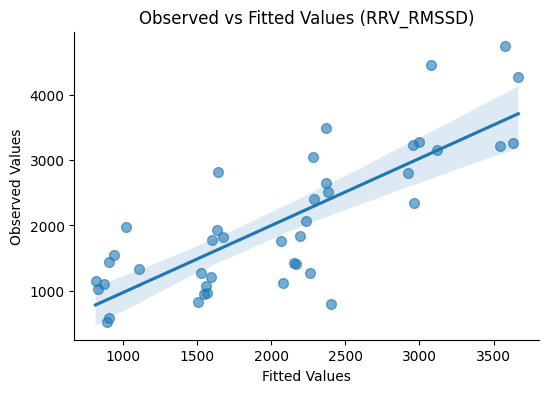

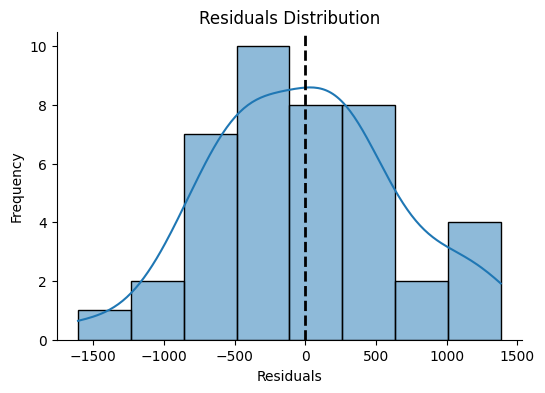

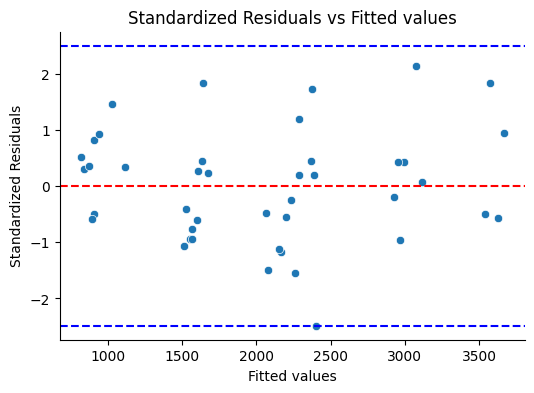

In [ ]:
# Visual check
visual_check(model_rmssd_ii, dv="RRV_RMSSD")

Again one outlier, I can keep it

### Model fit

In [ ]:
# Fitting stats and variance partitioning
model_rmssd_df = model_rmssd_ii.result_fit_stats
model_rmssd_ii.result_fit_stats

shape: (1, 13)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ AIC ‚îÜ AIC ‚îÜ BIC ‚îÜ ICC    ‚îÜ R2_con ‚îÜ R2_ma ‚îÜ REMLc ‚îÜ RMSE  ‚îÜ Sigma ‚îÜ df_re ‚îÜ logLi ‚îÜ nobs ‚îÜ sigma ‚îÇ
‚îÇ --- ‚îÜ c   ‚îÜ --- ‚îÜ ---    ‚îÜ dition ‚îÜ rgina ‚îÜ rit   ‚îÜ ---   ‚îÜ ---   ‚îÜ sidua ‚îÜ k     ‚îÜ ---  ‚îÜ ---   ‚îÇ
‚îÇ f64 ‚îÜ --- ‚îÜ f64 ‚îÜ f64    ‚îÜ al     ‚îÜ l     ‚îÜ ---   ‚îÜ f64   ‚îÜ f64   ‚îÜ l     ‚îÜ ---   ‚îÜ i64  ‚îÜ f64   ‚îÇ
‚îÇ     ‚îÜ f64 ‚îÜ     ‚îÜ        ‚îÜ ---    ‚îÜ ---   ‚îÜ f64   ‚îÜ       ‚îÜ       ‚îÜ ---   ‚îÜ f64   ‚îÜ      ‚îÜ       ‚îÇ
‚îÇ     ‚îÜ     ‚îÜ     ‚îÜ        ‚îÜ f64    ‚îÜ f64   ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ i64   ‚îÜ       ‚îÜ      ‚îÜ       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 594 ‚îÜ 599 ‚îÜ 609 ‚îÜ 0.0583 ‚îÜ 0.5864 ‚îÜ 0.560 ‚îÜ 576.2 ‚îÜ 646.8 ‚îÜ 726.6 ‚îÜ 33    ‚îÜ -288. ‚îÜ 42   ‚îÜ 726.6 ‚îÇ
‚îÇ .27 ‚îÜ .89 ‚îÜ .91 ‚îÜ 71     ‚îÜ 87     ‚îÜ 853   ‚îÜ 74592 ‚îÜ 19074 ‚îÜ 87526 ‚îÜ       ‚îÜ 13729 ‚îÜ      ‚îÜ 87526 ‚îÇ
‚îÇ 459 ‚îÜ 959 ‚îÜ 361 ‚îÜ        ‚îÜ        ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ 6     ‚îÜ      ‚îÜ       ‚îÇ
‚îÇ 2   ‚îÜ 2   ‚îÜ 8   ‚îÜ        ‚îÜ        ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ      ‚îÜ       ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [ ]:
# Check multicollinearity
model_rmssd_ii.vif()

shape: (6, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ term                          ‚îÜ vif      ‚îÜ ci_increase_factor ‚îÇ
‚îÇ ---                           ‚îÜ ---      ‚îÜ ---                ‚îÇ
‚îÇ str                           ‚îÜ f64      ‚îÜ f64                ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ groupexp                      ‚îÜ 3.0      ‚îÜ 1.732051           ‚îÇ
‚îÇ sessionResting state          ‚îÜ 2.666667 ‚îÜ 1.632993           ‚îÇ
‚îÇ sessionExam                   ‚îÜ 2.666667 ‚îÜ 1.632993           ‚îÇ
‚îÇ instrument_type1              ‚îÜ 1.0      ‚îÜ 1.0                ‚îÇ
‚îÇ groupexp:sessionResting state ‚îÜ 3.333333 ‚îÜ 1.825742           ‚îÇ
‚îÇ groupexp:sessionExam          ‚îÜ 3.333333 ‚îÜ 1.825742           ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

### Post-hoc tests

In [ ]:
ph_rmssd = model_rmssd_ii.emmeans("session", contrasts="pairwise", p_adjust='bonf')
ph_rmssd

R messages: 
NOTE: Results may be misleading due to involvement in interactions

R messages: 
NOTE: Results may be misleading due to involvement in interactions



shape: (3, 8)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ contrast   ‚îÜ estimate   ‚îÜ SE         ‚îÜ df        ‚îÜ lower_CL   ‚îÜ upper_CL  ‚îÜ t_ratio   ‚îÜ p_value  ‚îÇ
‚îÇ ---        ‚îÜ ---        ‚îÜ ---        ‚îÜ ---       ‚îÜ ---        ‚îÜ ---       ‚îÜ ---       ‚îÜ ---      ‚îÇ
‚îÇ str        ‚îÜ f64        ‚îÜ f64        ‚îÜ f64       ‚îÜ f64        ‚îÜ f64       ‚îÜ f64       ‚îÜ f64      ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Baseline - ‚îÜ 932.197845 ‚îÜ 277.508383 ‚îÜ 23.999998 ‚îÜ 217.990883 ‚îÜ 1646.4048 ‚îÜ 3.35917   ‚îÜ 0.007818 ‚îÇ
‚îÇ Resting    ‚îÜ            ‚îÜ            ‚îÜ           ‚îÜ            ‚îÜ 06        ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ state      ‚îÜ            ‚îÜ            ‚îÜ           ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ Baseline - ‚îÜ -65.303937 ‚îÜ 277.508383 ‚îÜ 23.999998 ‚îÜ -779.51089 ‚îÜ 648.90302 ‚îÜ -0.235322 ‚îÜ 1.0      ‚îÇ
‚îÇ Exam       ‚îÜ            ‚îÜ            ‚îÜ           ‚îÜ 9          ‚îÜ 5         ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ Resting    ‚îÜ -997.50178 ‚îÜ 277.508383 ‚îÜ 23.999998 ‚îÜ -1711.7087 ‚îÜ -283.2948 ‚îÜ -3.594492 ‚îÜ 0.004372 ‚îÇ
‚îÇ state -    ‚îÜ 2          ‚îÜ            ‚îÜ           ‚îÜ 43         ‚îÜ 2         ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ Exam       ‚îÜ            ‚îÜ            ‚îÜ           ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [ ]:
model_rmssd_ii.report()

We fitted a linear mixed model (estimated using REML and nloptwrap optimizer)
to predict RRV_RMSSD with group, session and instrument_type (formula:
RRV_RMSSD ~ group * session + instrument_type). The model included ID as random
effect (formula: ~1 | ID). The model's total explanatory power is substantial
(conditional R2 = 0.59) and the part related to the fixed effects alone
(marginal R2) is of 0.56. The model's intercept, corresponding to group = ctr,
session = Baseline and instrument_type = 2, is at 2152.69 (95% CI [1507.08,
2798.31], t(33) = 6.78, p < .001). Within this model:

  - The effect of group [exp] is statistically non-significant and negative (beta
= -583.91, 95% CI [-1407.03, 239.21], t(33) = -1.44, p = 0.158; Std. beta =
-0.53, 95% CI [-1.29, 0.22])
  - The effect of session [Resting state] is statistically significant and
negative (beta = -1171.96, 95% CI [-2025.55, -318.37], t(33) = -2.79, p =
0.009; Std. beta = -1.07, 95% CI [-1.85, -0.29])
  - The effect of session 

## RRV LFHF

### Modeling

In [ ]:
rrv_lfhf_df = filter_df_for_dv(rrv_data, "RRV_LFHF")

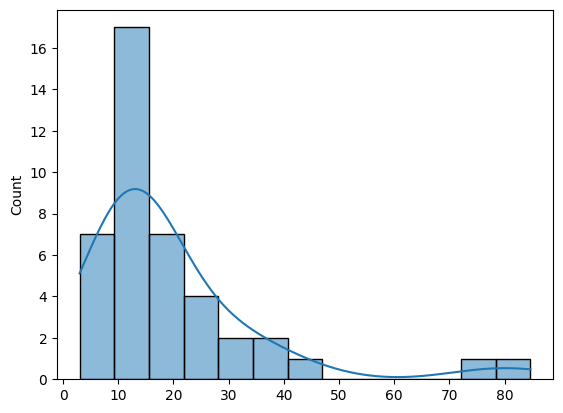

In [ ]:
# dv distribution
sns.histplot(rrv_lfhf_df["RRV_LFHF"], kde=True)
plt.show()

In [ ]:
# Apply log-transformation (should I try with box-cox as well?)
rrv_lfhf_df = rrv_lfhf_df.with_columns(
    pl.col("RRV_LFHF").log().alias("RRV_LFHF_log"))

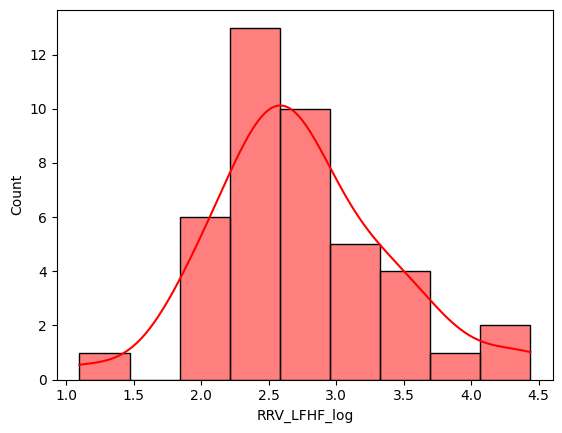

In [ ]:
# transformed dv distribution
rrv_lfhf_pandas = rrv_lfhf_df.to_pandas()

sns.histplot(rrv_lfhf_pandas["RRV_LFHF_log"], kde=True, color="red")
plt.show()

It's much better now

In [ ]:
model_rrv_lfhf_log_i = lmer("RRV_LFHF_log ~ group * session + (1 | ID)",
               data=rrv_lfhf_df)

set_factors(model_rrv_lfhf_log_i)

model_rrv_lfhf_log_i.fit(summary=True)

GT(_tbl_data=shape: (10, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ rfx      ‚îÜ param   ‚îÜ estimat ‚îÜ std_err ‚îÜ conf_lo ‚îÜ conf_hi ‚îÜ t_stat  ‚îÜ df      ‚îÜ p_value ‚îÜ stars ‚îÇ
‚îÇ ---      ‚îÜ ---     ‚îÜ e       ‚îÜ or      ‚îÜ w       ‚îÜ gh      ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---   ‚îÇ
‚îÇ str      ‚îÜ str     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ f64     ‚îÜ f64     ‚îÜ str     ‚îÜ str   ‚îÇ
‚îÇ          ‚îÜ         ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ ID-sd    ‚îÜ (Interc ‚îÜ 0.19139 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ Residual ‚îÜ Observa ‚îÜ 0.59618 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ -sd      ‚îÜ tion    ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Fixed    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Effects: ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ (Interc ‚îÜ 2.85557 ‚îÜ 0.25562 ‚îÜ 2.33683 ‚îÜ 3.37431 ‚îÜ 11.1710 ‚îÜ 35.3822 ‚îÜ <.001   ‚îÜ ***   ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ 4       ‚îÜ 4       ‚îÜ 1       ‚îÜ 7       ‚îÜ 13      ‚îÜ 89      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ -0.5314 ‚îÜ 0.33815 ‚îÜ -1.2176 ‚îÜ 0.15481 ‚îÜ -1.5715 ‚îÜ 35.3822 ‚îÜ 0.125   ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p       ‚îÜ 22      ‚îÜ 8       ‚îÜ 55      ‚îÜ         ‚îÜ 2       ‚îÜ 89      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ session ‚îÜ 0.14225 ‚îÜ 0.34420 ‚îÜ -0.5681 ‚îÜ 0.85265 ‚îÜ 0.41328 ‚îÜ 23.9999 ‚îÜ 0.6831  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ Resting ‚îÜ 5       ‚îÜ 5       ‚îÜ 48      ‚îÜ 8       ‚îÜ 7       ‚îÜ 99      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ state   ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ session ‚îÜ -0.0465 ‚îÜ 0.34420 ‚îÜ -0.7569 ‚îÜ 0.66381 ‚îÜ -0.1353 ‚îÜ 23.9999 ‚îÜ 0.8935  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ Exam    ‚îÜ 88      ‚îÜ 5       ‚îÜ 92      ‚îÜ 5       ‚îÜ 51      ‚îÜ 99      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ 0.64848 ‚îÜ 0.45534 ‚îÜ -0.2912 ‚îÜ 1.58825 ‚îÜ 1.42417 ‚îÜ 23.9999 ‚îÜ 0.1673  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p:sessi ‚îÜ 3       ‚îÜ         ‚îÜ 93      ‚îÜ 8       ‚îÜ 3       ‚îÜ 99      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ onResti ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ ng      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ state   ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ 0.18342 ‚îÜ 0.45534 ‚îÜ -0.7563 ‚îÜ 1.12319 ‚îÜ 0.40282 ‚îÜ 23.9999 ‚îÜ 0.6906  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p:sessi ‚îÜ 4       ‚îÜ         ‚îÜ 51      ‚îÜ 9       ‚îÜ 9       ‚îÜ 99      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ onExam  ‚îÜ         ‚îÜ        

In [ ]:
model_rrv_lfhf_log_ii = lmer("RRV_LFHF_log ~ group * session + instrument_type + (1 | ID)",
               data=rrv_lfhf_df)

set_factors(model_rrv_lfhf_log_ii)

model_rrv_lfhf_log_ii.fit(summary=True)

GT(_tbl_data=shape: (11, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ rfx      ‚îÜ param   ‚îÜ estimat ‚îÜ std_err ‚îÜ conf_lo ‚îÜ conf_hi ‚îÜ t_stat  ‚îÜ df      ‚îÜ p_value ‚îÜ stars ‚îÇ
‚îÇ ---      ‚îÜ ---     ‚îÜ e       ‚îÜ or      ‚îÜ w       ‚îÜ gh      ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---   ‚îÇ
‚îÇ str      ‚îÜ str     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ f64     ‚îÜ f64     ‚îÜ str     ‚îÜ str   ‚îÇ
‚îÇ          ‚îÜ         ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ ID-sd    ‚îÜ (Interc ‚îÜ 0.08187 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ 3       ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ Residual ‚îÜ Observa ‚îÜ 0.59618 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ -sd      ‚îÜ tion    ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Fixed    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Effects: ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ (Interc ‚îÜ 2.72606 ‚îÜ 0.25434 ‚îÜ 2.20923 ‚îÜ 3.24289 ‚îÜ 10.7180 ‚îÜ 34.1042 ‚îÜ <.001   ‚îÜ ***   ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ 6       ‚îÜ 4       ‚îÜ 5       ‚îÜ 7       ‚îÜ 3       ‚îÜ 07      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ ‚Ä¶        ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶     ‚îÇ
‚îÇ null     ‚îÜ session ‚îÜ 0.14225 ‚îÜ 0.34420 ‚îÜ -0.5681 ‚îÜ 0.85265 ‚îÜ 0.41328 ‚îÜ 23.9999 ‚îÜ 0.6831  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ Resting ‚îÜ 5       ‚îÜ 5       ‚îÜ 48      ‚îÜ 8       ‚îÜ 6       ‚îÜ 63      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ state   ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ session ‚îÜ -0.0465 ‚îÜ 0.34420 ‚îÜ -0.7569 ‚îÜ 0.66381 ‚îÜ -0.1353 ‚îÜ 23.9999 ‚îÜ 0.8935  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ Exam    ‚îÜ 88      ‚îÜ 5       ‚îÜ 92      ‚îÜ 5       ‚îÜ 51      ‚îÜ 63      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ instrum ‚îÜ 0.38852 ‚îÜ 0.19752 ‚îÜ -0.0462 ‚îÜ 0.82328 ‚îÜ 1.96693 ‚îÜ 10.9999 ‚îÜ 0.07492 ‚îÜ .     ‚îÇ
‚îÇ          ‚îÜ ent_typ ‚îÜ 4       ‚îÜ 8       ‚îÜ 31      ‚îÜ         ‚îÜ 7       ‚îÜ 71      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ e1      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ 0.64848 ‚îÜ 0.45534 ‚îÜ -0.2912 ‚îÜ 1.58825 ‚îÜ 1.42417 ‚îÜ 23.9999 ‚îÜ 0.1673  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p:sessi ‚îÜ 3       ‚îÜ         ‚îÜ 93      ‚îÜ 8       ‚îÜ 3       ‚îÜ 63      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ onResti ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ ng      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ state   ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ

In [ ]:
model_rrv_lfhf_log_iii = lmer("RRV_LFHF_log ~ group * session + instrument_type + gender + (1 | ID)",
               data=rrv_lfhf_df)

set_factors(model_rrv_lfhf_log_iii)

model_rrv_lfhf_log_iii.fit(summary=True)

GT(_tbl_data=shape: (12, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ rfx      ‚îÜ param   ‚îÜ estimat ‚îÜ std_err ‚îÜ conf_lo ‚îÜ conf_hi ‚îÜ t_stat  ‚îÜ df      ‚îÜ p_value ‚îÜ stars ‚îÇ
‚îÇ ---      ‚îÜ ---     ‚îÜ e       ‚îÜ or      ‚îÜ w       ‚îÜ gh      ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---   ‚îÇ
‚îÇ str      ‚îÜ str     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÜ f64     ‚îÜ f64     ‚îÜ str     ‚îÜ str   ‚îÇ
‚îÇ          ‚îÜ         ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ ID-sd    ‚îÜ (Interc ‚îÜ 0.11869 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ Residual ‚îÜ Observa ‚îÜ 0.59618 ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ -sd      ‚îÜ tion    ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Fixed    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null    ‚îÜ null  ‚îÇ
‚îÇ Effects: ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ (Interc ‚îÜ 2.81332 ‚îÜ 0.29297 ‚îÜ 2.21147 ‚îÜ 3.41517 ‚îÜ 9.60251 ‚îÜ 26.3363 ‚îÜ <.001   ‚îÜ ***   ‚îÇ
‚îÇ          ‚îÜ ept)    ‚îÜ         ‚îÜ 8       ‚îÜ         ‚îÜ         ‚îÜ 1       ‚îÜ 34      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ ‚Ä¶        ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶     ‚îÇ
‚îÇ null     ‚îÜ session ‚îÜ -0.0465 ‚îÜ 0.34420 ‚îÜ -0.7569 ‚îÜ 0.66381 ‚îÜ -0.1353 ‚îÜ 23.9999 ‚îÜ 0.8935  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ Exam    ‚îÜ 88      ‚îÜ 5       ‚îÜ 92      ‚îÜ 5       ‚îÜ 51      ‚îÜ 99      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ instrum ‚îÜ 0.38029 ‚îÜ 0.2037  ‚îÜ -0.0735 ‚îÜ 0.83416 ‚îÜ 1.86692 ‚îÜ 10.0    ‚îÜ 0.09147 ‚îÜ .     ‚îÇ
‚îÇ          ‚îÜ ent_typ ‚îÜ 3       ‚îÜ         ‚îÜ 79      ‚îÜ 5       ‚îÜ 6       ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ e1      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ gender2 ‚îÜ -0.1267 ‚îÜ 0.2037  ‚îÜ -0.5806 ‚îÜ 0.32710 ‚îÜ -0.6223 ‚îÜ 10.0    ‚îÜ 0.5477  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ         ‚îÜ 65      ‚îÜ         ‚îÜ 37      ‚îÜ 6       ‚îÜ 15      ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ 0.64848 ‚îÜ 0.45534 ‚îÜ -0.2912 ‚îÜ 1.58825 ‚îÜ 1.42417 ‚îÜ 23.9999 ‚îÜ 0.1673  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p:sessi ‚îÜ 3       ‚îÜ         ‚îÜ 93      ‚îÜ 8       ‚îÜ 3       ‚îÜ 99      ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ onResti ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ ng      ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ state   ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÜ       ‚îÇ
‚îÇ null     ‚îÜ groupex ‚îÜ 0.18342 ‚îÜ 0.45534 ‚îÜ -0.7563 ‚îÜ 1.12319 ‚îÜ 0.40282 ‚îÜ 23.9999 ‚îÜ 0.6906  ‚îÜ       ‚îÇ
‚îÇ          ‚îÜ p:sessi ‚îÜ

In [ ]:
compare(model_rrv_lfhf_log_i, model_rrv_lfhf_log_ii, model_rrv_lfhf_log_iii)

GT(_tbl_data=shape: (3, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ AIC       ‚îÜ BIC        ‚îÜ logLik    ‚îÜ npar ‚îÜ -2*log(L) ‚îÜ Chisq    ‚îÜ Df  ‚îÜ Pr(>Chisq ‚îÜ stars ‚îÜ ids ‚îÇ
‚îÇ ---       ‚îÜ ---        ‚îÜ ---       ‚îÜ ---  ‚îÜ ---       ‚îÜ ---      ‚îÜ --- ‚îÜ )         ‚îÜ ---   ‚îÜ --- ‚îÇ
‚îÇ f64       ‚îÜ f64        ‚îÜ f64       ‚îÜ i64  ‚îÜ f64       ‚îÜ f64      ‚îÜ f64 ‚îÜ ---       ‚îÜ str   ‚îÜ i64 ‚îÇ
‚îÇ           ‚îÜ            ‚îÜ           ‚îÜ      ‚îÜ           ‚îÜ          ‚îÜ     ‚îÜ str       ‚îÜ       ‚îÜ     ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 95.770605 ‚îÜ 109.671962 ‚îÜ -39.88530 ‚îÜ 8    ‚îÜ 73.042174 ‚îÜ 0.0      ‚îÜ 0.0 ‚îÜ           ‚îÜ       ‚îÜ 1   ‚îÇ
‚îÇ           ‚îÜ            ‚îÜ 2         ‚îÜ      ‚îÜ           ‚îÜ          ‚îÜ     ‚îÜ           ‚îÜ       ‚îÜ     ‚îÇ
‚îÇ 95.604149 ‚îÜ 111.243175 ‚îÜ -38.80207 ‚îÜ 9    ‚îÜ 68.827713 ‚îÜ 4.21446  ‚îÜ 1.0 ‚îÜ 0.0401    ‚îÜ *     ‚îÜ 2   ‚îÇ
‚îÇ           ‚îÜ            ‚îÜ 4         ‚îÜ      ‚îÜ           ‚îÜ          ‚îÜ     ‚îÜ           ‚îÜ       ‚îÜ     ‚îÇ
‚îÇ 98.578937 ‚îÜ 115.955633 ‚îÜ -39.28946 ‚îÜ 10   ‚îÜ 68.313676 ‚îÜ 0.514037 ‚îÜ 1.0 ‚îÜ 0.473     ‚îÜ       ‚îÜ 3   ‚îÇ
‚îÇ           ‚îÜ            ‚îÜ 9         ‚îÜ      ‚îÜ           ‚îÜ          ‚îÜ     ‚îÜ           ‚îÜ       ‚îÜ     ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò, _body=<great_tables._gt_data.Body object at 0x7b2a16ca68d0>, _boxhead=Boxhead([ColInfo(var='ids', type=<ColInfoTypeEnum.stub: 2>, column_label='', column_align='right', column_width=None), ColInfo(var='AIC', type=<ColInfoTypeEnum.default: 1>, column_label='AIC', column_align='right', column_width=None), ColInfo(var='BIC', type=<ColInfoTypeEnum.default: 1>, column_label='BIC', column_align='right', column_width=None), ColInfo(var='logLik', type=<ColInfoTypeEnum.default: 1>, column_label='logLik', column_align='right', column_width=None), ColInfo(var='npar', type=<ColInfoTypeEnum.default: 1>, column_label='npar', column_align='right', column_width=None), ColInfo(var='-2*log(L)', type=<ColInfoTypeEnum.default: 1>, column_label='-2*log(L)', column_align='right', column_width=None), ColInfo(var='Chisq', type=<ColInfoTypeEnum.default: 1>, column_label='Chisq', column_align='right', column_width=None), ColInfo(var='Df', type=<ColInfoTypeEnum.default: 1>, column_label='Df', column_align='right', column_width=None), ColInfo(var='Pr(>Chisq)', type=<ColInfoTypeEnum.default: 1>, column_label='Pr(>Chisq)', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7b2a15d41690>, _spanners=Spanners([]), _heading=Heading(title='Analysis of Deviance Table', subtitle=Md(text='Model 1: lmer(RRV_LFHF_log~group*session+(1|ID))   \nModel 2: lmer(RRV_LFHF_log~group*session+instrument_type+(1|ID))   \nModel 3: lmer(RRV_LFHF_log~group*session+instrument_type+gender+(1|ID))   \n'), preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7b2a15cd6310>, _formats=

### Assumptions

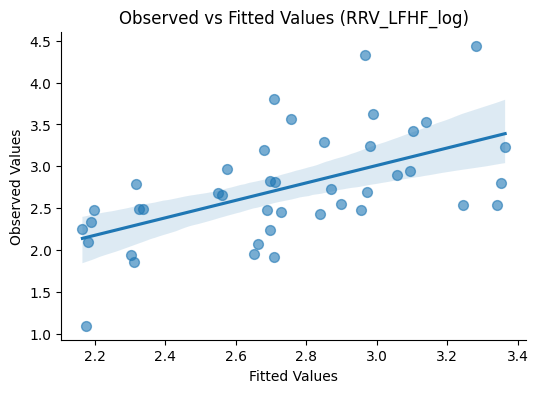

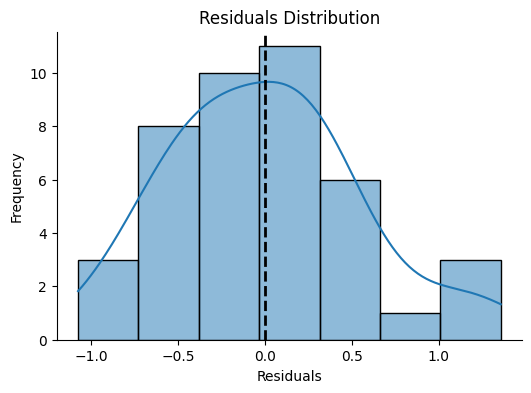

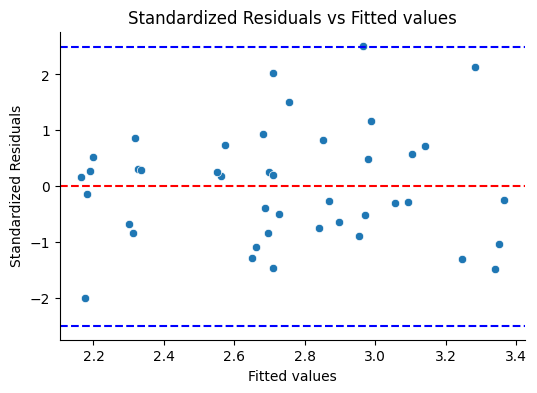

In [ ]:
visual_check(model_rrv_lfhf_log_ii, dv="RRV_LFHF_log")

### Model fit

In [ ]:
# Fitting stats and variance partitioning
model_rrv_lfhf_df = model_rrv_lfhf_log_ii.result_fit_stats
model_rrv_lfhf_log_ii.result_fit_stats

shape: (1, 13)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ AIC ‚îÜ AIC ‚îÜ BIC ‚îÜ ICC    ‚îÜ R2_con ‚îÜ R2_ma ‚îÜ REMLc ‚îÜ RMSE  ‚îÜ Sigma ‚îÜ df_re ‚îÜ logLi ‚îÜ nobs ‚îÜ sigma ‚îÇ
‚îÇ --- ‚îÜ c   ‚îÜ --- ‚îÜ ---    ‚îÜ dition ‚îÜ rgina ‚îÜ rit   ‚îÜ ---   ‚îÜ ---   ‚îÜ sidua ‚îÜ k     ‚îÜ ---  ‚îÜ ---   ‚îÇ
‚îÇ f64 ‚îÜ --- ‚îÜ f64 ‚îÜ f64    ‚îÜ al     ‚îÜ l     ‚îÜ ---   ‚îÜ f64   ‚îÜ f64   ‚îÜ l     ‚îÜ ---   ‚îÜ i64  ‚îÜ f64   ‚îÇ
‚îÇ     ‚îÜ f64 ‚îÜ     ‚îÜ        ‚îÜ ---    ‚îÜ ---   ‚îÜ f64   ‚îÜ       ‚îÜ       ‚îÜ ---   ‚îÜ f64   ‚îÜ      ‚îÜ       ‚îÇ
‚îÇ     ‚îÜ     ‚îÜ     ‚îÜ        ‚îÜ f64    ‚îÜ f64   ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ i64   ‚îÜ       ‚îÜ      ‚îÜ       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 95. ‚îÜ 101 ‚îÜ 111 ‚îÜ 0.0185 ‚îÜ 0.2691 ‚îÜ 0.255 ‚îÜ 77.60 ‚îÜ 0.539 ‚îÜ 0.596 ‚îÜ 33    ‚îÜ -38.8 ‚îÜ 42   ‚îÜ 0.596 ‚îÇ
‚îÇ 604 ‚îÜ .22 ‚îÜ .24 ‚îÜ 1      ‚îÜ 12     ‚îÜ 328   ‚îÜ 4149  ‚îÜ 636   ‚îÜ 18    ‚îÜ       ‚îÜ 02074 ‚îÜ      ‚îÜ 18    ‚îÇ
‚îÇ 149 ‚îÜ 914 ‚îÜ 317 ‚îÜ        ‚îÜ        ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ      ‚îÜ       ‚îÇ
‚îÇ     ‚îÜ 9   ‚îÜ 5   ‚îÜ        ‚îÜ        ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ       ‚îÜ      ‚îÜ       ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [ ]:
# Check multicollinearity
model_rrv_lfhf_log_ii.vif()

shape: (6, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ term                          ‚îÜ vif      ‚îÜ ci_increase_factor ‚îÇ
‚îÇ ---                           ‚îÜ ---      ‚îÜ ---                ‚îÇ
‚îÇ str                           ‚îÜ f64      ‚îÜ f64                ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ groupexp                      ‚îÜ 3.0      ‚îÜ 1.732051           ‚îÇ
‚îÇ sessionResting state          ‚îÜ 2.666667 ‚îÜ 1.632993           ‚îÇ
‚îÇ sessionExam                   ‚îÜ 2.666667 ‚îÜ 1.632993           ‚îÇ
‚îÇ instrument_type1              ‚îÜ 1.0      ‚îÜ 1.0                ‚îÇ
‚îÇ groupexp:sessionResting state ‚îÜ 3.333333 ‚îÜ 1.825742           ‚îÇ
‚îÇ groupexp:sessionExam          ‚îÜ 3.333333 ‚îÜ 1.825742           ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

### Post-hoc tests

There were no significant effects